### Libraries

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import numpy as np
import sklearn
import pandas as pd
import os
from numpy.linalg import inv, svd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt 
from itertools import combinations
from sklearn import linear_model as lm
import cvxpy as cp
import seaborn as sns
from scipy.stats.stats import pearsonr 
from scipy.stats import ttest_rel
from scipy.optimize import linear_sum_assignment
from statsmodels.stats.multitest import multipletests
import warnings

from joshiboyd import *
warnings.filterwarnings('ignore')
import colorsys




import matplotlib.font_manager as mfm

font_path = 'FreeSerif.ttf'
prop = mfm.FontProperties(fname=font_path)


from colormath.color_objects import LabColor, XYZColor,HSLColor, sRGBColor,LCHabColor,AdobeRGBColor
from colormath.color_conversions import convert_color
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm import tqdm, trange

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_76530/1158719862.py:16: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


### Helper Functions

In [3]:
## convert hex to rgb
def hex_to_rgb(hex_str):
    if hex_str.startswith('#'):
        hex_str = hex_str[1:]
    return tuple([int(hex_str[i:i + 2], 16) for i in range(0, len(hex_str), 2)])

In [4]:
#### Function to solve the assignment problem
"""
Input is a m x n array of (concepts) x (colors) filled with association ratings
Output is a list of length m with the index of the color that should be associated with each concept
"""
def assignment_solve( ratings, method="balanced" ):
    m,n = ratings.shape
    assert m <= n, "More concepts than colors, assignment impossible!"
    
    # isolated merit function (only considers target in isolation)
    if method == "isolated":
        merit_matrix = ratings
    
    # balanced merit function (balances ratings of target vs off-target objects with each color)
    elif method == "balanced":
        t = 1  # this is the penalty parameter. t=1 for balanced, t=0 recovers isolated case.
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = ratings[i,j] - t*ratings[np.arange(m)!=i,j].max()
                
  
    
    # baseline merit function (uniformly bad assignment)
    elif method == "baseline":
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = -abs( ratings[i,j] - ratings[np.arange(m)!=i,j].max() )
                
    else:
        assert False, "unknown method in assignment problem"
        
    row_ind, col_ind = linear_sum_assignment( merit_matrix, maximize=True )
    return col_ind

In [5]:
### This function takes the grouped ratings dataframe and returns a matrix of ratings
def plot_mean_assocs(grouped_ratings_df,df_name):
    Tot = len(np.unique(grouped_ratings_df.prompt))
    Cols = 5
    Rows = Tot // Cols 
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    fig = plt.figure(1,figsize=(30,(Rows/2)*5 ))
    for i,con in enumerate(np.unique(grouped_ratings_df.prompt)):
        ax= fig.add_subplot(Rows, Cols, Position[i])
        ds = grouped_ratings_df[grouped_ratings_df.prompt==con]

        plt.bar(np.arange(71),ds.iloc[sorted_col_order,3].values,color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none') 
        #plt.bar(np.arange(71),ds.iloc[:,3].values) 

        plt.title(con,fontsize=20)   
        plt.ylim(0,1)

        ax.set_facecolor((0.349,0.349,0.349))
        plt.xticks([])

    plt.savefig(f'../../data/recon_assocs/{df_name}_mean_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
    plt.show()


In [6]:
### This function takes a grouped ratings dataframe and returns a matrix of ratings and also returns the column means
def make_ratings_mat(grouped_ratings_df):
    
    mat = np.zeros((len(np.unique(grouped_ratings_df.prompt)),71))
    for i,con in enumerate(np.unique(grouped_ratings_df.prompt)):
        ds = grouped_ratings_df[grouped_ratings_df.prompt==con]
        mat[i,:] = ds.iloc[:,3].values


    mat = pd.DataFrame(mat, index =np.unique(grouped_ratings_df.prompt), columns = np.arange(mat.shape[1]) )
    cmeans = mat.mean().values
    return mat, cmeans

In [175]:
### This function takes in a matrix of right singular vectors and visualizes them in a sorted order
def plot_components(basis_vecs,num_comps,save=False,facet=False, fname='all_components'):
    '''
    basis_vecs are right singular vectors
    '''
    v_sub = basis_vecs[0:num_comps,]
    v_sub_df = pd.DataFrame(v_sub.T, columns=[f'C{x}' for x in np.arange(num_comps) ])
    v_sub_df = pd.concat([v_sub_df, uw71rgb],axis=1)

    components = [f'C{x}' for x in np.arange(num_comps) ]

    Tot = len(components)
    Cols = 3
    Rows = Tot // Cols 
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(1,figsize=(14,(Rows/2)*10 ))
    for i in range(len(components)):
        ax= fig.add_subplot(Rows, Cols, Position[i])
        # sns.set_theme(rc={'axes.grid':False})
        plotdf = v_sub_df.sort_values([str(components[i])]).reset_index(drop=True)
        sns.barplot(x=plotdf.index, y=plotdf[components[i]], edgecolor = 'none',palette = sns.color_palette(list(zip(plotdf['r_rgb'],plotdf['g_rgb'],plotdf['b_rgb']))))
        plt.xticks([])
        plt.ylabel('')
        plt.yticks(fontsize=20)
        plt.ylim(-0.4,0.4)
        # plt.gca().set_facecolor((0.3497,0.3497,0.3497))
        plt.title(f'Component {i+1}',fontsize=25)
        if save==True and facet==False:
            subplot_ext = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig('../../data/recon_assocs/component_{}.pdf'.format(i),format ='pdf',bbox_inches=subplot_ext.expanded(1.2, 1.2))
    if save==True and facet==True:
        plt.savefig(f'../../data/recon_assocs/{fname}.pdf',format ='pdf',bbox_inches='tight')
        
    plt.show()


In [9]:
def colorimetric_reg(pc,exclude_regressor=None):
    '''
    should be 71 rows and n columns
    '''
    regressors = np.array((uw71coords['L'],np.cos(uw71coords['H']*(np.pi/180)),\
                 np.sin(uw71coords['H']*(np.pi/180)),np.cos(2*uw71coords['H']*(np.pi/180)),\
                 np.sin(2*uw71coords['H']*(np.pi/180)),uw71coords['C']))
    if exclude_regressor!=None:
        regressors = np.delete(regressors,int(exclude_regressor),axis=1)


    model = lm.LinearRegression(fit_intercept=True).fit(regressors.T, pc)
    preds = model.predict(regressors.T)

    return np.hstack((model.intercept_.reshape(pc.shape[1],1),model.coef_)),preds ## weights and predictions

In [10]:
### This funciton plots the reconstructed associations for a given matrix of color concept associations. We specify the numer of principal components to use and whether we want to use holdout mode.
### If we don't use holdout, we fit the PCs on concept set 1 and and use them to predict associations for the given color concept association matrix.
def reconstruct_assocs(ratings_mat,cmeans,df_name,num_pc=6,holdout_mode=False,compute_col_inds=None,plot=True):

    #num_pcs =[] ## track the number of components 
    pvals = [] ## track the pvalues
    con_reg_cors = [] ### track the correlations
    cons = [] ## track the concept names
    
    recon_ratings=[]
    if compute_col_inds!=None:
        color_inds = return_rows((ratings_mat-cmeans),compute_col_inds)
    else:
        # color_inds = [11, 14, 24, 37, 43, 44, 62, 68]
        color_inds= [11, 20, 24, 37, 62, 68] ### colors from set 1
        



    Tot = ratings_mat.shape[0]
    Cols = 5
    Rows = Tot // Cols 
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    fig = plt.figure(1,figsize=(30,(Rows/2)*5 ))
    
    if holdout_mode==True:
        for i,this_concept in tqdm(enumerate(ratings_mat.index.values)):
            ax = fig.add_subplot(Rows, Cols, Position[i])
            concept_ratings = ratings_mat-cmeans
            concept_ratings_inv= concept_ratings[concept_ratings.index!=this_concept]
            #color_inds = return_rows(concept_ratings_inv,8)


            _,_,Vh = svd(concept_ratings_inv, full_matrices=False)
            basis_vecs = Vh[0:num_pc,color_inds]
            #concept_ratings = np.array(ratings[ratings.iloc[:,0].isin([this_concept])].iloc[:,1:59])-c_means.V1.values
            #reg = lm.LinearRegression().fit(A[color_inds,:], concept_ratings.squeeze(0)[color_inds])
            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs.T, concept_ratings[concept_ratings.index==this_concept].squeeze(0).values[color_inds])
            coords = reg.coef_
            recon = coords@Vh[0:num_pc,:]

            plt.bar(np.arange(71),recon[sorted_col_order]+cmeans[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
            plt.title(this_concept,fontsize=20)   
            plt.ylim(-2,2)
            ax.set_facecolor((0.349,0.349,0.349))
            plt.xticks([])

            con_reg_cors.append(np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1]    )
            ### compute the statistical significance for a np.corr value
            pvals.append(pearsonr(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[1])
        


            #num_pcs.append(num_pc)
            cons.append(this_concept)
            recon_ratings.append(recon)
    elif holdout_mode==False:
        
        for i, this_concept in tqdm(enumerate(ratings_mat.index.values)):
            ax = fig.add_subplot(Rows, Cols, Position[i])
            concept_ratings = ratings_mat-cmeans
            #color_inds = return_rows(concept_ratings_inv,8)

            
            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1[0:num_pc,color_inds].T, concept_ratings[concept_ratings.index==this_concept].squeeze(0).values[color_inds])
            coords = reg.coef_
            recon = coords@basis_vecs1[0:num_pc,:]
            
            plt.bar(np.arange(71),recon[sorted_col_order]+cmeans[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
            plt.title(this_concept,fontsize=20)   
            plt.ylim(-2,2)
            ax.set_facecolor((0.349,0.349,0.349))
            plt.xticks([])

            con_reg_cors.append(np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1]    )
            pvals.append(pearsonr(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[1])
            #num_pcs.append(num_pc)
            cons.append(this_concept)
            recon_ratings.append(recon+cmeans)
    recon_ratings = [y for x in recon_ratings for y in x]
            
            
    holdout_con_cor_df = pd.DataFrame(list(zip(cons, con_reg_cors,pvals)),columns=['concept','holdout_cor','pvals'])
    recon_ratings_df = pd.DataFrame(list(zip([y for x in cons for y in [x]*71],[y for x in [np.arange(71)]*ratings_mat.shape[0] for y in x],\
                                            recon_ratings)),\
                                columns = ['concept','color_index','recon_rating'])
    if plot==True:
        plt.savefig(f'../../data/recon_assocs/{df_name}_recon_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
        plt.show()
    return holdout_con_cor_df,recon_ratings_df



In [11]:
### the purpose of this function is to vary the number of colors used to situate a concept in color space and see how well we can predict the ratings

def vary_colors_jb(ratings_mat,cmeans,basis_vecs,num_pc=6):
    num_cols =[] ### tracks number of colors sampled
    approx_cors = [] ### tracks correlations between true and predicted ratings
    cons = [] ### tracks concept name
    for num_col in range(num_pc,20,1): ## up to 20 colors
        color_inds = return_rows(ratings_mat-cmeans,num_col)
        #print(f'{num_col} colors are {color_inds}')
        conc_prof_mat = np.zeros(shape=(len(np.unique(ratings_mat.index)),num_pc)) ## this matrix holds the approximated factor matrix 
        for i in range(ratings_mat.shape[0]): ## iterate through each concept
            concept_ratings = ratings_mat.iloc[i,:]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-cmeans

            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs.T[color_inds,0:num_pc], concept_ratings[color_inds])

            coords = reg.coef_  ## only use num_pc components
     
    
            conc_prof_mat[i,:] = coords
    

        ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
        ##note that here we're using the data from set 1                         
        _,approx_basis_vecs =  colorimetric_reg(basis_vecs.T)
        approx_recon = conc_prof_mat@approx_basis_vecs.T[:num_pc,:]


        for i in range(approx_recon.shape[0]):
            concept_ratings = ratings_mat.iloc[i,:]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-cmeans
            approx_cors.append(np.corrcoef(np.delete(approx_recon,color_inds,axis=1)[i,:].astype(float),np.delete(concept_ratings,color_inds).astype(float))[0,1])
            num_cols.append(num_col)
            cons.append(ratings_mat.index[i])


    con_holdout_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors)), columns = ['concept','num_cols','correlation'])
    if np.unique(con_holdout_df.concept).shape[0]>20:
      
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0,1,len(np.unique(con_holdout_df.concept))))
    else:
        colors = sns.color_palette('tab20c')

    fig= plt.figure(figsize=(8,6))
    for i,con in enumerate(np.unique(con_holdout_df.concept)):
        ds = con_holdout_df[con_holdout_df.concept==con]
        # # print(ds)
        # # print(con)
        # # print(colors[i])
        # return ds, con, colors[i]
    
        # sns.lineplot(data=ds,x='num_cols',y='correlation',color=colors[i],label=con)
        plt.plot(ds.num_cols.values,ds.correlation.values,color=colors[i],label=con)
        plt.xlim(num_pc,19)
        plt.xticks(range(num_pc-1,21), fontsize=18)

        plt.yticks(fontsize=18)
        plt.ylim(-1,1)
        plt.ylabel('correlation',fontsize=18)   
        plt.xlabel('# colors',fontsize=18)
        #plt.title(f'{con}',fontsize=20)
    # plt.legend(labels=np.unique(con_holdout_df.concept),loc=(1,0))
    plt.legend(loc=(1,0))
    plt.show()
    return con_holdout_df


In [12]:
# ### This function predicts the each principal component's coordinates as a function of the UW71 color coordinates. 
# def colorimetric_reg(pc,exclude_regressor=None):
#     '''
#     should be 71 rows and n columns
#     exclude_regressor is the index of the regressor to exclude

#     returns the weights and the predictions
#     '''
#     regressors = np.array((uw71coords['L'],np.cos(uw71coords['H']*(np.pi/180)),\
#                  np.sin(uw71coords['H']*(np.pi/180)),np.cos(2*uw71coords['H']*(np.pi/180)),\
#                  np.sin(2*uw71coords['H']*(np.pi/180)),uw71coords['C']))
#     if exclude_regressor!=None:
#         regressors = np.delete(regressors,exclude_regressor,axis=1)


#     model = lm.LinearRegression(fit_intercept=True).fit(regressors.T, pc)
#     preds = model.predict(regressors.T)

#     return(np.append(model.intercept_,model.coef_)).reshape(7,pc.shape[1]),preds ## weights and predictions
    

### Load color dictionary

In [13]:
### load the uw71 color coordinates
uw71coords = pd.read_csv('../../data/UW71coordinates_long.csv')

### add additional color properties
uw71coords['hue_angle'] = uw71coords.apply( lambda x: colorsys.rgb_to_hls(*list( hex_to_rgb(x.color_hex)))[0], axis=1)
uw71coords['saturation'] = uw71coords.apply( lambda x: colorsys.rgb_to_hls(*list( hex_to_rgb(x.color_hex)))[1], axis=1)
uw71coords['lightness'] = uw71coords.apply( lambda x: colorsys.rgb_to_hls(*list( hex_to_rgb(x.color_hex)))[2], axis=1)


In [14]:
#### Resorting the UW71 colors
## resort colors according to hue then saturation and manually move one of the reds

uw71coords = uw71coords.sort_values(by=['hue_angle','saturation'],ascending=[True,False]).reset_index(drop=True)
## manually move one of the colors in the sorted list
sorted_col_order = uw71coords['color_index'].values
sorted_col_order = np.delete(sorted_col_order,3)
sorted_col_order = np.concatenate((sorted_col_order,[62]))

## sort original coordinates dataframe by color index
uw71coords= uw71coords.sort_values(by='color_index')
uw71rgb = uw71coords.loc[:,['r_rgb','g_rgb','b_rgb']].reset_index(drop=True) ## just hold on to the rgb vals
uw71regressors = np.array((np.ones((71)),uw71coords['L'],np.cos(uw71coords['H']*(np.pi/180)),\
                 np.sin(uw71coords['H']*(np.pi/180)),np.cos(2*uw71coords['H']*(np.pi/180)),\
                 np.sin(2*uw71coords['H']*(np.pi/180)),uw71coords['C']))


### load datasets

In [15]:
### load raw data from set 1 of concepts
set_1_raw = pd.read_csv('../../data/uw71_set1_redo_raw.csv')
### subset only ratings trials
print(set_1_raw[set_1_raw.trial_type=='image-slider-responseMAS'].groupby('concept')['subject_id'].apply(lambda x: len(list(np.unique(x)))))
print('number of subjects:',set_1_raw.subject_id.nunique())


concept
clothes         48
directions      44
emotions        50
fruit           46
scenes          45
times-of-day    46
Name: subject_id, dtype: int64
number of subjects: 279


In [16]:
### load raw data from set 2 of concepts
set_2_raw = pd.read_csv('../../data/uw71_set2_raw.csv')  ## set 2 has some columns offset
print(set_2_raw[set_2_raw.trial_type=='image-slider-responseMAS'].groupby('concept')['subject_id'].apply(lambda x: len(list(np.unique(x)))))
print('number of subjects:',set_2_raw.subject_id.nunique())


concept
animals        45
automobiles    51
values         50
weather        52
Name: subject_id, dtype: int64
number of subjects: 198


In [17]:
### load raw data from set 3 of concepts (From Mukherjee et al. 2022)
set_3_raw = pd.read_csv('../../data/uw71_set3_raw.csv') 
print(set_3_raw[set_3_raw.trial_type=='image-slider-responseMAS'].groupby('concept')['subject_id'].apply(lambda x: len(list(np.unique(x)))))
print('number of subjects:',set_3_raw.subject_id.nunique())


concept
activities    52
features      50
fruits        49
vegetables    52
Name: subject_id, dtype: int64
number of subjects: 203


In [18]:
set1_grouped = set_1_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set2_grouped = set_2_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set3_grouped = set_3_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()

### visualize the associations

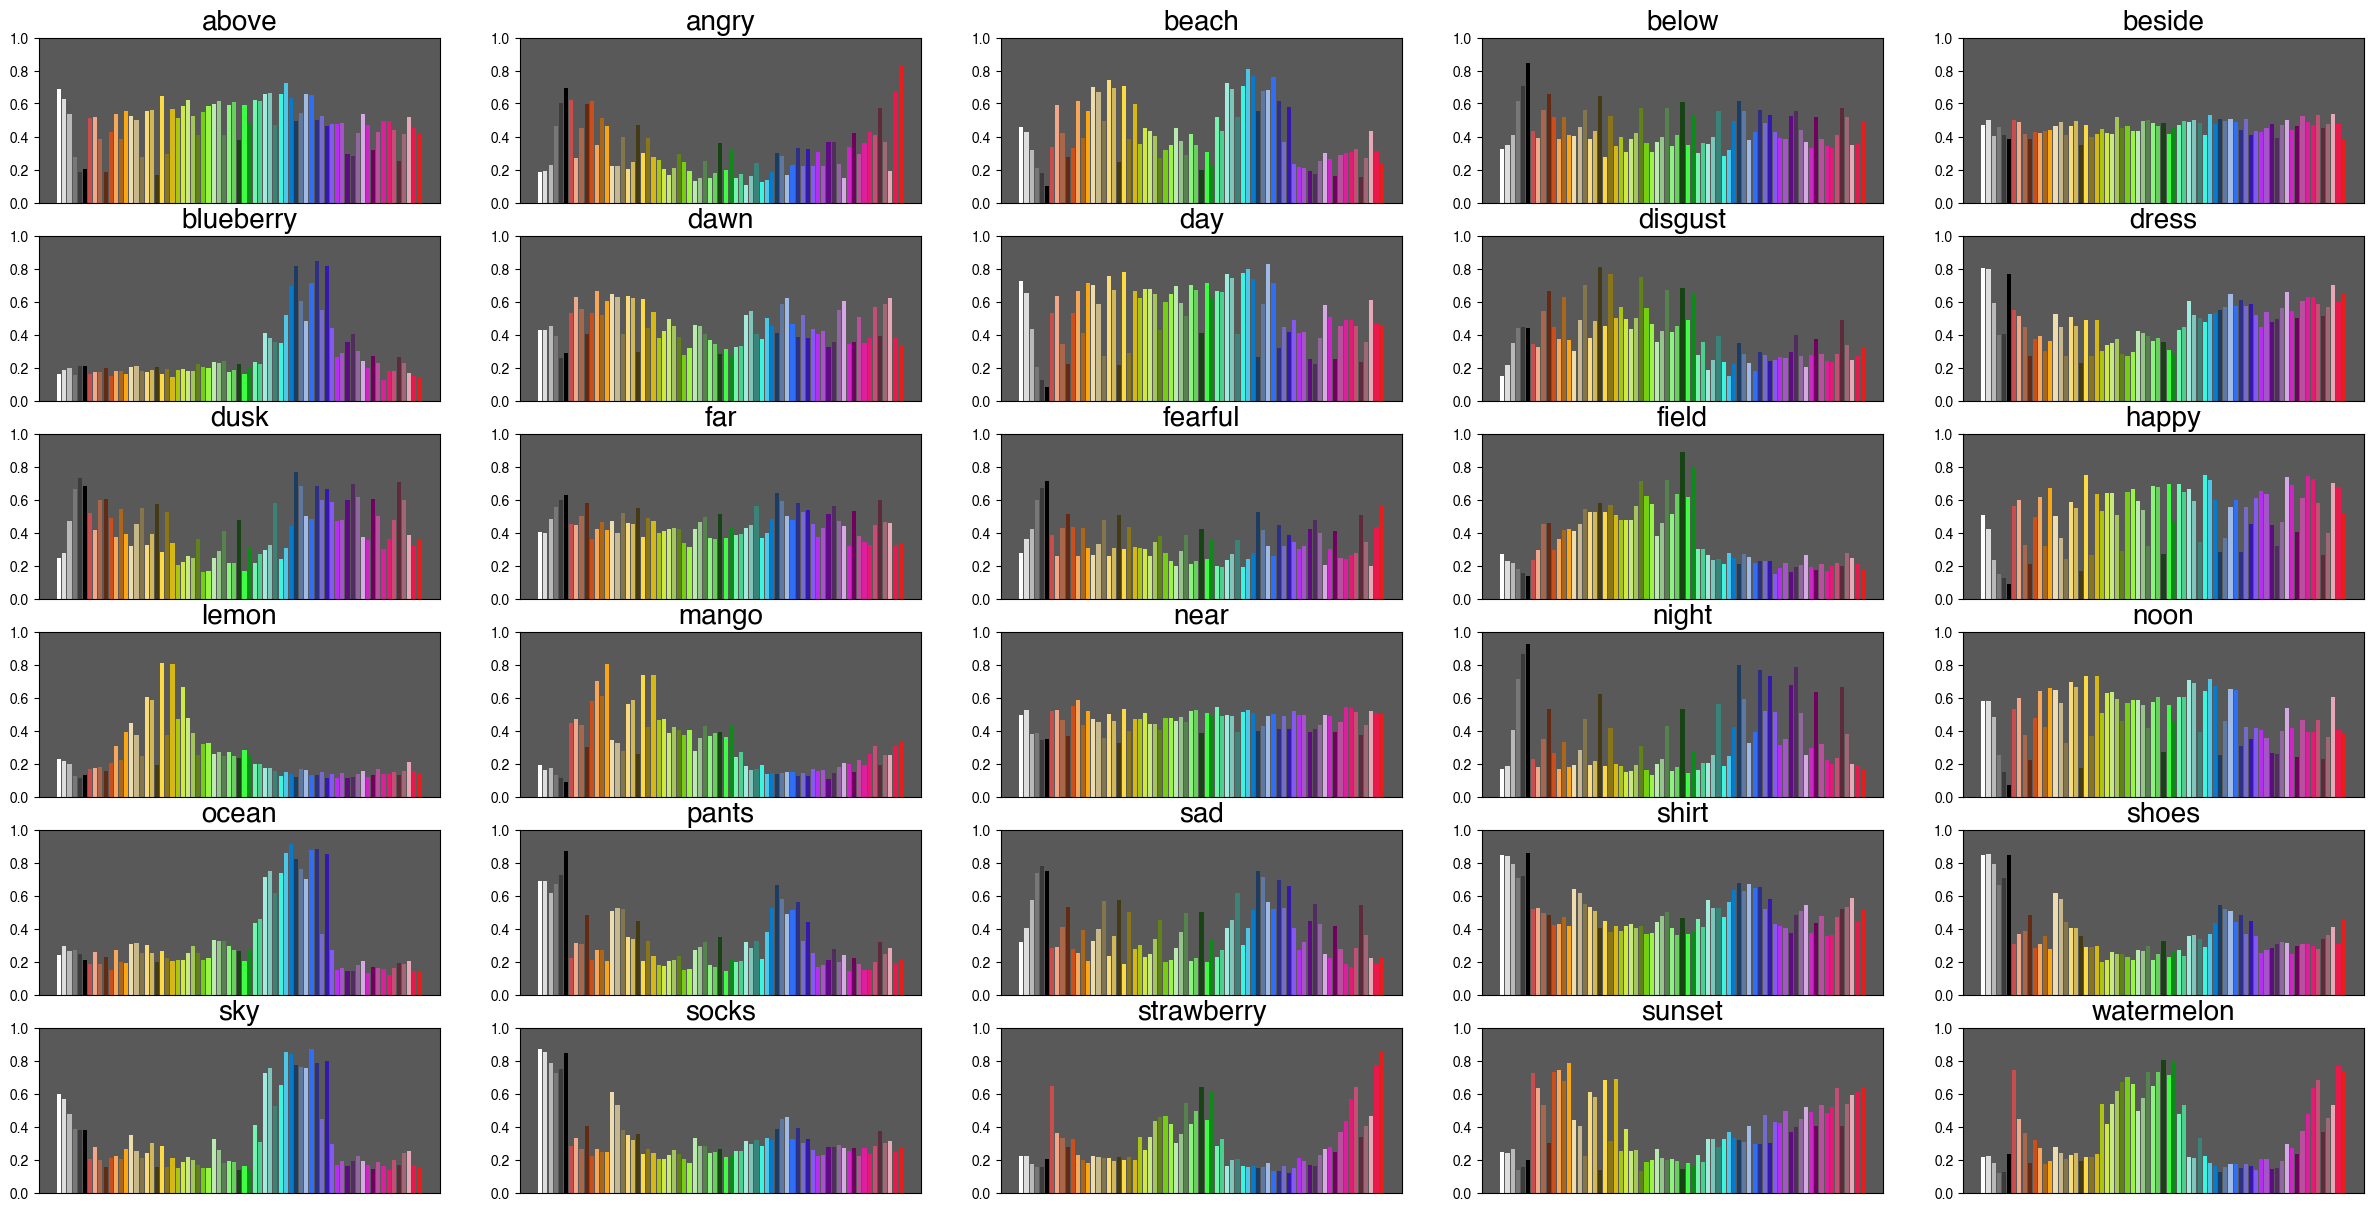

In [19]:
plot_mean_assocs(set1_grouped,'set1')

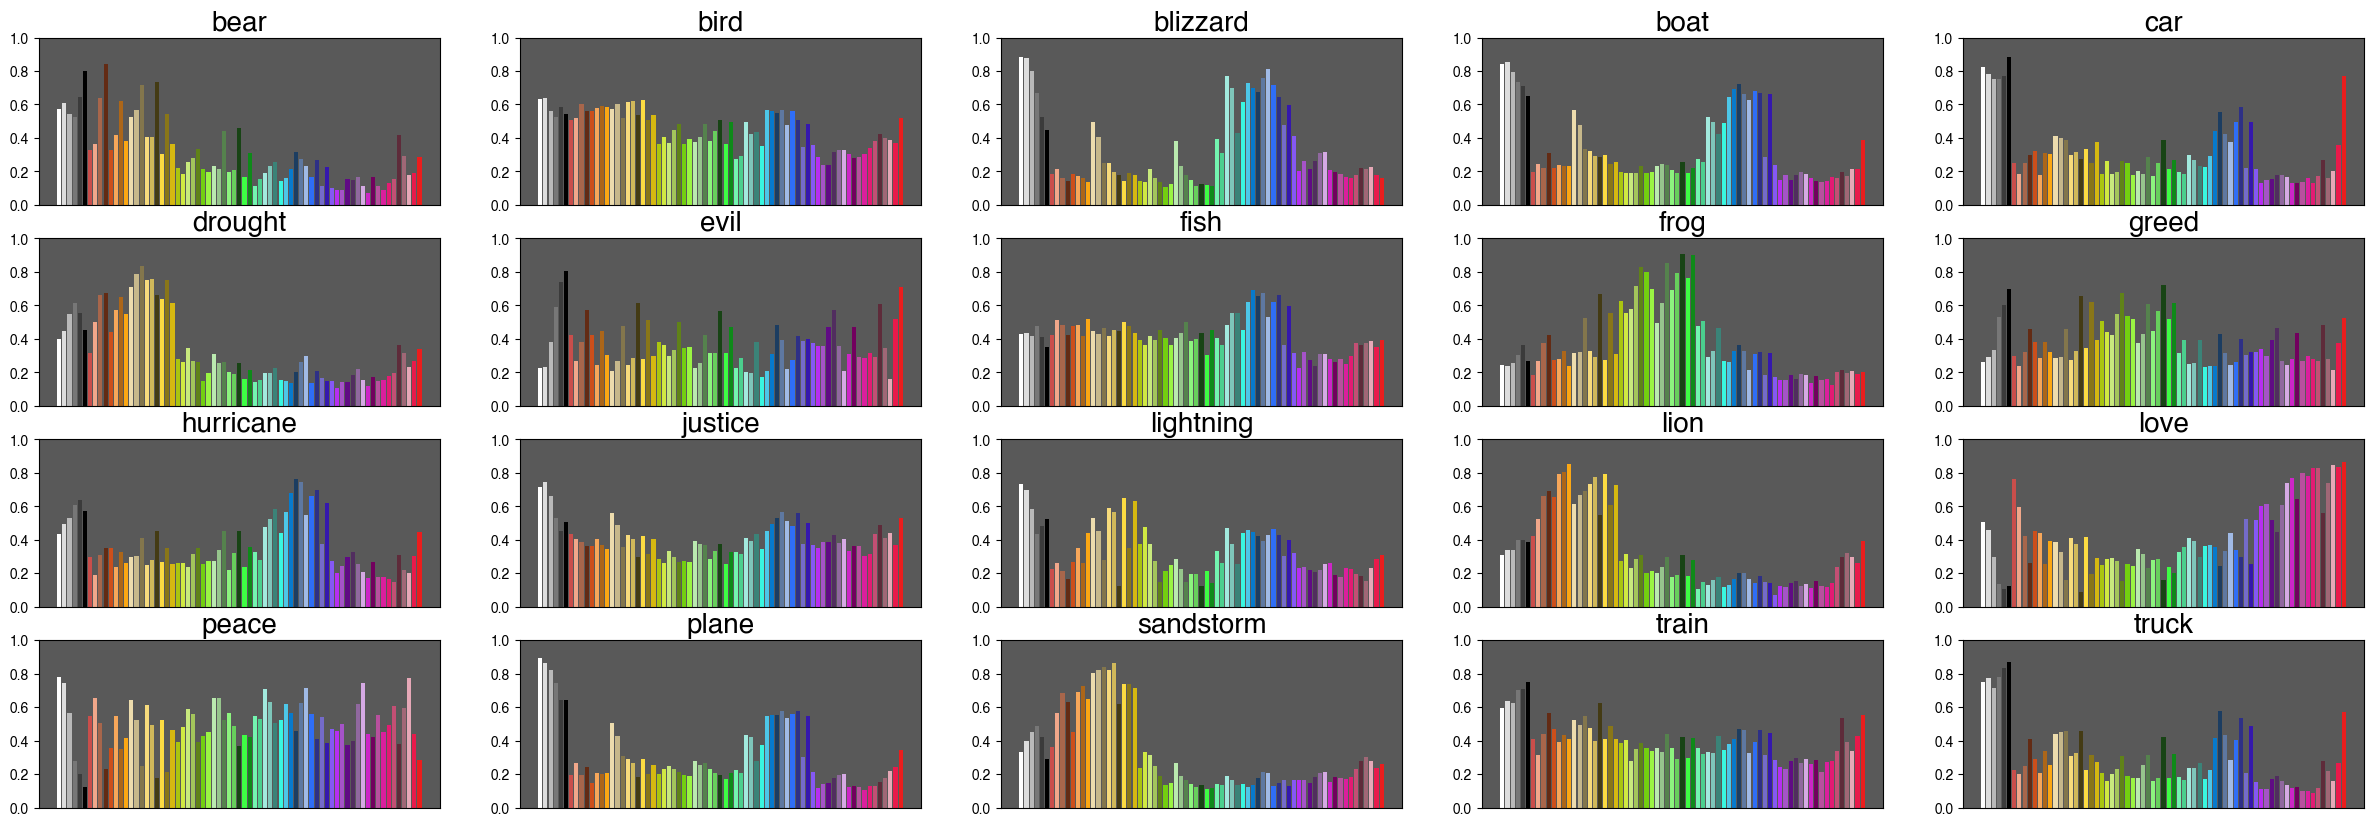

In [20]:
plot_mean_assocs(set2_grouped,'set2')

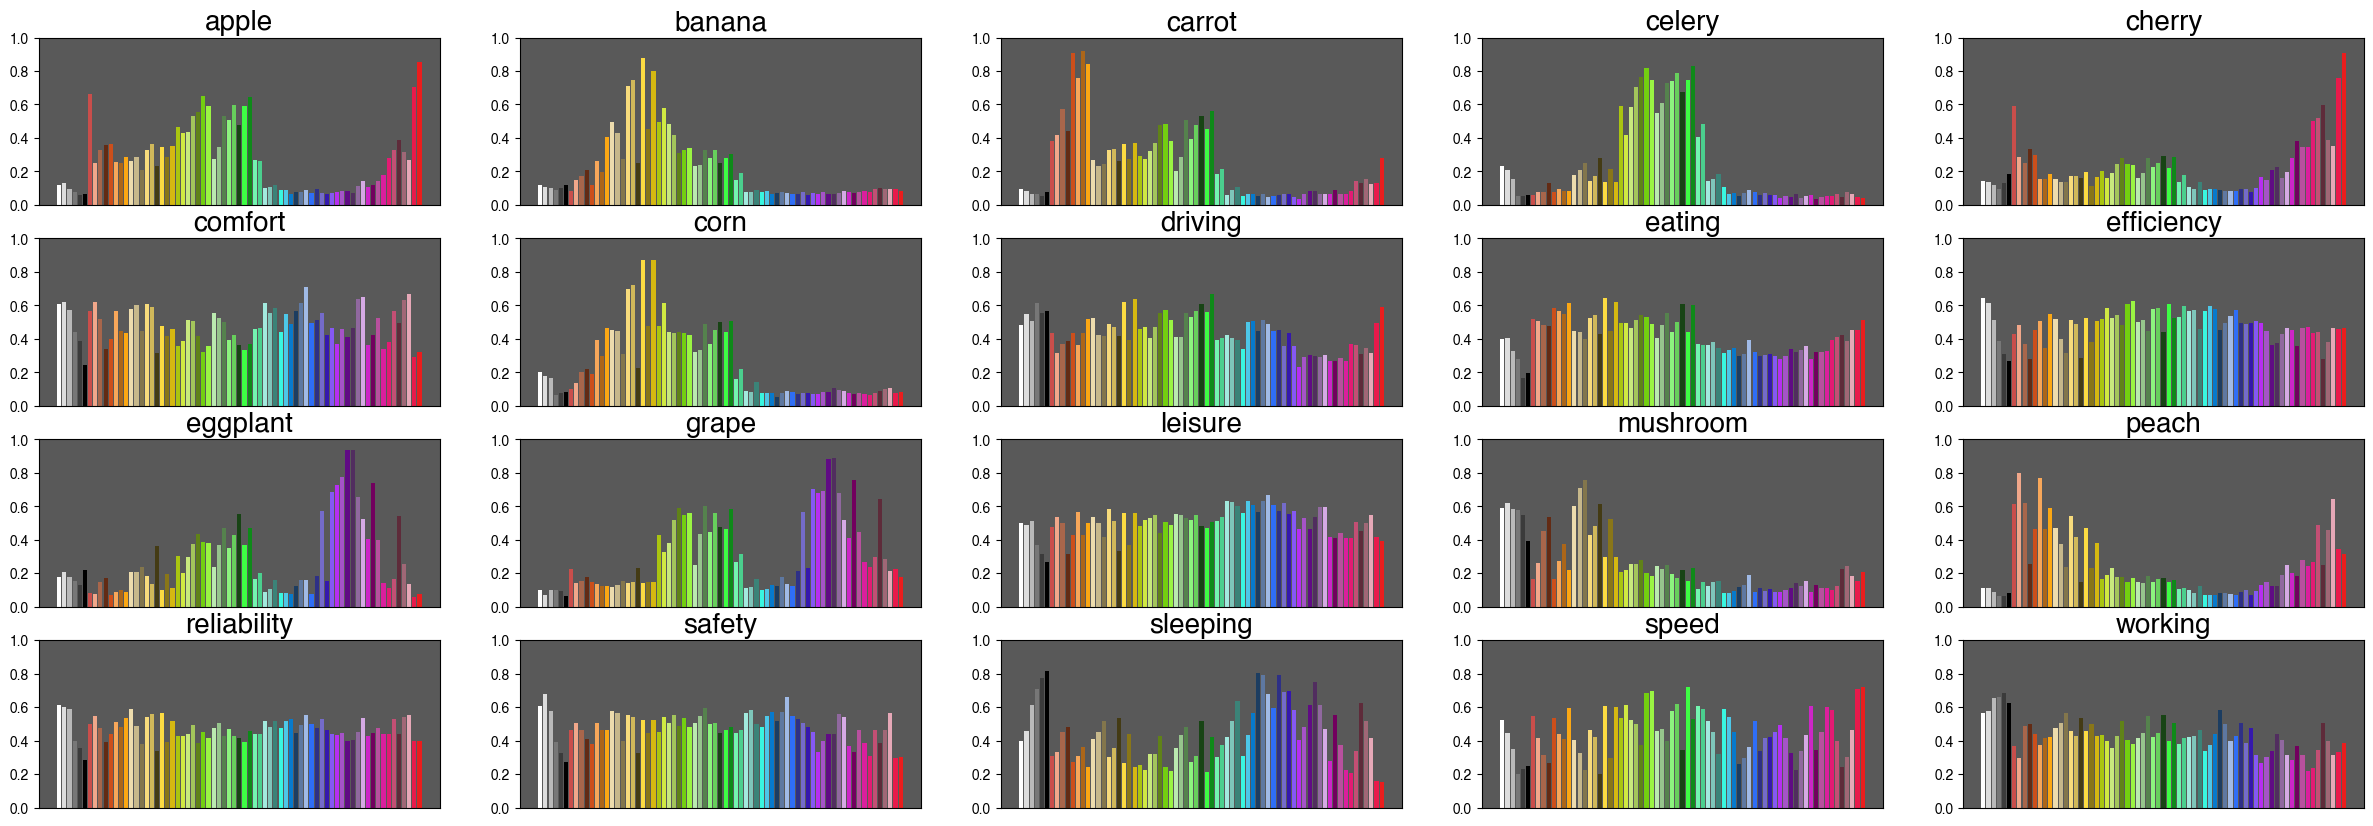

In [21]:
plot_mean_assocs(set3_grouped,'set3')

In [22]:
### make the ratings matrix for the 3 sets of associations
set1_mat,set1_cmeans= make_ratings_mat(set1_grouped)
set2_mat,set2_cmeans= make_ratings_mat(set2_grouped)
set3_mat,set3_cmeans= make_ratings_mat(set3_grouped)

In [23]:
all_ratings_mat = pd.concat([set1_mat,set2_mat,set3_mat], axis=0)
all_ratings_mat.to_csv('../../data/all_ratings_mat.csv')


### Compute an SVD over all the different datasets and save the results as csvs

In [24]:
U1,S1,Vh1 = svd((set1_mat -set1_cmeans), full_matrices=False)
factor_mat1= U1 @ np.diag(S1)
basis_vecs1 = Vh1
np.savetxt('../../data/basis_vecs_set1.csv', basis_vecs1.T, delimiter= ',')

U2,S2,Vh2 = svd((set2_mat -set2_cmeans), full_matrices=False)
factor_mat2= U2 @ np.diag(S2)
basis_vecs2 = Vh2
np.savetxt('../../data/basis_vecs_set2.csv', basis_vecs2.T, delimiter= ',')

U3,S3,Vh3 = svd((set3_mat -set3_cmeans), full_matrices=False)
factor_mat3= U3 @ np.diag(S3)
basis_vecs3 = Vh3
np.savetxt('../../data/basis_vecs_set3.csv', basis_vecs3.T, delimiter= ',')


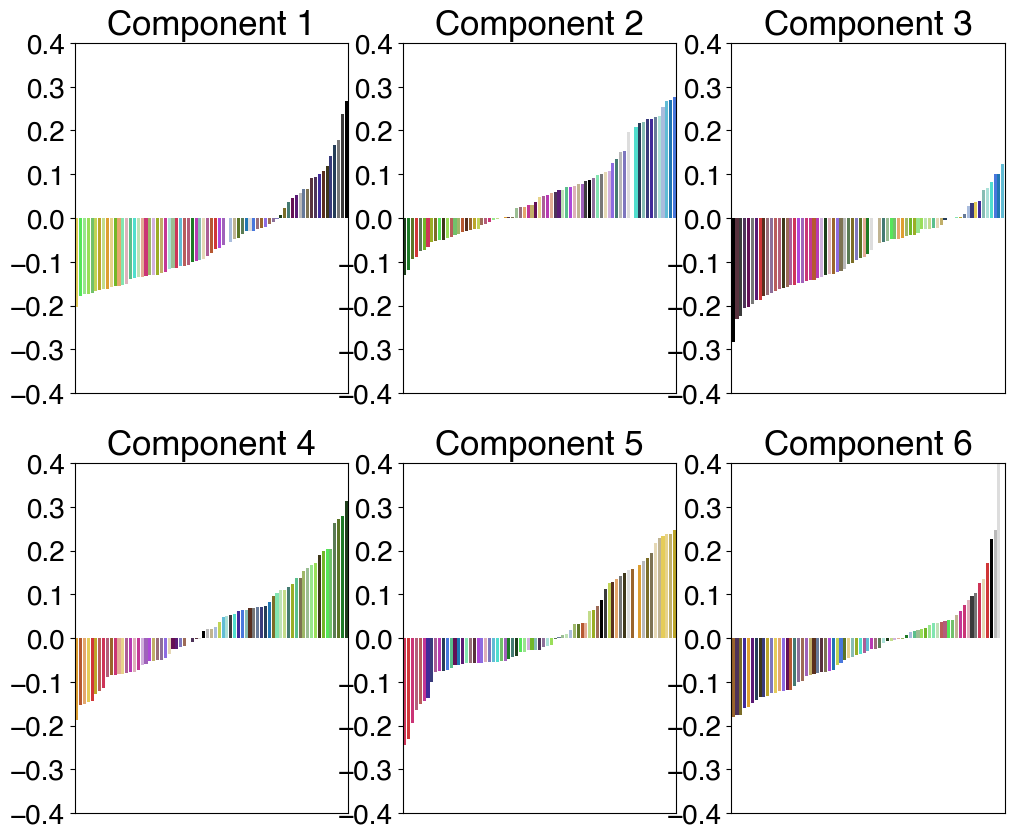

In [25]:
### Plot the first 6 components of set 1 of concepts (and save the plot)
plot_components(basis_vecs1,6,save=True,facet=True,fname='exp1_components')

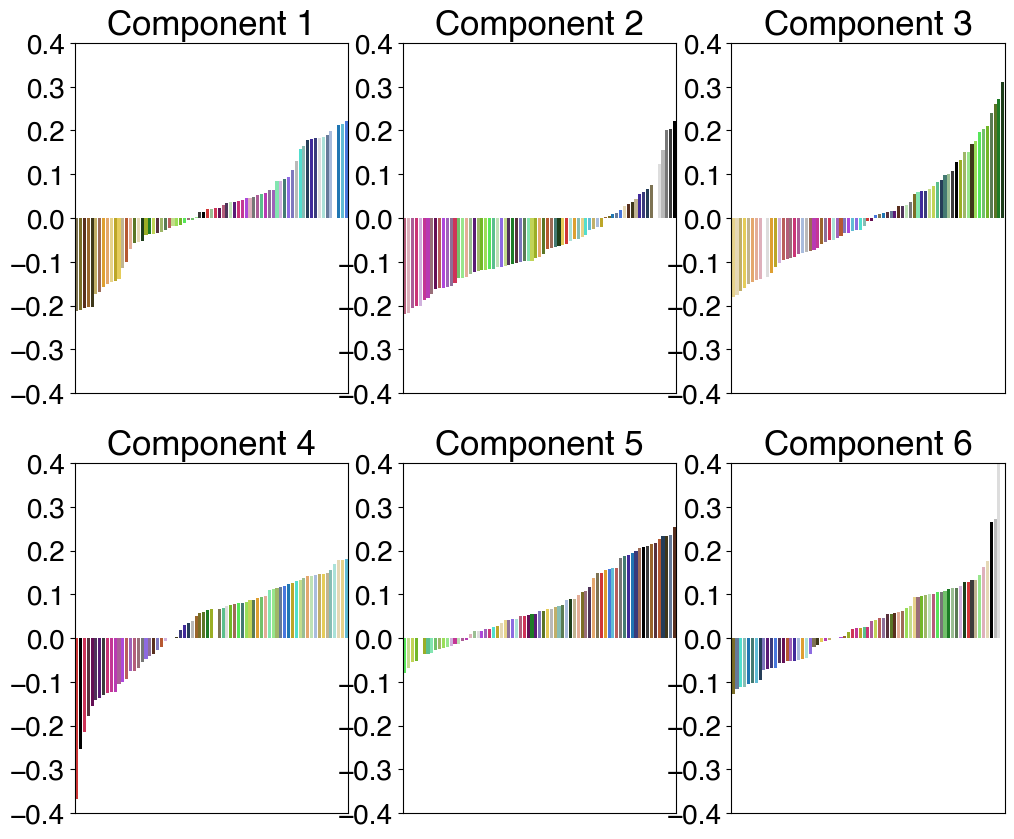

In [26]:
### Plot the first 6 components of set 2 of concepts
plot_components(basis_vecs2,6,save=False,facet=True)

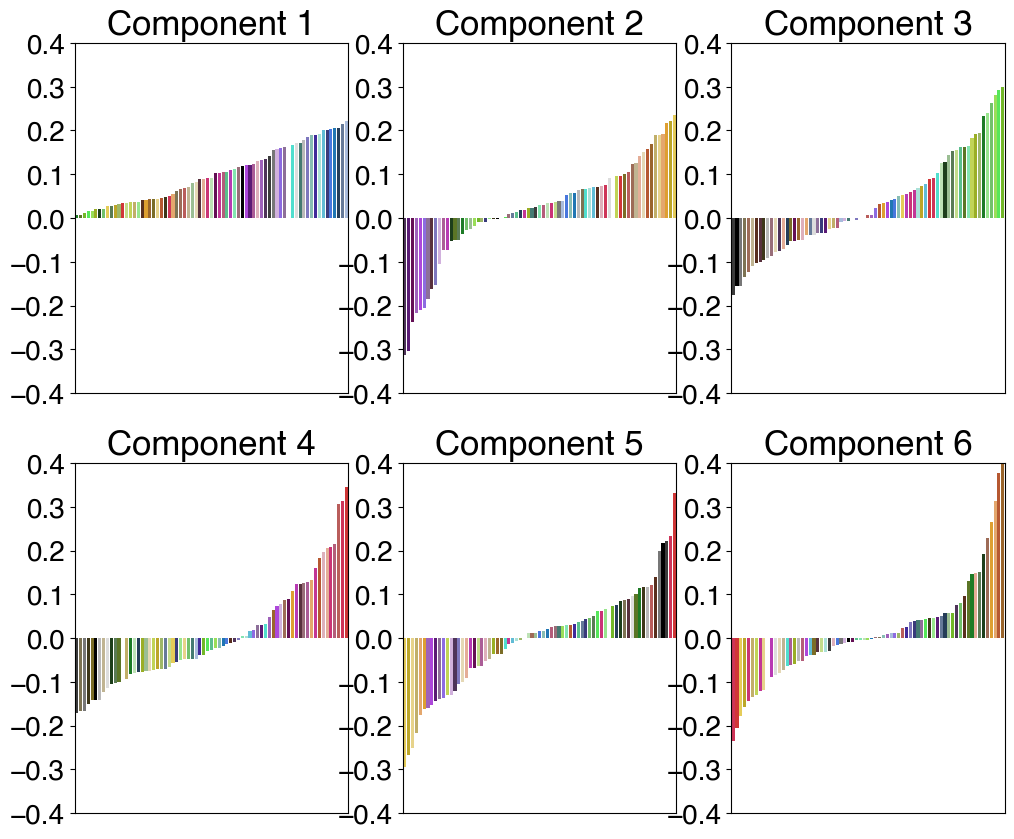

In [27]:
### Plot the first 6 components of set 3 of concepts
plot_components(basis_vecs3,6,save=False,facet=True)

### Check for low rank structure

In [28]:
### check for low rank structure by shuffling the original matrix and computing the svd
rng = np.random.default_rng()
test = set1_mat -set1_cmeans ### true ratings with columns centered
shuffle_test = set1_mat -set1_cmeans ### same as above
shuffle_test = rng.permuted(shuffle_test) ### permuted ratings
shuf_u, shuf_s, shuf_vt = svd(shuffle_test, full_matrices=False) ###svd of shuffled matrix
factor_mat_shuf = shuf_u@np.diag(shuf_s) ### left singular vectors scaled with singular values for shuffled matrix


In [29]:
n_comp = []
r =[] ## will hold reconstruction correlations for unshuffled matrix
r_shuf = [] ## will hold reconstruction correlations for shuffled matrix
for i in range(1,30): ### concept
    for j in range(1,30): ### ncomps
        r.append(pearsonr(np.matmul(factor_mat1[:,0:j+1],basis_vecs1[0:j+1,:])[i,],test.iloc[i,])[0])
        r_shuf.append(pearsonr(np.matmul(factor_mat_shuf[:,0:j+1],shuf_vt[0:j+1,:])[i,],shuffle_test[i,])[0])
        n_comp.append(j)
        
cor_df = pd.DataFrame({'n_comp':n_comp,'r':r,'r_shuf':r_shuf})


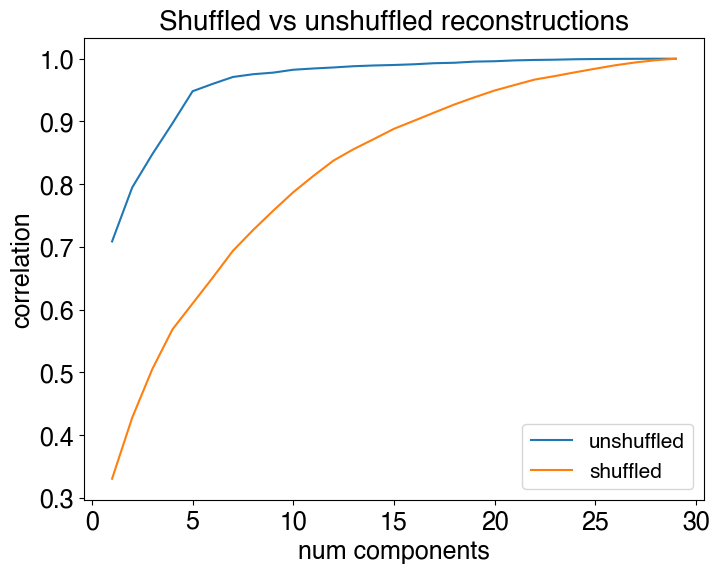

In [31]:
summary_cor_df = cor_df.groupby(n_comp).mean().reset_index()

plt.figure(figsize=(8,6))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.gca().spines[:].set_color('k')
plt.plot(np.arange(1,30),summary_cor_df.r.values,label='unshuffled')
plt.plot(np.arange(1,30),summary_cor_df.r_shuf.values,label='shuffled')
##
plt.xlabel('num components',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('correlation',fontsize=18)
plt.legend(fontsize=15)
plt.title('Shuffled vs unshuffled reconstructions',fontsize=20)
plt.savefig('../../data/recon_assocs/shuffled_vs_unshuffled.pdf',format ='pdf',bbox_inches='tight')



In [32]:
summary_cor_df.r.values

array([0.70867495, 0.79473057, 0.84779931, 0.89699178, 0.94814568,
       0.95992289, 0.97086739, 0.97527419, 0.97782508, 0.9824162 ,
       0.98441974, 0.98606892, 0.98804937, 0.98922233, 0.99002138,
       0.99113754, 0.99283312, 0.99356563, 0.99538658, 0.99599054,
       0.99732409, 0.99804208, 0.99846591, 0.99915596, 0.99953144,
       0.9997293 , 0.99987282, 1.        , 1.        ])

Flattens out at 6 dims so we should consider a 6 dimensional subspace

Now we use our colorimentric regression method to approximate the principal components and for each concept test how well we can predict its left singular vectors and reconstruct its association ratings as a function of the number of principal components we use.

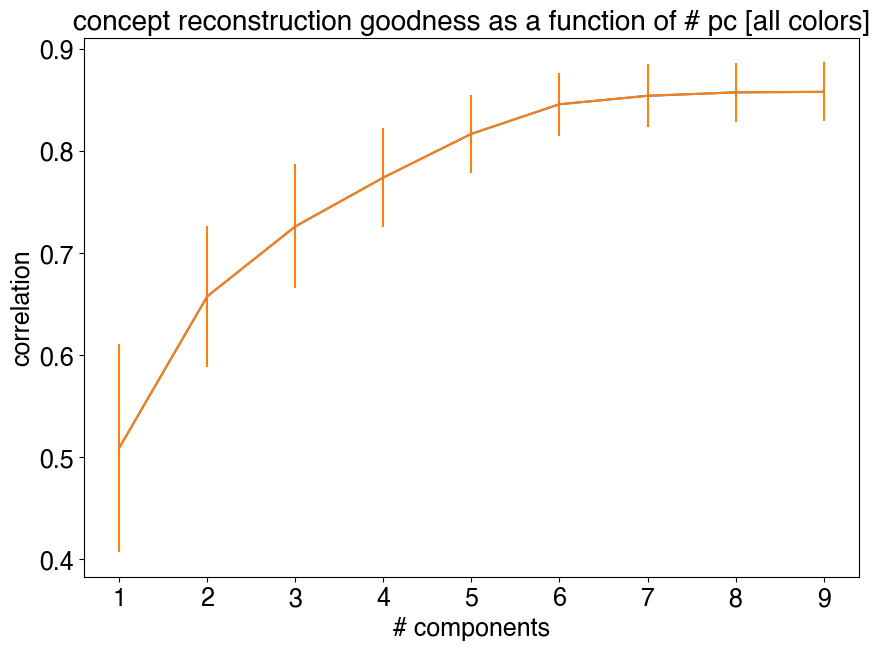

In [33]:
### estimate the factor matrix using linear regression and predict ratings for each concept
### all the color ratings as items in the regression

num_pcs =[]
approx_cors = [] ## hold correlations for reconstructions
cons = []
for num_pc in range(1,10):
    conc_prof_mat = np.zeros(shape=(30,num_pc)) ## this matrix holds the approximated factor matrix 
    _,approx_basis_vecs = colorimetric_reg(basis_vecs1.T[:,0:num_pc])
 
    for i in range(set1_mat.shape[0]): ## iterate through each concept

        concept_ratings = set1_mat.iloc[i,:]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-set1_cmeans
        reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[:,0:num_pc], concept_ratings)
        coords = reg.coef_[0:num_pc]   ## only use num_pc components
        conc_prof_mat[i,:] = coords
    
    
    approx_recon = conc_prof_mat@approx_basis_vecs.T
   
    for i in range(approx_recon.shape[0]):
        concept_ratings = set1_mat.iloc[i,:]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-set1_cmeans
        approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
        num_pcs.append(num_pc)
        cons.append(set1_mat.index[i])


concept_approx_df = pd.DataFrame(list(zip(cons,num_pcs,approx_cors)), columns = ['concept','num_pcs','correlation'])



# plot_ys = concept_approx_df.groupby('num_pcs').mean().reset_index().correlation
plot_ys = concept_approx_df.groupby('num_pcs')['correlation'].mean().values
# plot_err = concept_approx_df.groupby('num_pcs').std().reset_index().correlation/np.sqrt(30)*1.96
plot_err = concept_approx_df.groupby('num_pcs')['correlation'].std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.gca().spines[:].set_color('k')
plt.plot(np.arange(1,10),plot_ys)
plt.errorbar(x= np.arange(1,10),y = plot_ys,yerr=plot_err)
plt.title('concept reconstruction goodness as a function of # pc [all colors]',fontsize=20)
plt.xlabel('# components',fontsize=18)
plt.ylabel('correlation',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

In [ ]:
# ### save basis vectors from leaving out one color at a time
# for this_col in range(set1_mat.shape[1]):
#     ds = set1_mat.loc[:,set1_mat.columns!=this_col]
#     cmeans_s = np.delete(set1_cmeans, this_col)
#     ds = ds-cmeans_s
#     U,S,Vh = svd(ds, full_matrices=False)
#     np.savetxt(f'../../data/MATLAB_outputs/basis_vecs_set1_color_{this_col+1}.csv',Vh.T, delimiter= ',')
    


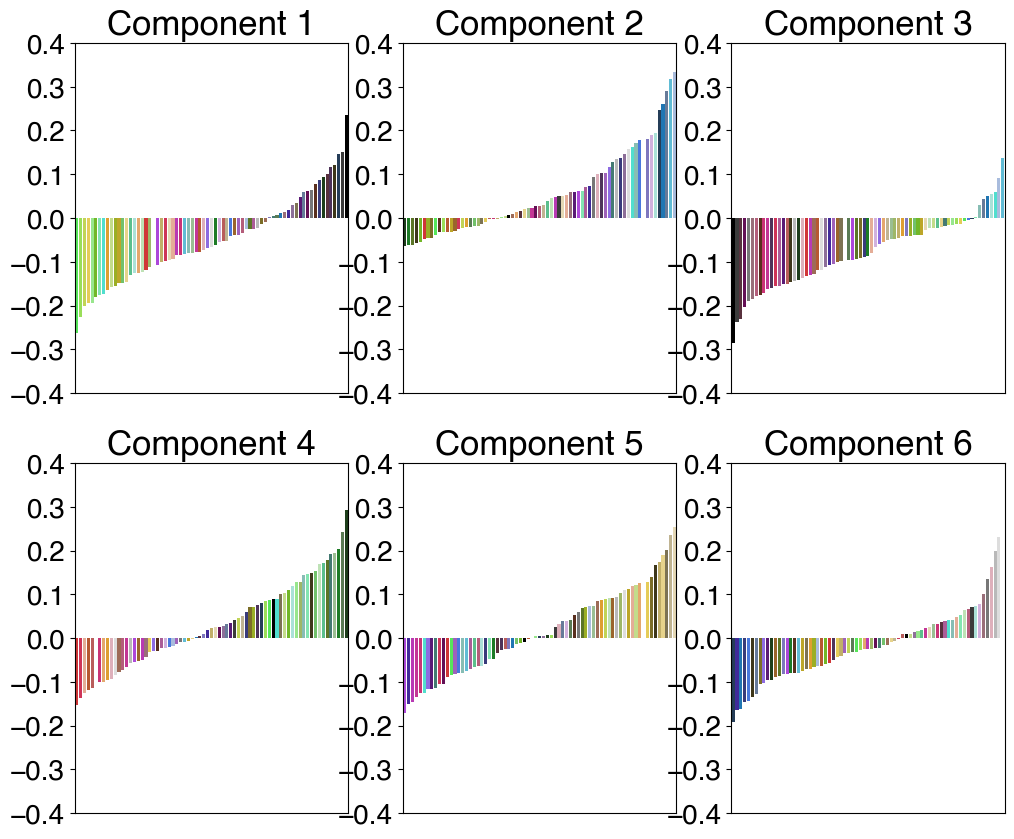

In [34]:
### Plot the predicted components for concept set 1
col_prof_cors = [] ## correlations between profiles predicted from colorimetric coordinates and right singular vectors
_,approx_basis_vecs1 = colorimetric_reg(basis_vecs1.T)
plot_components(approx_basis_vecs1.T,6,save=True,facet=True,fname='exp1_components_approx')


(71,)

component 1 R^2 = 0.8509917487831471
component 2 R^2 = 0.8466626207120035
component 3 R^2 = 0.8150157460596656
component 4 R^2 = 0.7462990730345306
component 5 R^2 = 0.7193612487305887
component 6 R^2 = 0.5524012993401546
component 7 R^2 = 0.684864745729827
component 8 R^2 = 0.24590644451717614
component 9 R^2 = 0.11315292175294413
component 10 R^2 = 0.07111584434207045
component 11 R^2 = 0.06334121665781024
component 12 R^2 = 0.02783569006697937
component 13 R^2 = 0.20622360489403388
component 14 R^2 = 0.09879171998133504
component 15 R^2 = 0.007375922210512231


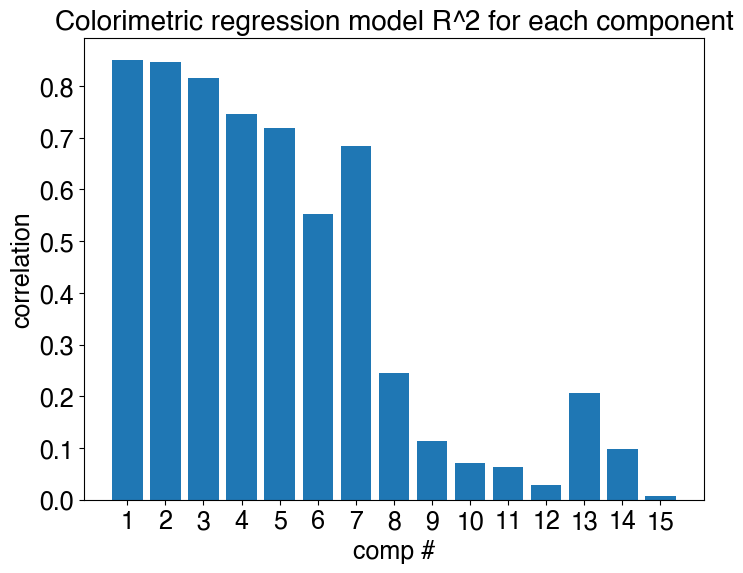

In [35]:
### check what the model R^2 values are for each component from the colorimetric regressions
col_prof_cors =[]
for i in range(15): 
    this_cor = np.corrcoef(approx_basis_vecs1.T[i,:],basis_vecs1[i,:])[0][1]
    print(f'component {i+1} R^2 = {this_cor**2}')
    col_prof_cors.append(this_cor)

fig = plt.figure(figsize=(8,6))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.gca().spines[:].set_color('k')
plt.bar(np.arange(1,16),[x**2 for x in col_prof_cors])
plt.title('Colorimetric regression model R^2 for each component', fontsize=20)
plt.xlabel('comp #',fontsize=18)
plt.xticks(range(1,16))
plt.ylabel('correlation',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('../../data/recon_assocs/colorimetric_reg_R2.pdf',format='pdf',bbox_inches='tight')
plt.show()


The colorimetric models can predict the first 7 components quite well, since we expect a 6 dimensional space to do well based on our shuffling approach, we will consider the first 6

Now we want to test how well we can reconstruct the concept ratings for each color as a function of the number of principal components we use.

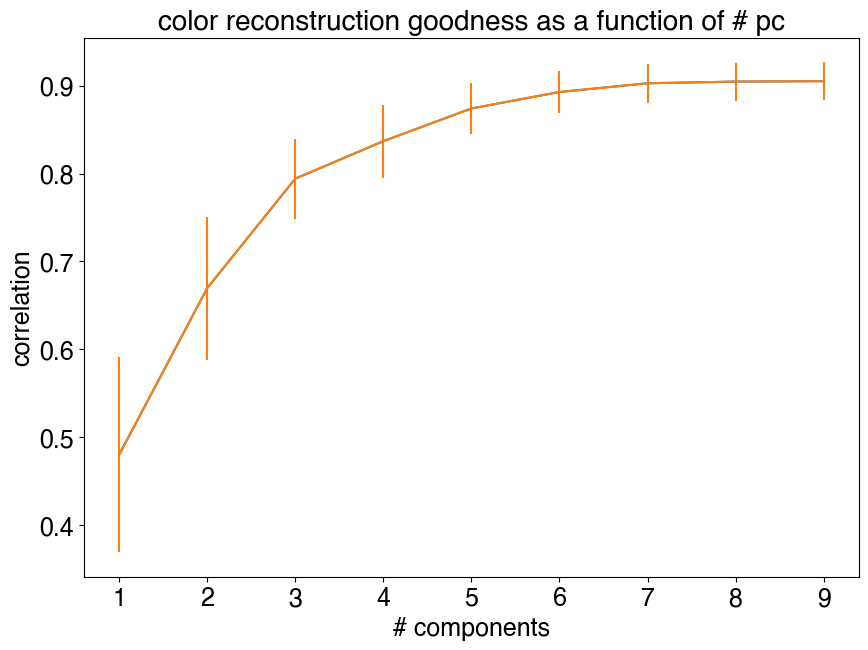

In [36]:
num_pcs =[]
cors = []
col_num = []
for num_pc in range(1,10):
    _,approx_basis_vecs1 = colorimetric_reg(basis_vecs1.T)
    recon = (factor_mat1[:,:(num_pc)]@approx_basis_vecs1.T[:(num_pc),:])
    recon = recon+set1_cmeans
 
    for i in range(71):
        cors.append(np.corrcoef(recon[:,i], (set1_mat).iloc[:,i])[0,1])
        num_pcs.append(num_pc+1)
        col_num.append(i)


color_approx_df = pd.DataFrame(list(zip(col_num,num_pcs,cors)),columns= ['color','num_pcs','correlation'])
# plot_ys = color_approx_df.groupby('num_pcs').mean().reset_index().correlation
plot_ys = color_approx_df.groupby('num_pcs')['correlation'].mean().values
# plot_err = color_approx_df.groupby('num_pcs').std().reset_index().correlation/np.sqrt(30)*1.96
plot_err = color_approx_df.groupby('num_pcs')['correlation'].std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.gca().spines[:].set_color('k')
plt.plot(np.arange(1,10),plot_ys)
plt.errorbar(x= np.arange(1,10),y = plot_ys,yerr=plot_err)
plt.title('color reconstruction goodness as a function of # pc',fontsize=20)
plt.xlabel('# components',fontsize=18)
plt.ylabel('correlation',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

## Testing performance in predicting holdout colors

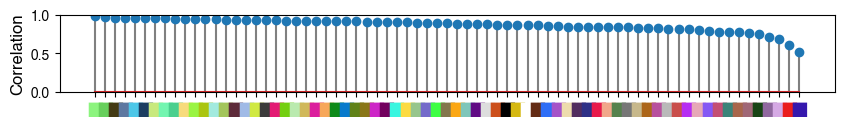

In [37]:
cors = []
pvals = []
for i in range(0,71):
    ratings_sub = set1_mat.iloc[:,i] ## selecting column of holdout color
    ratings_sub_inv = set1_mat.loc[:,set1_mat.columns!=i] ## select all other columns
    set1_cmeans_sub_inv = np.delete(set1_cmeans,i) ## means of all other columns
    U,S,Vh = svd((ratings_sub_inv-set1_cmeans_sub_inv), full_matrices= False) ## svd of matrix without holdout color
    this_conc_prof_mat = (U@np.diag(S))[:,:6]
    weights,_ =  colorimetric_reg(Vh.T,exclude_regressor=i)
    
    recon = this_conc_prof_mat@(weights[0:6,:]@uw71regressors)

    # cors.append(np.corrcoef(recon[:,i],ratings_sub.values)[0,1])
    cors.append(pearsonr(recon[:,i],ratings_sub.values)[0])
    pvals.append(pearsonr(recon[:,i],ratings_sub.values)[1])

    
colcors = pd.DataFrame(list(zip(list(range(1,72)),cors,pvals)), columns = ['color','holdout_correlation','pval'])
colcors = pd.concat([colcors, uw71rgb], axis=1)
colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)




#colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,1))
# sns.barplot(x=colcors.index, y=colcors.holdout_correlation, edgecolor = 'black', color='gray')
plt.stem(colcors.index.values, colcors.holdout_correlation.values, markerfmt='o',linefmt='gray')

#plt.axis('off')
#plt.xticks([])
#plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=10)
plt.ylabel('Correlation', fontsize=12)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
symbolsx = [u"■"]*colcors.shape[0]
ax.set_xticks(range(len(symbolsx)))
ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=15)
for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors['r_rgb'],colcors['g_rgb'],colcors['b_rgb'])))):
    tick.set_color(color)

# plt.title('Concept Set 1 Color Holdout Correlations')
plt.savefig('../../data/recon_assocs/holdout_correlations_set1.pdf',format ='pdf',bbox_inches='tight')
plt.show()

    



In [38]:
print(f' mean correlation = {colcors.holdout_correlation.mean()}')
print(f' sd correlation = {colcors.holdout_correlation.std()}')
print(f' max correlation = {colcors.holdout_correlation.max()}')
print(f' min correlation = {colcors.holdout_correlation.min()}')

 mean correlation = 0.8676756133066658
 sd correlation = 0.08296121416904242
 max correlation = 0.9750536940293074
 min correlation = 0.510304356310498


In [39]:
colcors['pval'] = colcors['pval'].astype(float)
colcors['pval_corrected'] = multipletests(colcors['pval'],method='holm')[1]
colcors['sig'] = colcors['pval_corrected']<.05
colcors

color  holdout_correlation          pval     r_rgb     g_rgb     b_rgb  \
0      53             0.975054  7.601522e-20  0.549890  0.958520  0.495720   
1      52             0.970790  6.742594e-19  0.402220  0.811940  0.361440   
2      42             0.959627  5.846366e-17  0.268590  0.230990  0.078708   
3      13             0.956835  1.465342e-16  0.366760  0.471510  0.631640   
4      11             0.954512  3.008633e-16  0.302940  0.780570  0.909830   
..    ...                  ...           ...       ...       ...       ...   
66     38             0.750562  1.780133e-06  0.093053  0.267870  0.081612   
67     16             0.712725  9.914385e-06  0.565830  0.408700  0.625220   
68     17             0.682420  3.266742e-05  0.834930  0.664230  0.895970   
69     63             0.609425  3.506846e-04  0.916830  0.112580  0.115590   
70      2             0.510304  3.962751e-03  0.208780  0.093277  0.677550   

    pval_corrected   sig  
0     5.397081e-18  True  
1     4.719816e-17  True  
2     4.033992e-15  True  
3     9.964329e-15  True  
4     2.015784e-14  True  
..             ...   ...  
66    8.900667e-06  True  
67    3.965754e-05  True  
68    9.800225e-05  True  
69    7.013693e-04  True  
70    3.962751e-03  True  

[71 rows x 8 columns]

### Holdout colors for concept sets 2 and 3

In [ ]:
# cors = []
# for i in range(0,71):
#     ratings_sub = set2_mat.iloc[:,i] ## selecting column of holdout color
#     ratings_sub_inv = set2_mat.loc[:,set2_mat.columns!=i] ## select all other columns
#     set2_cmeans_sub_inv = np.delete(set2_cmeans,i) ## means of all other columns
#     U,S,Vh = svd((ratings_sub_inv-set2_cmeans_sub_inv), full_matrices= False) ## svd of matrix without holdout color
#     this_conc_prof_mat = (U@np.diag(S))[:,:6]
#     weights,_ =  colorimetric_reg(Vh.T,exclude_regressor=i)

    
    
#     #this_prof_coef_mat = pd.read_csv(f'../../data/MATLAB_outputs/10_regression_weights_color_{i+1}.csv', header=None).to_numpy()[:,:6]
    
#     recon = this_conc_prof_mat@(weights[0:6,:]@uw71regressors)
    
#     #recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+set1_cmeans.reshape(71,1)
# #     recon_ = this_conc_prof_mat@(weights.T[0:6,:]@uw71regressors) 

#     cors.append(np.corrcoef(recon[:,i],ratings_sub.values)[0,1])
    
# colcors = pd.DataFrame(list(zip(list(range(1,72)),cors)), columns = ['color','holdout_correlation'])
# colcors = pd.concat([colcors, uw71rgb], axis=1)
# colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)





# import matplotlib.font_manager as mfm

# font_path = 'FreeSerif.ttf'
# prop = mfm.FontProperties(fname=font_path)


# #colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
# fig = plt.figure(figsize=(15,10))
# sns.barplot(x=colcors.index, y=colcors.holdout_correlation, edgecolor = 'black', color='gray')
# #plt.axis('off')
# #plt.xticks([])
# #plt.xticks(rotation = 90, fontsize= 16)
# plt.xlabel('')
# plt.yticks(fontsize=18)
# plt.ylabel('Correlation', fontsize=20)
# plt.ylim(0,1)
# ax = plt.gca()
# #ax.set_facecolor((0.3497,0.3497,0.3497))
# ax.set_facecolor((1,1,1))
# symbolsx = [u"■"]*colcors.shape[0]
# ax.set_xticks(range(len(symbolsx)))
# ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
# for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors['r_rgb'],colcors['g_rgb'],colcors['b_rgb'])))):
#     tick.set_color(color)

# #plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
# plt.title('Concept Set 2 Color Holdout Correlations')
# plt.savefig('../../data/recon_assocs/holdout_correlations_set2.pdf',format ='pdf',bbox_inches='tight')
# plt.show()

    



In [ ]:
# cors = []
# for i in range(0,71):
#     ratings_sub = set3_mat.iloc[:,i] ## selecting column of holdout color
#     ratings_sub_inv = set3_mat.loc[:,set3_mat.columns!=i] ## select all other columns
#     set3_cmeans_sub_inv = np.delete(set3_cmeans,i) ## means of all other columns
#     U,S,Vh = svd((ratings_sub_inv-set3_cmeans_sub_inv), full_matrices= False) ## svd of matrix without holdout color
#     this_conc_prof_mat = (U@np.diag(S))[:,:6]
#     weights,_ =  colorimetric_reg(Vh.T,exclude_regressor=i)

    
    
#     #this_prof_coef_mat = pd.read_csv(f'../../data/MATLAB_outputs/10_regression_weights_color_{i+1}.csv', header=None).to_numpy()[:,:6]
    
#     recon = this_conc_prof_mat@(weights[0:6,:]@uw71regressors)
#     #recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+set1_cmeans.reshape(71,1)
# #     recon_ = this_conc_prof_mat@(weights.T[0:6,:]@uw71regressors) 

#     cors.append(np.corrcoef(recon[:,i],ratings_sub.values)[0,1])
    
# colcors = pd.DataFrame(list(zip(list(range(1,72)),cors)), columns = ['color','holdout_correlation'])
# colcors = pd.concat([colcors, uw71rgb], axis=1)
# colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)





# import matplotlib.font_manager as mfm

# font_path = 'FreeSerif.ttf'
# prop = mfm.FontProperties(fname=font_path)


# #colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
# fig = plt.figure(figsize=(15,10))
# # sns.barplot(x=colcors.index, y=colcors.holdout_correlation, edgecolor = 'black', color='gray')
# plt.stem(colcors.index,colcors.holdout_correlation)
# #plt.axis('off')
# #plt.xticks([])
# #plt.xticks(rotation = 90, fontsize= 16)
# plt.xlabel('')
# plt.yticks(fontsize=18)
# plt.ylabel('Correlation', fontsize=20)
# plt.ylim(0,1)
# ax = plt.gca()
# #ax.set_facecolor((0.3497,0.3497,0.3497))
# ax.set_facecolor((1,1,1))
# symbolsx = [u"■"]*colcors.shape[0]
# ax.set_xticks(range(len(symbolsx)))
# ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
# for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors['r_rgb'],colcors['g_rgb'],colcors['b_rgb'])))):
#     tick.set_color(color)

# plt.title('Concept Set 3 Color Holdout Correlations')
# # plt.savefig('../../data/recon_assocs/holdout_correlations_set3.pdf',format ='pdf',bbox_inches='tight')
# plt.show()

    



### Choosing optimal number of colors for predicting concept associations

Here the goal is to find the smallest number of colors that we can use to situate a new concept in the semantic space. Our metric of interest will be correlation between the predicted and actual concept ratings.

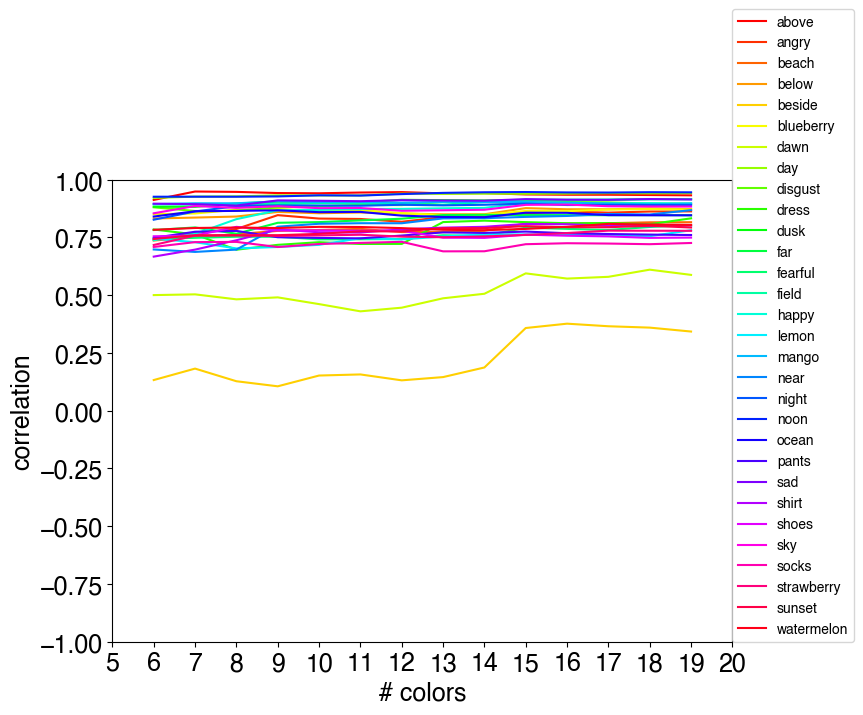

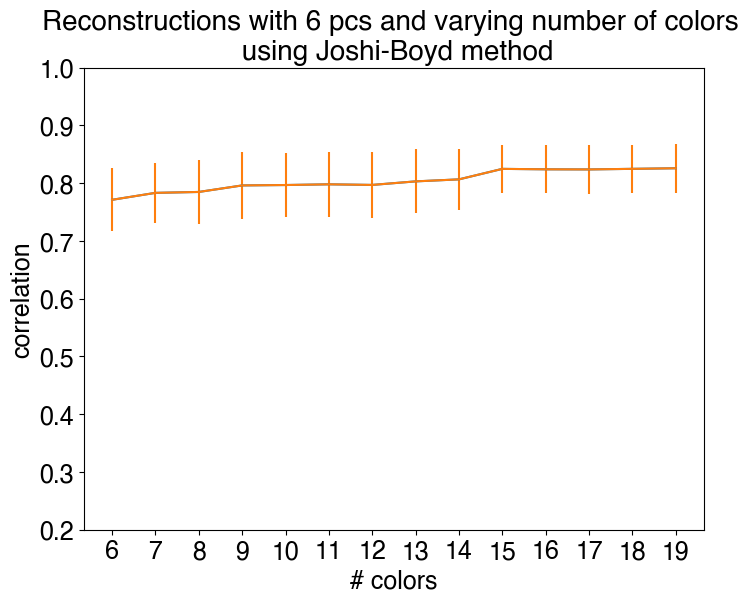

In [177]:
d =vary_colors_jb(set1_mat,set1_cmeans,basis_vecs1,num_pc=6)
plot_ys_jb = d.groupby('num_cols')['correlation'].mean().values
plot_err_jb = d.groupby('num_cols')['correlation'].std().values/np.sqrt(30)*1.96
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(6,20,1),plot_ys_jb)
plt.errorbar(x= np.arange(6,20,1),y = plot_ys_jb,yerr=plot_err_jb)
plt.title('Reconstructions with 6 pcs and varying number of colors \n using Joshi-Boyd method',fontsize=20)
plt.xlabel('# colors',fontsize=18)
plt.xticks(np.arange(6,20,1),fontsize=18)
plt.ylim(.2,1)
plt.yticks(fontsize=18)
plt.ylabel('correlation',fontsize=18)
plt.show()

#### How does the effect of varying color change as a function of dimensionality

Sample between a range of dimensionalities to see the effect of the number of colors on the correlation between the predicted and actual concept ratings.

In [ ]:
really_run=False ## Make sure to set this to true
if really_run==True:
    
    for this_num in range(4,9):
        print(f'Using a {this_num} dimensional space')
        _=vary_colors_jb(set1_mat,set1_cmeans,basis_vecs1,num_pc=this_num)

In [ ]:
return_rows(set1_mat-set1_cmeans,6)

The optimal set of colors from set 1 is [11, 14, 24, 37, 43, 44, 62, 68]: They look like this:

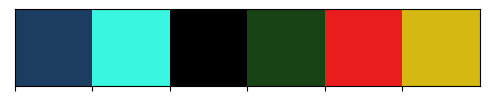

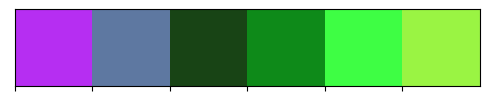

In [178]:
# sns.palplot(uw71coords[uw71coords['color_index'].isin([11, 14, 24, 37, 43, 44, 62, 68])].color_hex.values)
### Revised 8 cols from set 1:11, 20, 24, 37, 62, 68
sns.palplot(uw71coords[uw71coords['color_index'].isin([11, 20, 24, 37, 62, 68])].color_hex.values)
### Looking ahead: Revised 8 cols from set all:
sns.palplot(uw71coords[uw71coords['color_index'].isin([3, 12, 37, 50, 63, 65])].color_hex.values)


## Plotting reconstructions

Using 6 dimensions and 6 colors via leave-one-out for each concept used to fit the space then using the 6 components computed from the entirety of set 1 to generalize to the other 2 datasets

30it [00:00, 35.94it/s]


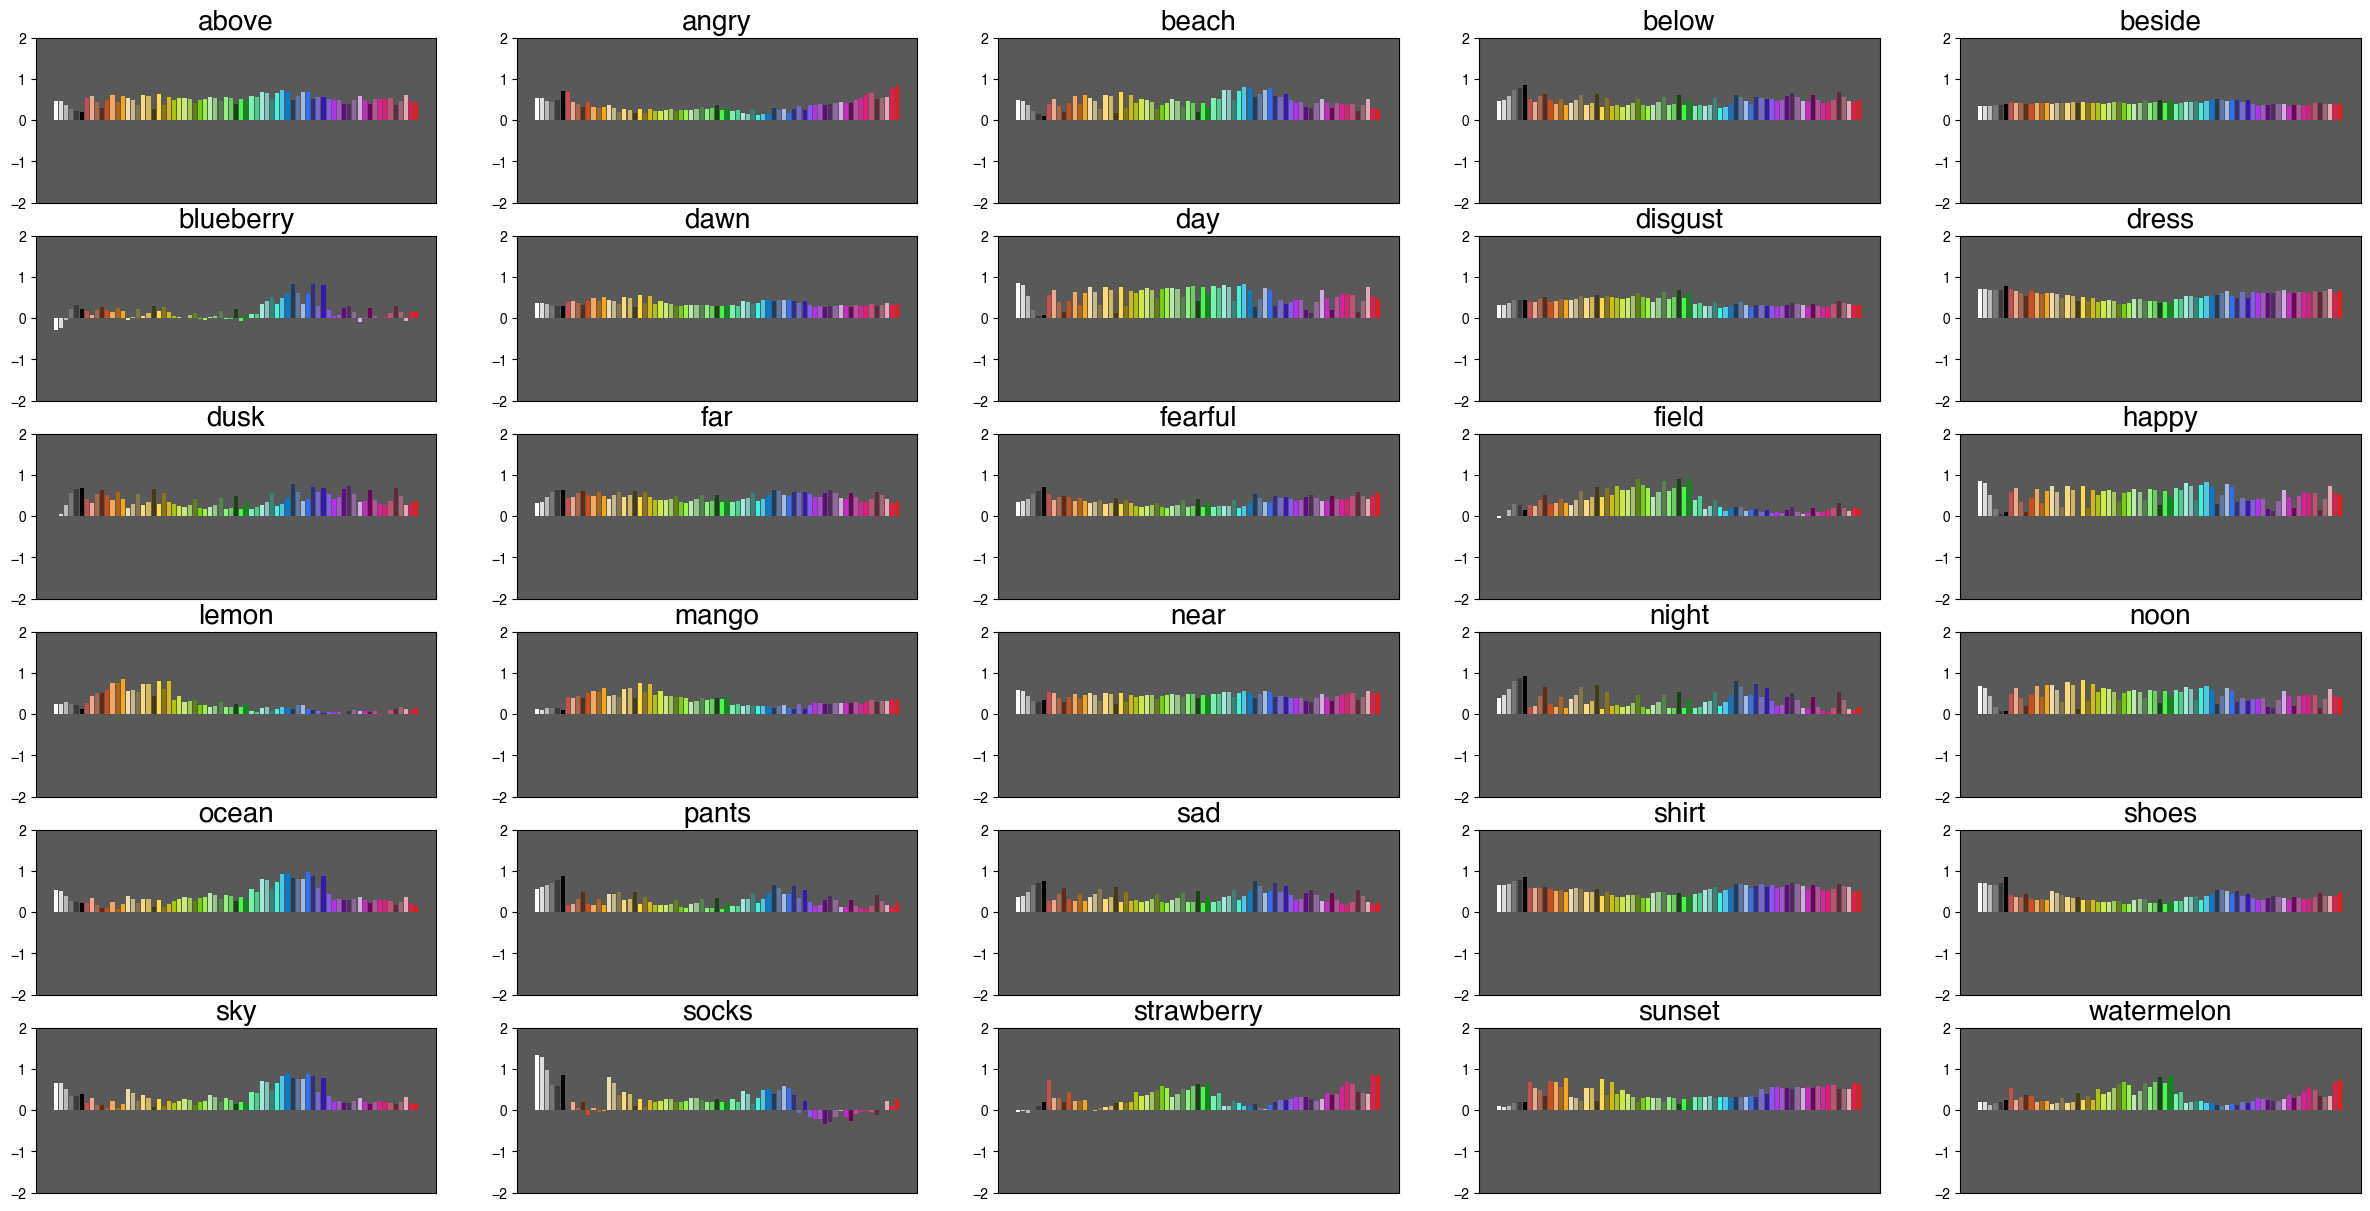

average reconstruction correlation: 0.8027585741241612


In [82]:
set1_mean_cors, set1_recon_ratings = reconstruct_assocs(set1_mat,set1_cmeans,'set1',num_pc=6,holdout_mode=True,compute_col_inds=6)
print('average reconstruction correlation:',set1_mean_cors.holdout_cor.mean())

In [83]:
set1_mean_cors['pvals'] = set1_mean_cors['pvals'].astype(float)
set1_mean_cors['pvals_corrected'] = multipletests(set1_mean_cors['pvals'],method='holm')[1]
set1_mean_cors['sig'] = set1_mean_cors['pvals_corrected']<.05

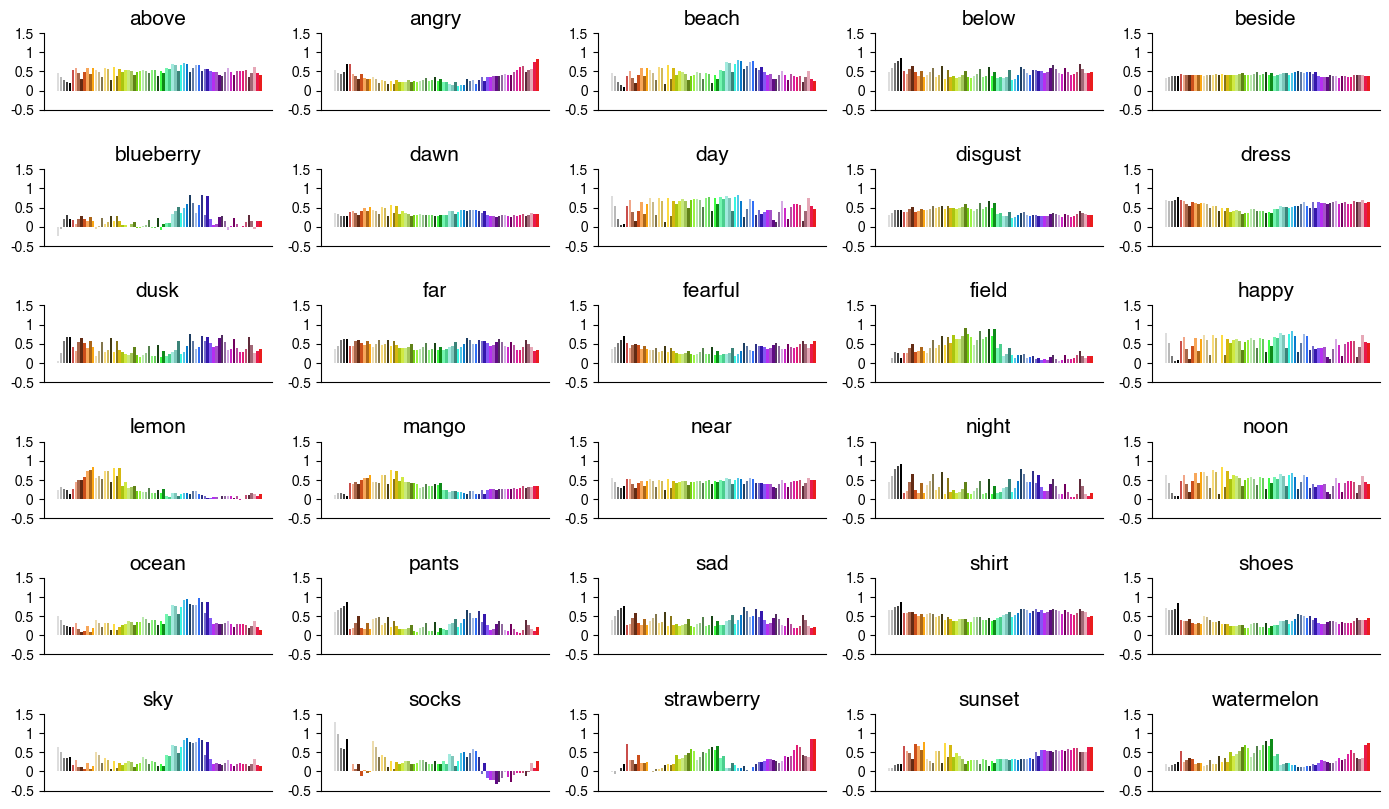

In [ ]:
set1_recon_wide = set1_recon_ratings.pivot(index='concept', columns='color_index', values='recon_rating').reset_index()
gpt_rate_fig = plt.figure(constrained_layout=True, figsize=(14,19))

gs = gpt_rate_fig.add_gridspec(14, 10)
for i in range(6):
    for j in range(5):
        # if (2*i)+j > 69:
        #     break
        ratings_ax = gpt_rate_fig.add_subplot(gs[i, (2*j):2+(2*j)])

        ratings_ax.bar(np.arange(71),set1_recon_wide.iloc[(5*i)+j,sorted_col_order+1].values +set1_cmeans[sorted_col_order], color = uw71coords.iloc[sorted_col_order,:]['color_hex'].values, edgecolor='None')
        ratings_ax.set_ylim([-.5,1.5])
        ratings_ax.set_title(set1_recon_wide.concept.values[(5*i)+j], fontsize=15)
        ###move the title down a bit
        ratings_ax.title.set_position([.5, 1.05])
        ### add some padding between different rows of subplots
        plt.tight_layout(h_pad=2)
        ### reduce the horizontal space between subplots
        # plt.subplots_adjust(wspace=.2)
        ### remove the x ticks
        ratings_ax.set_xticks([])
        ratings_ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
        ratings_ax.set_yticklabels(['-0.5', '0', '0.5', '1', '1.5'], fontsize=10)
        sns.despine(ax=ratings_ax)
        ### set the facecolor to white
        ratings_ax.set_facecolor((1,1,1))
        

plt.savefig('../../plots/exp1_pred_dists.pdf',format ='pdf',bbox_inches='tight')

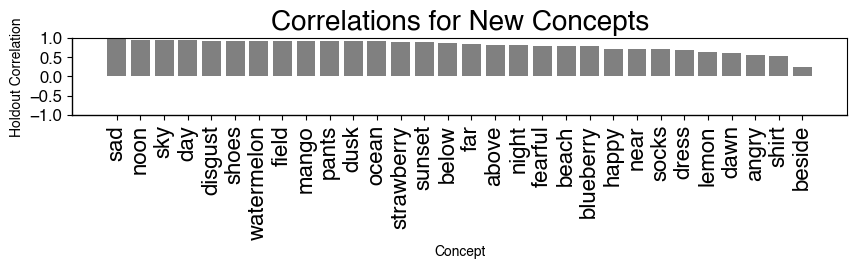

In [42]:
holdout_concept_cors_set1 = set1_mean_cors
### make a bar plot of the holdout_corr values in holdout_concept_cors and arrange the bars in descending order, maybe use seaborn

holdout_concept_cors_set1 = holdout_concept_cors_set1.sort_values(by='holdout_cor',ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,1))
plt.bar(np.arange(holdout_concept_cors_set1.shape[0]),holdout_concept_cors_set1.holdout_cor,color='gray')
plt.xticks(np.arange(holdout_concept_cors_set1.shape[0]),holdout_concept_cors_set1.concept,rotation=90,fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('Holdout Correlation',fontsize=10)
plt.xlabel('Concept',fontsize=10)
plt.title('Correlations for New Concepts',fontsize=20)
plt.ylim(-1,1)
plt.yticks([-1,-.5, 0,.5,1])
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
plt.savefig('../../data/recon_assocs/holdout_cor_barplot.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [43]:
print(f' mean correlation for set 1 = {holdout_concept_cors_set1.holdout_cor.mean()}')
print(f' sd correlation for set 1 = {holdout_concept_cors_set1.holdout_cor.std()}')
print(f' max correlation for set 1 = {holdout_concept_cors_set1.holdout_cor.max()}')
print(f' min correlation for set 1 = {holdout_concept_cors_set1.holdout_cor.min()}')

 mean correlation for set 1 = 0.8027585741241612
 sd correlation for set 1 = 0.16608972538473474
 max correlation for set 1 = 0.9697884986750076
 min correlation for set 1 = 0.23525267570867836


In [44]:
set1_mean_cors = set1_mean_cors.sort_values(by='holdout_cor',ascending=False).reset_index(drop=True)
set1_mean_cors

concept  holdout_cor         pvals  pvals_corrected    sig
0          sad     0.969788  2.588765e-40     7.766296e-39   True
1         noon     0.957370  1.103384e-35     3.199813e-34   True
2          sky     0.951618  5.449231e-34     1.525785e-32   True
3          day     0.942873  8.948289e-32     2.416038e-30   True
4      disgust     0.931632  2.161650e-29     5.620290e-28   True
5        shoes     0.930991  2.872357e-29     7.180893e-28   True
6   watermelon     0.926805  1.722039e-28     4.132895e-27   True
7        field     0.921848  1.257380e-27     2.891975e-26   True
8        mango     0.921196  1.617031e-27     3.557467e-26   True
9        pants     0.920487  2.120906e-27     4.453902e-26   True
10        dusk     0.918206  4.991594e-27     9.983187e-26   True
11       ocean     0.908546  1.448050e-25     2.751294e-24   True
12  strawberry     0.907852  1.818139e-25     3.272650e-24   True
13      sunset     0.889991  3.655032e-23     6.213555e-22   True
14       below     0.864315  1.810395e-20     2.896632e-19   True
15         far     0.848828  4.263255e-19     6.394883e-18   True
16       above     0.821199  5.417810e-17     7.584934e-16   True
17       night     0.809349  3.376550e-16     4.389514e-15   True
18     fearful     0.789095  5.836245e-15     7.003494e-14   True
19       beach     0.788200  6.572380e-15     7.229617e-14   True
20   blueberry     0.780633  1.753403e-14     1.753403e-13   True
21       happy     0.723629  9.775084e-12     8.797576e-11   True
22        near     0.712203  2.883217e-11     2.306574e-10   True
23       socks     0.708436  4.072061e-11     2.850442e-10   True
24       dress     0.674682  7.167032e-10     4.300219e-09   True
25       lemon     0.642888  7.733604e-09     3.866802e-08   True
26        dawn     0.607978  7.816632e-08     3.126653e-07   True
27       angry     0.553728  1.713683e-06     5.141050e-06   True
28       shirt     0.523137  7.786876e-06     1.557375e-05   True
29      beside     0.235253  5.923627e-02     5.923627e-02  False

20it [00:00, 35.86it/s]


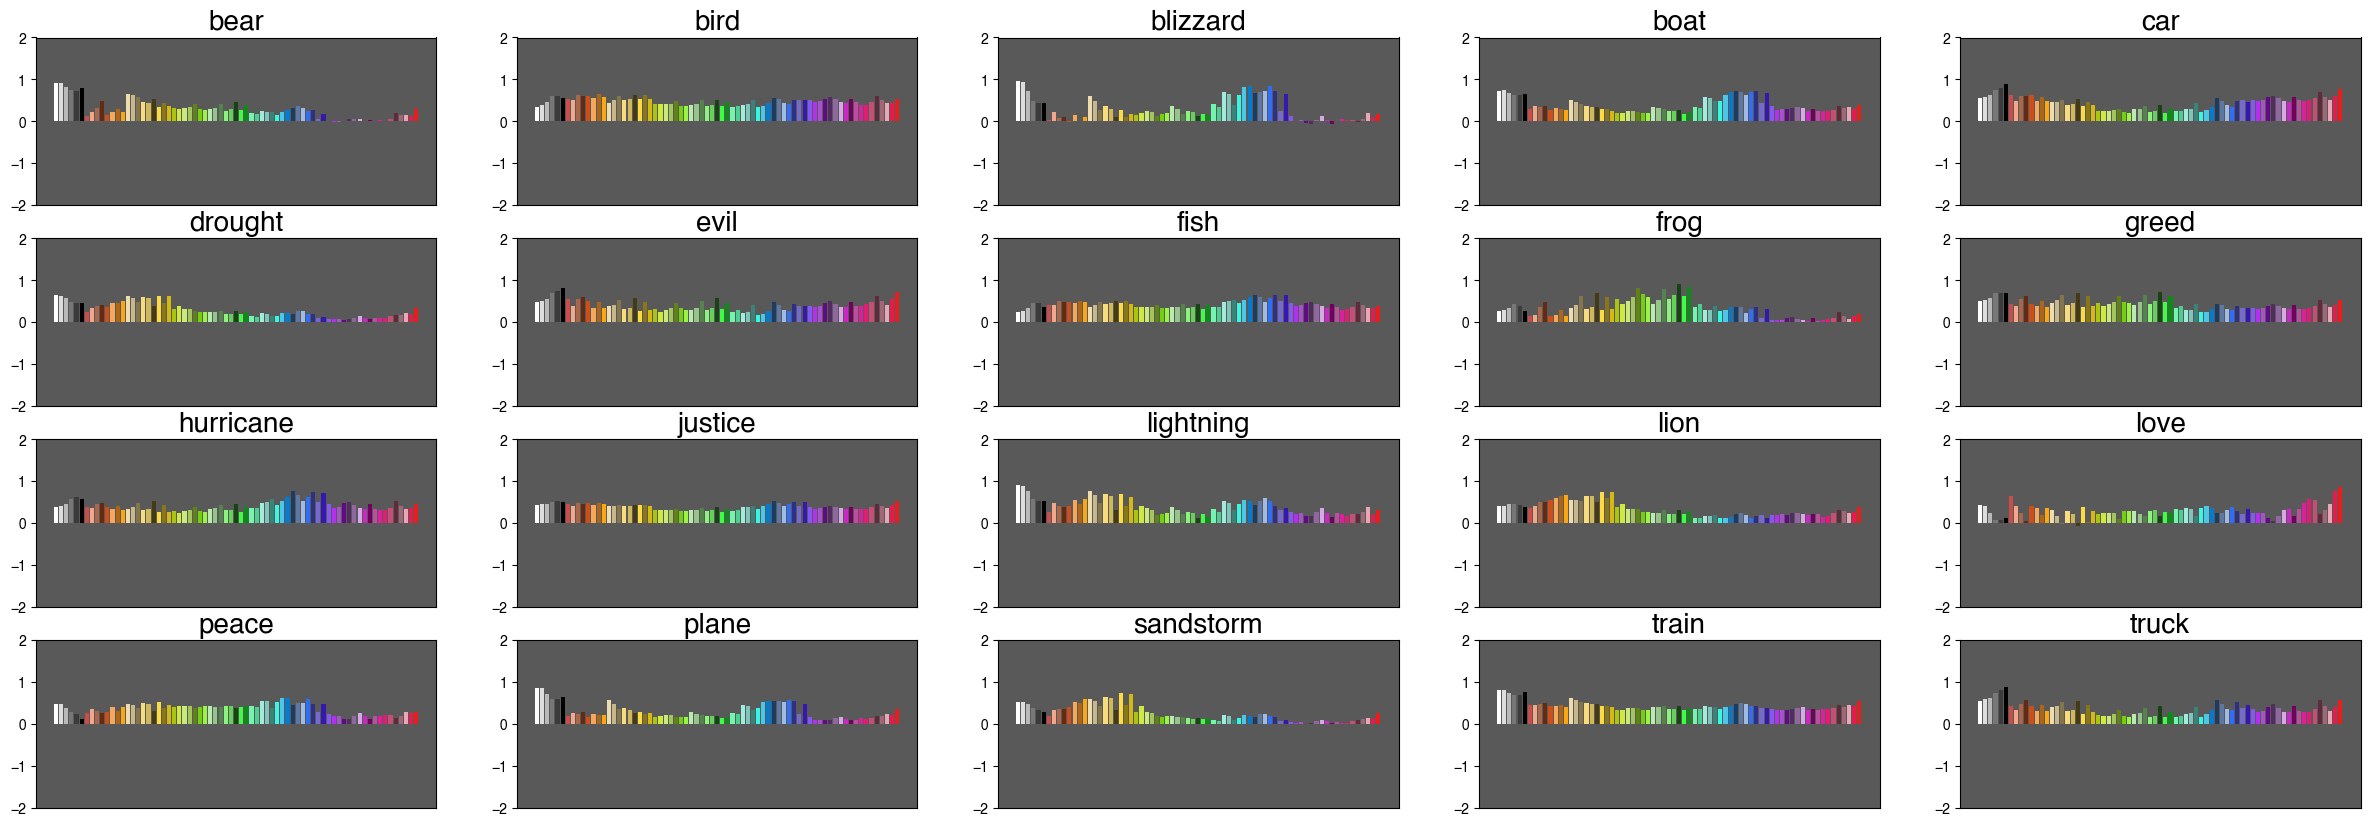

average reconstruction correlation: 0.6300758762611156


In [45]:
set2_mean_cors, set2_recon_ratings= reconstruct_assocs(set2_mat,set2_cmeans,'set2',num_pc=6,holdout_mode=False,compute_col_inds=None )
print('average reconstruction correlation:',set2_mean_cors.holdout_cor.mean())

20it [00:00, 30.26it/s]


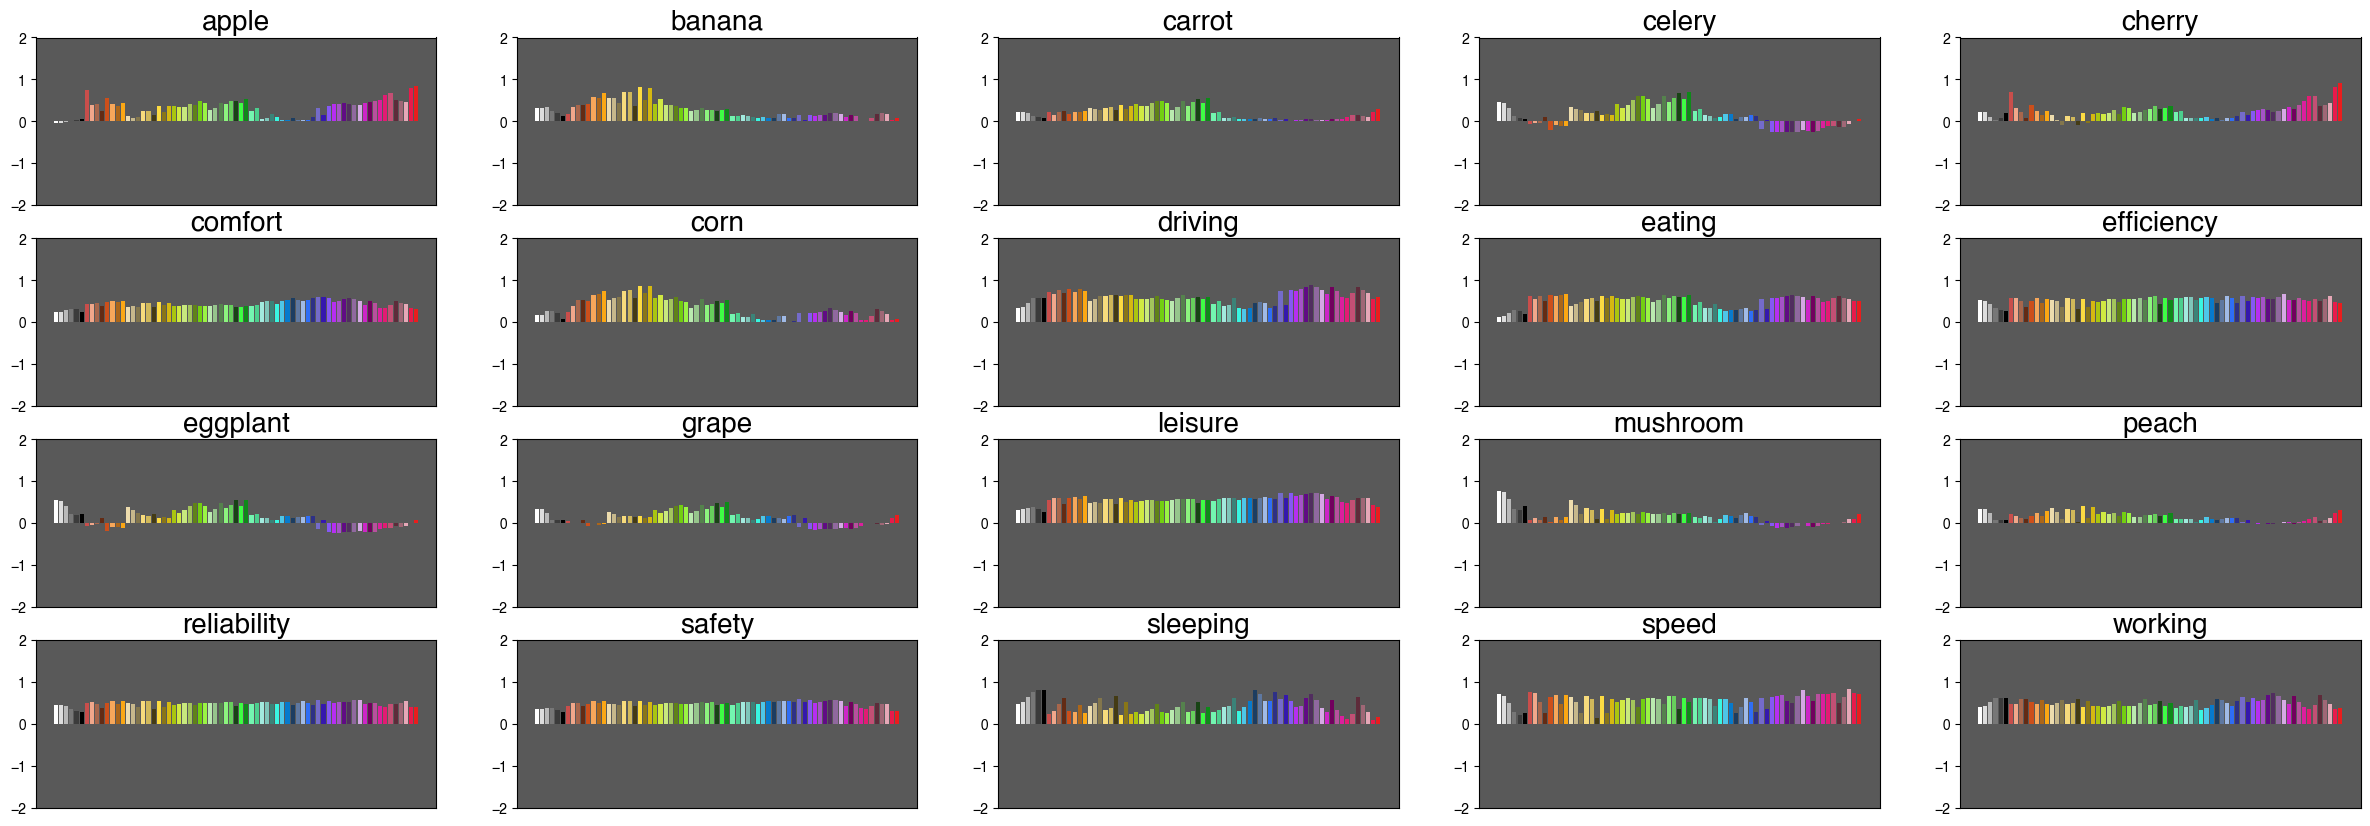

average reconstruction correlation: 0.4388163988734434


In [46]:
set3_mean_cors, set3_recon_ratings = reconstruct_assocs(set3_mat,set3_cmeans,'set3',num_pc=6,holdout_mode=False,compute_col_inds=None)
print('average reconstruction correlation:',set3_mean_cors.holdout_cor.mean())

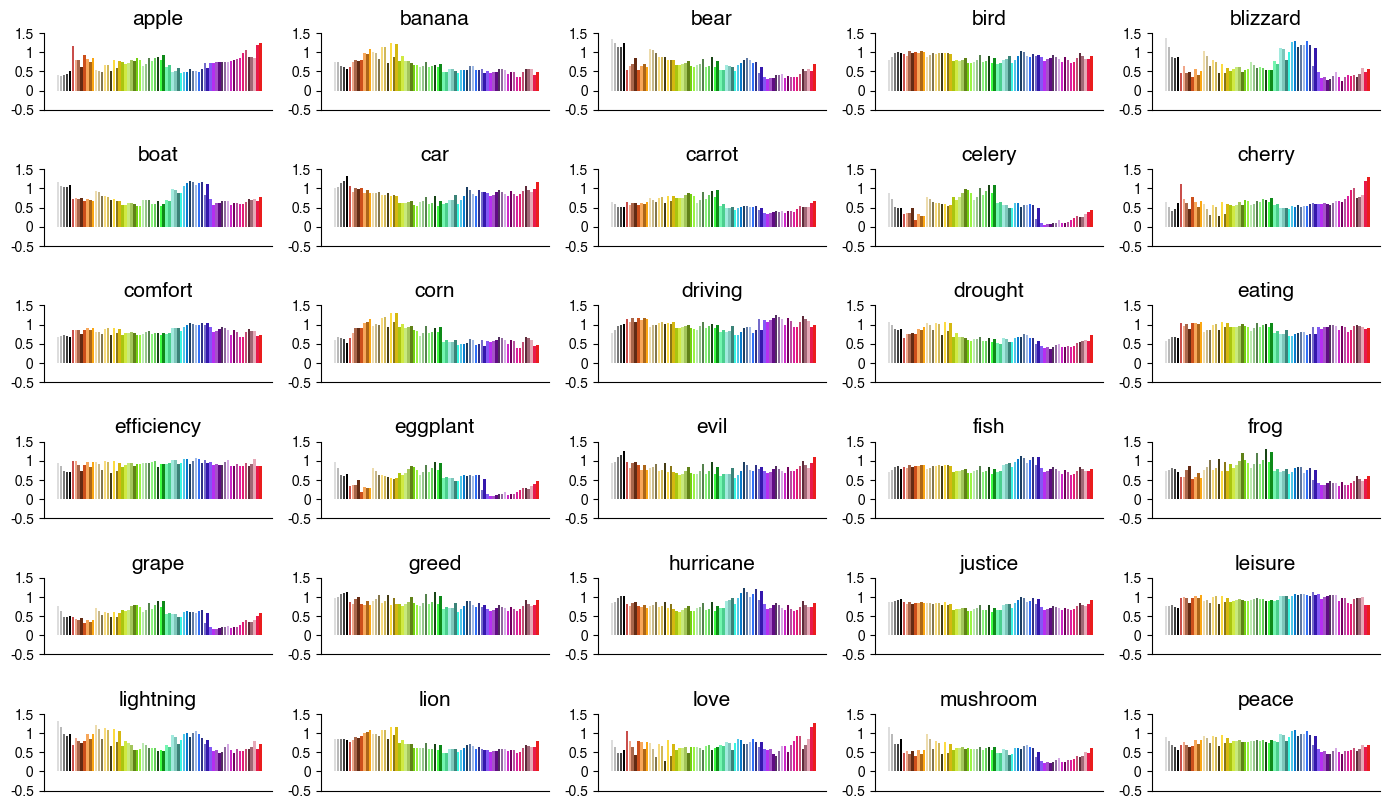

In [94]:
exp2_recon_ratings = pd.concat([set2_recon_ratings,set3_recon_ratings]).reset_index(drop=True)

exp2_recon_wide = exp2_recon_ratings.pivot(index='concept', columns='color_index', values='recon_rating').reset_index()
gpt_rate_fig = plt.figure(constrained_layout=True, figsize=(14,19))

gs = gpt_rate_fig.add_gridspec(14, 10)
for i in range(6):
    for j in range(5):
        # if (2*i)+j > 69:
        #     break
        ratings_ax = gpt_rate_fig.add_subplot(gs[i, (2*j):2+(2*j)])

        ratings_ax.bar(np.arange(71),exp2_recon_wide.iloc[(5*i)+j,sorted_col_order+1].values +set1_cmeans[sorted_col_order], color = uw71coords.iloc[sorted_col_order,:]['color_hex'].values, edgecolor='None')
        ratings_ax.set_ylim([-.5,1.5])
        ratings_ax.set_title(exp2_recon_wide.concept.values[(5*i)+j], fontsize=15)
        ###move the title down a bit
        ratings_ax.title.set_position([.5, 1.05])
        ### add some padding between different rows of subplots
        plt.tight_layout(h_pad=2)
        ### reduce the horizontal space between subplots
        # plt.subplots_adjust(wspace=.2)
        ### remove the x ticks
        ratings_ax.set_xticks([])
        sns.despine(ax=ratings_ax)
        ratings_ax.set_xticks([])
        ratings_ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
        ratings_ax.set_yticklabels(['-0.5', '0', '0.5', '1', '1.5'], fontsize=10)
        ### set the facecolor to white
        ratings_ax.set_facecolor((1,1,1))
        

plt.savefig('../../plots/exp2a_pred_dists.pdf',format ='pdf',bbox_inches='tight')

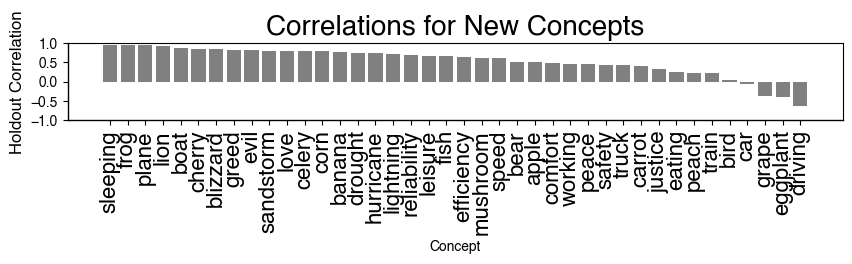

In [47]:
holdout_concept_cors = pd.concat([set2_mean_cors,set3_mean_cors]).reset_index(drop=True)
### make a bar plot of the holdout_corr values in holdout_concept_cors and arrange the bars in descending order, maybe use seaborn

holdout_concept_cors = holdout_concept_cors.sort_values(by='holdout_cor',ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,1))
plt.bar(np.arange(holdout_concept_cors.shape[0]),holdout_concept_cors.holdout_cor,color='gray')

plt.xticks(np.arange(holdout_concept_cors.shape[0]),holdout_concept_cors.concept,rotation=90,fontsize=16)
plt.yticks(fontsize=10)
plt.ylabel('Holdout Correlation',fontsize=12)
plt.xlabel('Concept',fontsize=10)

plt.title('Correlations for New Concepts',fontsize=20)
plt.ylim(-1,1)
plt.yticks([-1,-.5,0,.5,1])
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
plt.savefig('../../data/recon_assocs/generalization_cor_barplot.pdf',format='pdf',bbox_inches='tight')

In [48]:

holdout_concept_cors['pvals'] = holdout_concept_cors['pvals'].astype(float)
holdout_concept_cors['pvals_corrected'] = multipletests(holdout_concept_cors['pvals'],method='holm')[1]
holdout_concept_cors['sig'] = holdout_concept_cors['pvals_corrected']<.05
holdout_concept_cors


concept  holdout_cor         pvals  pvals_corrected    sig
0      sleeping     0.953169  1.999365e-34     7.997460e-33   True
1          frog     0.951429  6.142749e-34     2.395672e-32   True
2         plane     0.943315  7.054876e-32     2.680853e-30   True
3          lion     0.927000  1.588146e-28     5.876142e-27   True
4          boat     0.885572  1.179638e-22     4.246698e-21   True
5        cherry     0.847729  5.263309e-19     1.842158e-17   True
6      blizzard     0.840109  2.170160e-18     7.378544e-17   True
7         greed     0.830410  1.187548e-17     3.918908e-16   True
8          evil     0.820270  6.283885e-17     2.010843e-15   True
9     sandstorm     0.805129  6.283332e-16     1.947833e-14   True
10         love     0.802265  9.495334e-16     2.848600e-14   True
11       celery     0.801873  1.004315e-15     2.912514e-14   True
12         corn     0.791683  4.126996e-15     1.155559e-13   True
13       banana     0.768376  7.938151e-14     2.143301e-12   True
14      drought     0.750288  6.274311e-13     1.631321e-11   True
15    hurricane     0.747204  8.771169e-13     2.192792e-11   True
16    lightning     0.723676  9.730663e-12     2.335359e-10   True
17  reliability     0.682323  3.871665e-10     8.904830e-09   True
18      leisure     0.664314  1.606560e-09     3.534433e-08   True
19         fish     0.657317  2.721324e-09     5.714780e-08   True
20   efficiency     0.640430  9.189498e-09     1.837900e-07   True
21     mushroom     0.625589  2.521877e-08     4.539379e-07   True
22        speed     0.623351  2.923206e-08     4.969450e-07   True
23         bear     0.512913  1.250740e-05     2.001183e-04   True
24        apple     0.503135  1.940458e-05     2.910688e-04   True
25      comfort     0.487297  3.843336e-05     5.380670e-04   True
26      working     0.458466  1.227126e-04     1.595263e-03   True
27        peace     0.454792  1.412400e-04     1.694880e-03   True
28       safety     0.438281  2.606580e-04     2.867238e-03   True
29        truck     0.422166  4.603105e-04     4.603105e-03   True
30       carrot     0.407723  7.485433e-04     6.736890e-03   True
31      justice     0.327877  7.669652e-03     4.601791e-02   True
32       eating     0.257780  3.815883e-02     1.907942e-01  False
33        peach     0.224651  7.199904e-02     2.879962e-01  False
34        train     0.221140  7.668037e-02     2.879962e-01  False
35         bird     0.029045  8.183459e-01     1.000000e+00  False
36          car    -0.050399  6.901152e-01     1.000000e+00  False
37        grape    -0.361184  3.117168e-03     2.182017e-02   True
38     eggplant    -0.402595  8.850129e-04     7.080103e-03   True
39      driving    -0.636061  1.243910e-08     2.363429e-07   True

In [49]:
print(f' mean correlation for set 2/3 = {holdout_concept_cors.holdout_cor.mean()}')
print(f' sd correlation for set 2/3 = {holdout_concept_cors.holdout_cor.std()}')

 mean correlation for set 2/3 = 0.5344461375672795
 sd correlation for set 2/3 = 0.38282956800695694


### interlude to check specificity of the different sets

In [50]:
set1_mat
from scipy.stats import entropy
### for each row in set1_mat compute the entropy of the ratings and then compute the inverse of that to get a measure of diversity. So I should get a list of 30 values for each row in set1_mat

set1_mat_entropy = set1_mat.apply(lambda x: entropy(x),axis=1)
set1_mat_diversity = 1/set1_mat_entropy
print('mean entropy for set 1:',set1_mat_entropy.mean())

## do the same for set 2 and set 3
set2_mat_entropy = set2_mat.apply(lambda x: entropy(x),axis=1)
set2_mat_diversity = 1/set2_mat_entropy
print('mean entropy for set 2:',set2_mat_entropy.mean())

set3_mat_entropy = set3_mat.apply(lambda x: entropy(x),axis=1)
set3_mat_diversity = 1/set3_mat_entropy
print('mean entropy for set 3:',set3_mat_entropy.mean())


mean entropy for set 1: 4.1726936307423905
mean entropy for set 2: 4.14463235914098
mean entropy for set 3: 4.104085770908074


In [51]:
def plot_true_pred_assocs(grouped_ratings_df,ratings_mat,cmeans,df_name,num_pc=6,holdout_mode=False,compute_col_inds=None):
    Tot = len(np.unique(grouped_ratings_df.prompt))*2
    Cols = 6
    Rows = Tot // Cols 
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    fig = plt.figure(1,figsize=(35,(Rows/2)*5 ))
    fig2 = plt.figure(2,figsize=(8,Tot*4 +Tot ),constrained_layout=True)
    if compute_col_inds!=None:
        color_inds = return_rows((ratings_mat-cmeans),compute_col_inds)
    else:
        # color_inds = [11, 14, 24, 37, 43, 44, 62, 68]
        color_inds= [11, 20, 24, 37, 62, 68]
        #color_inds = np.arange(71)
    
    if holdout_mode==True:
        for i,this_concept in tqdm(enumerate(ratings_mat.index.values)):
            ax = fig.add_subplot(Rows, Cols, Position[(2*i)+1])
            concept_ratings = ratings_mat-cmeans
            concept_ratings_inv= concept_ratings[concept_ratings.index!=this_concept]
            #color_inds = return_rows(concept_ratings_inv,8)
            

            _,_,Vh = svd(concept_ratings_inv, full_matrices=False)
            basis_vecs = Vh[0:num_pc,color_inds]
            #concept_ratings = np.array(ratings[ratings.iloc[:,0].isin([this_concept])].iloc[:,1:59])-c_means.V1.values
            #reg = lm.LinearRegression().fit(A[color_inds,:], concept_ratings.squeeze(0)[color_inds])
            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs.T, concept_ratings[concept_ratings.index==this_concept].squeeze(0).values[color_inds])
            coords = reg.coef_
            recon = coords@Vh[0:num_pc,:]
            this_cor = np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1] 
            
            
            ax.bar(np.arange(71),recon[sorted_col_order]+cmeans[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
            ax.set_title(f'{this_concept} recon; r = {np.round(this_cor,2)}',fontsize=20)   
            ax.set_ylim(-2,2)
            ax.set_facecolor((0.349,0.349,0.349))
            ax.set_xticks([])

#             con_reg_cors.append(np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1]    )
            #num_pcs.append(num_pc)
#             cons.append(this_concept)
#             recon_ratings.append(recon)


            ds = grouped_ratings_df[grouped_ratings_df.prompt==this_concept]
            
            ax2 = fig2.add_subplot(int(Tot/2),1,i+1)
            ax2.plot(np.arange(-.5,1.5,.1),np.arange(-.5,1.5,.1),color='k')
            ax2.scatter(ds.iloc[sorted_col_order,3].values,recon[sorted_col_order]+cmeans[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
            ax2.set_title(f'{this_concept} True vs. Predicted ratings',fontsize=20)
            ax2.set_ylabel('Predicted',fontsize=20)
            ax2.set_xlabel('True',fontsize=20)
            ax2.tick_params(labelsize= 18 )
            ax2.set_xlim(0,1)
            ax2.set_ylim(-.5,1.2)
            ax2.set_aspect('equal')
        # fig.savefig(f'../../data/recon_assocs/{df_name}_mean_&_pred_ratings_holdout.pdf',format = 'pdf', bbox_inches= 'tight')
        fig2.savefig(f'../../data/recon_assocs/{df_name}true_vs_pred_holdout.pdf',format = 'pdf', bbox_inches= 'tight')
           
          
            

            
    elif holdout_mode==False:
        
        for i, this_concept in tqdm(enumerate(ratings_mat.index.values)):
            ax = fig.add_subplot(Rows, Cols, Position[(2*i)+1])
            concept_ratings = ratings_mat-cmeans
            #color_inds = return_rows(concept_ratings_inv,8)
           
            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1[0:num_pc,color_inds].T, concept_ratings[concept_ratings.index==this_concept].squeeze(0).values[color_inds])
            coords = reg.coef_
            recon = coords@basis_vecs1[0:num_pc,:]
            this_cor = np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1] 
            
            ax.bar(np.arange(71),recon[sorted_col_order]+cmeans[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
            ax.set_title(f'{this_concept} recon; r = {np.round(this_cor,2)}',fontsize=20)   
            ax.set_ylim(-2,2)
            ax.set_facecolor((0.349,0.349,0.349))
            ax.set_xticks([])

            #con_reg_cors.append(np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1]    )
            
            ds = grouped_ratings_df[grouped_ratings_df.prompt==this_concept]
            
            ax2 = fig2.add_subplot(int(Tot/2),1,i+1)
            ax2.plot(np.arange(-.5,1.5,.1),np.arange(-.5,1.5,.1),color='k')
            ax2.scatter(ds.iloc[sorted_col_order,3].values,recon[sorted_col_order]+cmeans[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
            ax2.set_title(f'{this_concept} True vs. Predicted ratings',fontsize=20)
            ax2.set_ylabel('Predicted',fontsize=20)
            ax2.set_xlabel('True',fontsize=20)
            ax2.tick_params(labelsize= 18 )
            ax2.set_xlim(0,1)
            ax2.set_ylim(-.5,1.2)
            ax2.set_aspect('equal')
        fig2.savefig(f'../../data/recon_assocs/{df_name}true_vs_pred.pdf',format = 'pdf', bbox_inches= 'tight')


    
    for i,con in enumerate(np.unique(grouped_ratings_df.prompt)):
        ax= fig.add_subplot(Rows, Cols, Position[2*i])
        ds = grouped_ratings_df[grouped_ratings_df.prompt==con]

        ax.bar(np.arange(71),ds.iloc[sorted_col_order,3].values,color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none') 
        #plt.bar(np.arange(71),ds.iloc[:,3].values) 

        ax.set_title(f'{con} true',fontsize=20)   
        ax.set_ylim(-2,2)

        ax.set_facecolor((0.349,0.349,0.349))
        ax.set_xticks([])

    # plt.savefig(f'../../data/recon_assocs/{df_name}_mean_&_pred_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
    if holdout_mode==True:
        fig.savefig(f'../../data/recon_assocs/{df_name}_mean_&_pred_ratings_holdout.pdf',format = 'pdf', bbox_inches= 'tight')
    elif holdout_mode==False:
        fig.savefig(f'../../data/recon_assocs/{df_name}_mean_&_pred_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
    
    ### dont show figures
    plt.close(fig)
    plt.close(fig2)
    # fig.show()
    # fig2.show()

    
   



In [52]:


### do the holm-bonferroni correction for multiple comparisons on holdout_concept_cors.pvals

holdout_concept_cors['pvals'] = holdout_concept_cors['pvals'].astype(float)
holdout_concept_cors['pvals_corrected'] = multipletests(holdout_concept_cors['pvals'],method='holm')[1]
holdout_concept_cors['sig'] = holdout_concept_cors['pvals_corrected']<.05

In [53]:

holdout_concept_cors

concept  holdout_cor         pvals  pvals_corrected    sig
0      sleeping     0.953169  1.999365e-34     7.997460e-33   True
1          frog     0.951429  6.142749e-34     2.395672e-32   True
2         plane     0.943315  7.054876e-32     2.680853e-30   True
3          lion     0.927000  1.588146e-28     5.876142e-27   True
4          boat     0.885572  1.179638e-22     4.246698e-21   True
5        cherry     0.847729  5.263309e-19     1.842158e-17   True
6      blizzard     0.840109  2.170160e-18     7.378544e-17   True
7         greed     0.830410  1.187548e-17     3.918908e-16   True
8          evil     0.820270  6.283885e-17     2.010843e-15   True
9     sandstorm     0.805129  6.283332e-16     1.947833e-14   True
10         love     0.802265  9.495334e-16     2.848600e-14   True
11       celery     0.801873  1.004315e-15     2.912514e-14   True
12         corn     0.791683  4.126996e-15     1.155559e-13   True
13       banana     0.768376  7.938151e-14     2.143301e-12   True
14      drought     0.750288  6.274311e-13     1.631321e-11   True
15    hurricane     0.747204  8.771169e-13     2.192792e-11   True
16    lightning     0.723676  9.730663e-12     2.335359e-10   True
17  reliability     0.682323  3.871665e-10     8.904830e-09   True
18      leisure     0.664314  1.606560e-09     3.534433e-08   True
19         fish     0.657317  2.721324e-09     5.714780e-08   True
20   efficiency     0.640430  9.189498e-09     1.837900e-07   True
21     mushroom     0.625589  2.521877e-08     4.539379e-07   True
22        speed     0.623351  2.923206e-08     4.969450e-07   True
23         bear     0.512913  1.250740e-05     2.001183e-04   True
24        apple     0.503135  1.940458e-05     2.910688e-04   True
25      comfort     0.487297  3.843336e-05     5.380670e-04   True
26      working     0.458466  1.227126e-04     1.595263e-03   True
27        peace     0.454792  1.412400e-04     1.694880e-03   True
28       safety     0.438281  2.606580e-04     2.867238e-03   True
29        truck     0.422166  4.603105e-04     4.603105e-03   True
30       carrot     0.407723  7.485433e-04     6.736890e-03   True
31      justice     0.327877  7.669652e-03     4.601791e-02   True
32       eating     0.257780  3.815883e-02     1.907942e-01  False
33        peach     0.224651  7.199904e-02     2.879962e-01  False
34        train     0.221140  7.668037e-02     2.879962e-01  False
35         bird     0.029045  8.183459e-01     1.000000e+00  False
36          car    -0.050399  6.901152e-01     1.000000e+00  False
37        grape    -0.361184  3.117168e-03     2.182017e-02   True
38     eggplant    -0.402595  8.850129e-04     7.080103e-03   True
39      driving    -0.636061  1.243910e-08     2.363429e-07   True

In [54]:
plot_true_pred_assocs(set1_grouped,set1_mat,set1_cmeans,'set1',num_pc=6,holdout_mode=True)

30it [00:02, 14.58it/s]


In [55]:
plot_true_pred_assocs(set2_grouped,set2_mat,set2_cmeans,'set2',num_pc=6,holdout_mode=False)

20it [00:01, 15.22it/s]


In [56]:
plot_true_pred_assocs(set3_grouped,set3_mat,set3_cmeans,'set3',num_pc=6,holdout_mode=False)

20it [00:01, 17.36it/s]


## Test reconstructions from color-concept associations vs. reconstructions from word vectors

In [57]:
set1_mean_cors

concept  holdout_cor         pvals  pvals_corrected    sig
0          sad     0.969788  2.588765e-40     7.766296e-39   True
1         noon     0.957370  1.103384e-35     3.199813e-34   True
2          sky     0.951618  5.449231e-34     1.525785e-32   True
3          day     0.942873  8.948289e-32     2.416038e-30   True
4      disgust     0.931632  2.161650e-29     5.620290e-28   True
5        shoes     0.930991  2.872357e-29     7.180893e-28   True
6   watermelon     0.926805  1.722039e-28     4.132895e-27   True
7        field     0.921848  1.257380e-27     2.891975e-26   True
8        mango     0.921196  1.617031e-27     3.557467e-26   True
9        pants     0.920487  2.120906e-27     4.453902e-26   True
10        dusk     0.918206  4.991594e-27     9.983187e-26   True
11       ocean     0.908546  1.448050e-25     2.751294e-24   True
12  strawberry     0.907852  1.818139e-25     3.272650e-24   True
13      sunset     0.889991  3.655032e-23     6.213555e-22   True
14       below     0.864315  1.810395e-20     2.896632e-19   True
15         far     0.848828  4.263255e-19     6.394883e-18   True
16       above     0.821199  5.417810e-17     7.584934e-16   True
17       night     0.809349  3.376550e-16     4.389514e-15   True
18     fearful     0.789095  5.836245e-15     7.003494e-14   True
19       beach     0.788200  6.572380e-15     7.229617e-14   True
20   blueberry     0.780633  1.753403e-14     1.753403e-13   True
21       happy     0.723629  9.775084e-12     8.797576e-11   True
22        near     0.712203  2.883217e-11     2.306574e-10   True
23       socks     0.708436  4.072061e-11     2.850442e-10   True
24       dress     0.674682  7.167032e-10     4.300219e-09   True
25       lemon     0.642888  7.733604e-09     3.866802e-08   True
26        dawn     0.607978  7.816632e-08     3.126653e-07   True
27       angry     0.553728  1.713683e-06     5.141050e-06   True
28       shirt     0.523137  7.786876e-06     1.557375e-05   True
29      beside     0.235253  5.923627e-02     5.923627e-02  False

In [58]:
pred_coords_fic = pd.read_csv('../../data/fic_predicted_coords.csv')
# pred_coords_fic = pred_coords_fic.sort_values(by='concepts',key= lambda x: x.map(concept_order)).reset_index(drop=True)
# pred_coords_fic = pred_coords_fic.sort_values(by='concepts')
pred_coords_gpt = pd.read_csv('../../data/gpt_predicted_coords.csv')
# pred_coords_gpt = pred_coords_gpt.sort_values(by='concepts',key= lambda x: x.map(concept_order)).reset_index(drop=True)
# pred_coords_gpt = pred_coords_gpt.sort_values(by='concepts')

In [59]:
cons = []
cors = []
print('test')
for i,this_concept in tqdm(enumerate(set1_mat.index.values)):
    
    concept_ratings = set1_mat - set1_cmeans
    concept_ratings_inv= concept_ratings[concept_ratings.index!=this_concept]
    # concept_ratings_inv = concept_ratings_inv - set1_cmeans
    #color_inds = return_rows(concept_ratings_inv,8)
    

    u,s,Vh =  np.linalg.svd(concept_ratings_inv, full_matrices=True)
    basis_vecs = Vh[0:6,:]
    

    predicted_ratings = pred_coords_fic[pred_coords_fic.concepts==this_concept].iloc[:,2:].values@basis_vecs
    true_ratings = concept_ratings[concept_ratings.index==this_concept] 

    this_cor = np.corrcoef(predicted_ratings,true_ratings)[0,1] 
    cons.append(this_concept)
    cors.append(this_cor)
    if this_concept=='noon':
        print(basis_vecs)
tmp_fic = pd.DataFrame({'concepts':cons,'cors':cors})



cons = []
cors = []
for i,this_concept in tqdm(enumerate(set1_mat.index.values)):

    concept_ratings = set1_mat - set1_cmeans
    concept_ratings_inv= concept_ratings[concept_ratings.index!=this_concept]
    #color_inds = return_rows(concept_ratings_inv,8)
    

    u,s,Vh =  np.linalg.svd(concept_ratings_inv, full_matrices=True)

    basis_vecs = Vh[0:6,:]

    predicted_ratings = pred_coords_gpt[pred_coords_gpt.concepts==this_concept].iloc[:,2:].values@basis_vecs
    true_ratings = concept_ratings[concept_ratings.index==this_concept] 

    this_cor = np.corrcoef(predicted_ratings,true_ratings)[0,1] 
    cons.append(this_concept)
    cors.append(this_cor)
tmp_gpt = pd.DataFrame({'concepts':cons,'cors':cors})

test


30it [00:00, 844.41it/s]


[[ 1.35983680e-02  1.26356843e-01 -6.64075004e-03 -6.17747118e-02
   1.18008489e-02  1.67100315e-01  1.52211205e-02  5.79427736e-02
  -5.73412217e-02 -9.68481924e-02 -6.91990857e-02  1.90762374e-01
   9.59308161e-02 -1.80397565e-02  1.00062070e-01 -2.05755582e-04
  -1.19524274e-01  4.37620055e-02 -8.28270388e-02 -1.29624877e-01
  -1.07828956e-01  5.23723804e-02 -6.01707140e-02 -8.05446337e-02
   2.70760189e-01  2.47382632e-01  1.92522570e-01  8.32206956e-02
  -2.93291948e-02  1.10533331e-03  8.69499947e-02 -2.73739235e-02
  -1.42902911e-01 -1.15199056e-01 -1.43386164e-01 -1.27091628e-01
  -1.36819306e-01 -1.85400361e-02 -4.96950207e-02 -1.09806616e-01
  -1.24703615e-01  1.09725391e-01  6.90127587e-02 -3.36009996e-02
  -7.50787046e-02  1.00821893e-01 -1.90224327e-02 -1.28379128e-01
  -1.18395664e-01 -1.32409759e-01 -1.17668578e-01 -1.74937315e-01
  -1.75827021e-01 -5.40715201e-02 -1.32190635e-01 -1.57622385e-01
   1.74421987e-02 -1.17114700e-01 -1.45260009e-01 -2.50046883e-02
  -1.48774

30it [00:00, 831.43it/s]


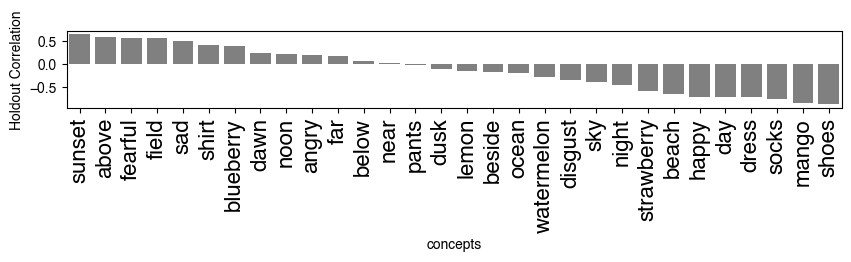

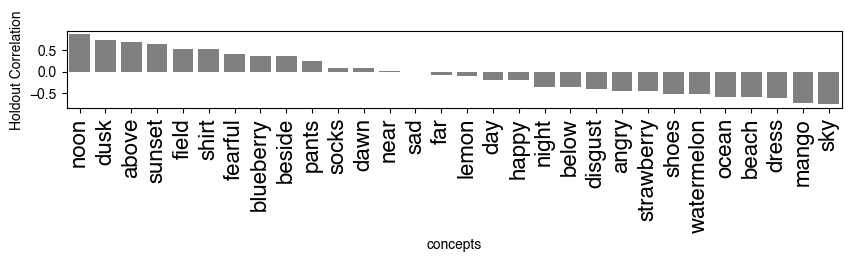

In [60]:
tmp_fic = tmp_fic.sort_values(by='cors',ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,1))
sns.barplot(x='concepts',y='cors',data=tmp_fic, color='gray')
plt.ylabel('Holdout Correlation',fontsize=10)
plt.xticks(np.arange(tmp_fic.shape[0]),tmp_fic.concepts,rotation=90,fontsize=16)
plt.show()


tmp_gpt = tmp_gpt.sort_values(by='cors',ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,1))
sns.barplot(x='concepts',y='cors',data=tmp_gpt, color='gray')
plt.ylabel('Holdout Correlation',fontsize=10)
plt.xticks(np.arange(tmp_gpt.shape[0]),tmp_gpt.concepts,rotation=90,fontsize=16)
plt.show()

In [61]:
np.mean(tmp_fic.cors)

-0.11411507862551756

In [62]:
np.mean(tmp_gpt.cors)

-0.04349009226883567

In [63]:
### load the scipy module for paired t-tests
from scipy.stats import ttest_rel
print('paired t-test between fiction and cca')
print(ttest_rel(np.arctanh(set1_mean_cors.holdout_cor),np.arctanh(tmp_fic.sort_values(by='concepts').cors)))
print('paired t-test between fiction and cca')
print(ttest_rel(np.arctanh(set1_mean_cors.holdout_cor),np.arctanh(tmp_gpt.sort_values(by='concepts').cors)))

paired t-test between fiction and cca
TtestResult(statistic=11.258816460537005, pvalue=4.194730606401363e-12, df=29)
paired t-test between fiction and cca
TtestResult(statistic=10.245172700091645, pvalue=3.798763878664865e-11, df=29)


## Combine datasets

In [64]:
set_all_grouped = pd.concat((set1_grouped,set2_grouped,set3_grouped)).sort_values(by=['prompt','color_index']).reset_index(drop=True)
set_all_mat = pd.concat((set1_mat,set2_mat,set3_mat)).sort_index()
set_all_cmeans= set_all_mat.mean().values
U_all,S_all, Vh_all = svd((set_all_mat-set_all_cmeans),full_matrices= False)
factor_mat_all =  U_all @ np.diag(S_all)
basis_vecs_all = Vh_all

In [65]:
set_all_mat.to_csv('../../data/recon_assocs/set_all_mat.csv')

#### check for low rank structure here

In [66]:
### check for low rank structure by shuffling the original matrix and computing the svd
rng = np.random.default_rng()
test = set_all_mat - set_all_cmeans ### true ratings with columns centered
shuffle_test = set_all_mat - set_all_cmeans ### same as above
shuffle_test = rng.permuted(shuffle_test) ### permuted ratings
shuf_u, shuf_s, shuf_vt = svd(shuffle_test, full_matrices=False) ###svd of shuffled matrix
factor_mat_shuf = shuf_u@np.diag(shuf_s) ### left singular vectors scaled with singular values for shuffled matrix


In [67]:
n_comp = []
r =[] ## will hold reconstruction correlations for unshuffled matrix
r_shuf = [] ## will hold reconstruction correlations for shuffled matrix
for i in range(1,70): ### concept
    for j in range(1,70): ### ncomps
        r.append(pearsonr(np.matmul(factor_mat_all[:,0:j+1],basis_vecs_all[0:j+1,:])[i,],test.iloc[i,])[0])
        r_shuf.append(pearsonr(np.matmul(factor_mat_shuf[:,0:j+1],shuf_vt[0:j+1,:])[i,],shuffle_test[i,])[0])
        n_comp.append(j)
        
cor_df = pd.DataFrame({'n_comp':n_comp,'r':r,'r_shuf':r_shuf})


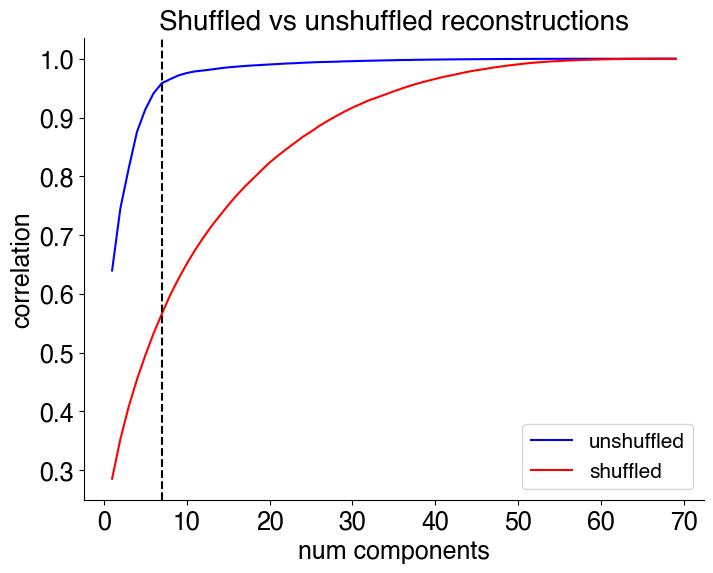

In [68]:
summary_cor_df = cor_df.groupby(n_comp).mean().reset_index()

plt.figure(figsize=(8,6))
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.gca().spines[:].set_color('k')
plt.plot(np.arange(1,70),summary_cor_df.r.values,label='unshuffled', color='blue')
plt.plot(np.arange(1,70),summary_cor_df.r_shuf.values,label='shuffled',color='red')
##
plt.xlabel('num components',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('correlation',fontsize=18)
plt.legend(fontsize=15)
### draw a vertical dashed line at x= 7
sns.despine()
plt.axvline(x=7, color='k', linestyle='--')
plt.title('Shuffled vs unshuffled reconstructions',fontsize=20)
plt.savefig('../../data/recon_assocs/shuffled_vs_unshuffled_all_data.pdf',format ='pdf',bbox_inches='tight')



In [69]:
summary_cor_df.r.values

array([0.63971812, 0.74551704, 0.81314489, 0.87544076, 0.91344196,
       0.94110836, 0.95834162, 0.96518096, 0.97153385, 0.97565077,
       0.97843269, 0.98001717, 0.98175929, 0.9837054 , 0.98530291,
       0.98653962, 0.98762306, 0.98857592, 0.98939474, 0.99019246,
       0.99094761, 0.99181086, 0.99237191, 0.99314122, 0.99372828,
       0.99428177, 0.99459251, 0.99493725, 0.99550603, 0.99580268,
       0.99623289, 0.99658694, 0.99688152, 0.99721924, 0.99749312,
       0.99774144, 0.99797304, 0.99822868, 0.99840144, 0.99856481,
       0.99871534, 0.99886374, 0.99898626, 0.99909739, 0.99918508,
       0.99931783, 0.999409  , 0.99950231, 0.99957058, 0.99963439,
       0.99968946, 0.9997297 , 0.99978333, 0.99982224, 0.99984848,
       0.9998857 , 0.9999103 , 0.9999363 , 0.99995359, 0.99996416,
       0.99997476, 0.99998445, 0.99998991, 0.99999521, 0.99999844,
       0.99999919, 0.99999985, 1.        , 1.        ])

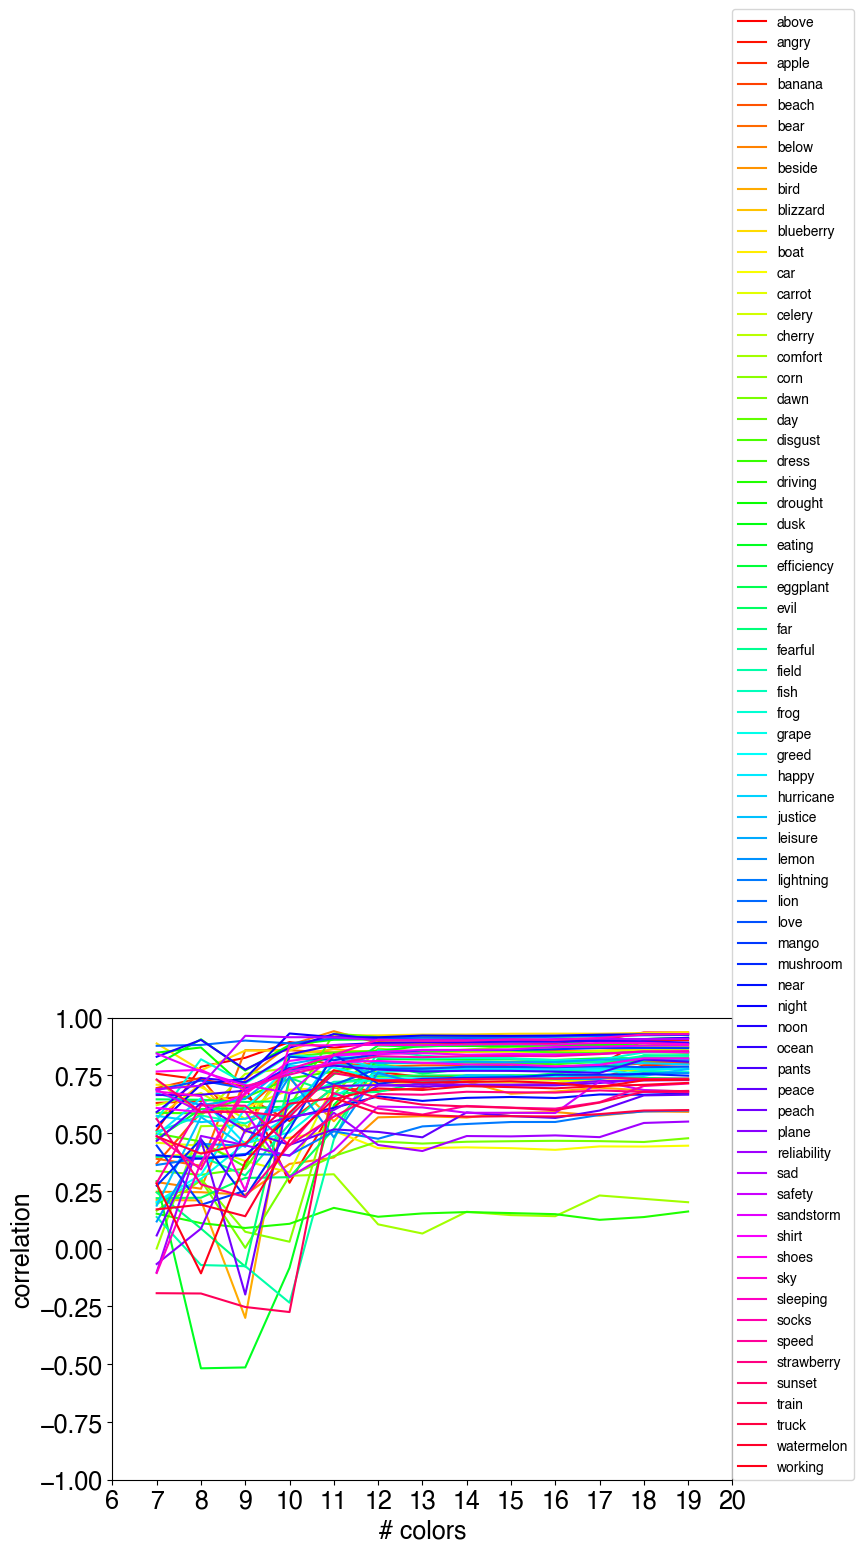

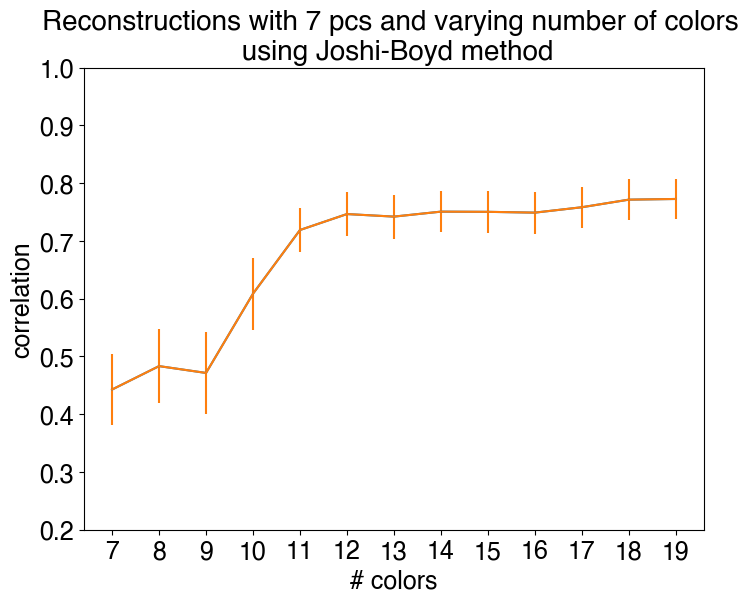

In [172]:
d =vary_colors_jb(set_all_mat,set_all_cmeans,basis_vecs_all,num_pc=7)
plot_ys_jb = d.groupby('num_cols')['correlation'].mean().values
plot_err_jb = d.groupby('num_cols')['correlation'].std().values/np.sqrt(70)*1.96
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(7,20,1),plot_ys_jb)
plt.errorbar(x= np.arange(7,20,1),y = plot_ys_jb,yerr=plot_err_jb)
plt.title('Reconstructions with 7 pcs and varying number of colors \n using Joshi-Boyd method',fontsize=20)
plt.xlabel('# colors',fontsize=18)
plt.xticks(np.arange(7,20,1),fontsize=18)
plt.ylim(.2,1)
plt.yticks(fontsize=18)
plt.ylabel('correlation',fontsize=18)
plt.show()

### Plot components

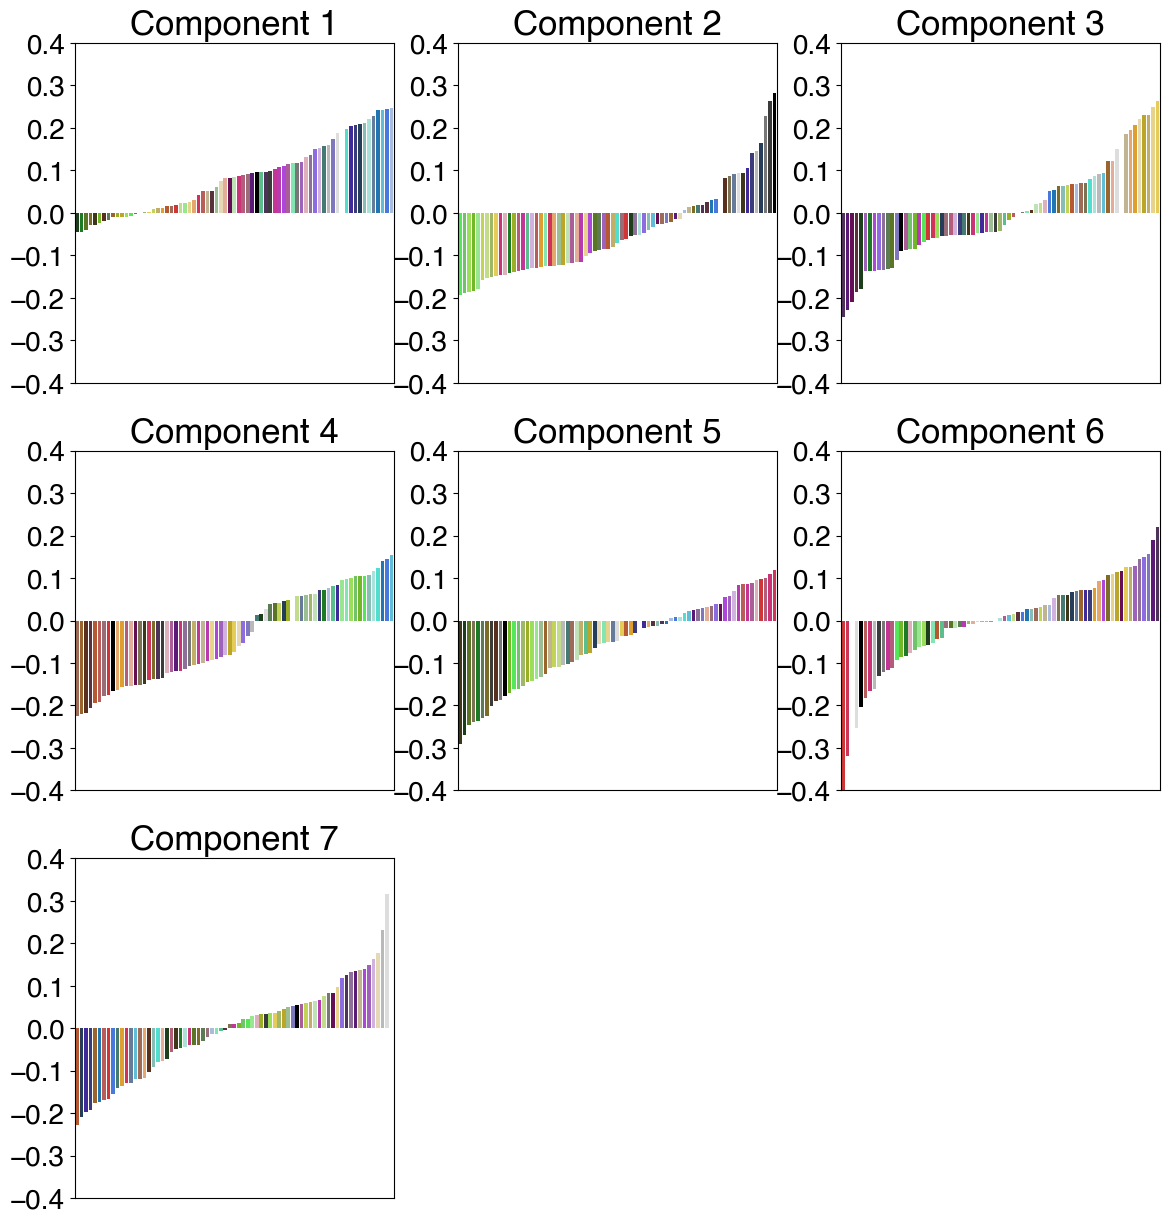

In [176]:
plot_components(basis_vecs_all,7,save=True,facet=True, fname='exp2_components')

In [97]:
set_all_wide

color_index      prompt       0.0       1.0       2.0       3.0       4.0  \
0                 above  0.649375  0.461193  0.473295  0.477159  0.631136   
1                 angry  0.225650  0.323600  0.223300  0.304400  0.185750   
2                 apple  0.072092  0.064388  0.072857  0.078010  0.065153   
3                banana  0.067347  0.061786  0.070204  0.067041  0.066735   
4                 beach  0.758500  0.575778  0.232556  0.213278  0.764333   
..                  ...       ...       ...       ...       ...       ...   
65               sunset  0.293778  0.298611  0.429167  0.420500  0.332500   
66                train  0.392696  0.447255  0.282892  0.243480  0.410294   
67                truck  0.402990  0.485098  0.152549  0.112745  0.412696   
68           watermelon  0.172554  0.161141  0.134728  0.202500  0.163315   
69              working  0.430000  0.477692  0.313125  0.264135  0.441490   

color_index       5.0       6.0       7.0       8.0  ...      61.0      62.0  \
0            0.500284  0.524091  0.296591  0.484205  ...  0.428409  0.415682   
1            0.331800  0.218850  0.363900  0.219550  ...  0.613950  0.825300   
2            0.094235  0.073776  0.082653  0.080561  ...  0.365561  0.851582   
3            0.067092  0.078878  0.063827  0.074847  ...  0.119592  0.084337   
4            0.613500  0.364667  0.192444  0.207889  ...  0.330556  0.237333   
..                ...       ...       ...       ...  ...       ...       ...   
65           0.295667  0.470389  0.365556  0.491000  ...  0.730556  0.639667   
66           0.460490  0.316324  0.275784  0.228578  ...  0.468824  0.552598   
67           0.531863  0.208627  0.167647  0.111324  ...  0.287108  0.568578   
68           0.151087  0.174293  0.140326  0.204022  ...  0.318641  0.732717   
69           0.503558  0.385962  0.334712  0.298942  ...  0.439038  0.387788   

color_index      63.0      64.0      65.0      66.0      67.0      68.0  \
0            0.589432  0.550000  0.585739  0.513864  0.586136  0.565795   
1            0.197250  0.246050  0.193250  0.256200  0.200150  0.277350   
2            0.590153  0.649592  0.587959  0.465051  0.427704  0.353214   
3            0.282755  0.327551  0.341735  0.493418  0.579082  0.797245   
4            0.303222  0.320889  0.347389  0.357056  0.449611  0.595111   
..                ...       ...       ...       ...       ...       ...   
65           0.180833  0.186611  0.195556  0.252111  0.384389  0.687944   
66           0.294902  0.355539  0.335392  0.387157  0.405049  0.408725   
67           0.175294  0.187745  0.173627  0.208235  0.156029  0.273039   
68           0.712391  0.699837  0.657989  0.538750  0.412663  0.234076   
69           0.398269  0.402740  0.378558  0.433750  0.395865  0.428702   

color_index      69.0      70.0  
0            0.643239  0.556534  
1            0.301250  0.461400  
2            0.343367  0.284949  
3            0.879592  0.406173  
4            0.706111  0.556611  
..                ...       ...  
65           0.683389  0.784111  
66           0.410049  0.407108  
67           0.222108  0.256275  
68           0.213750  0.188696  
69           0.457356  0.419471  

[70 rows x 72 columns]

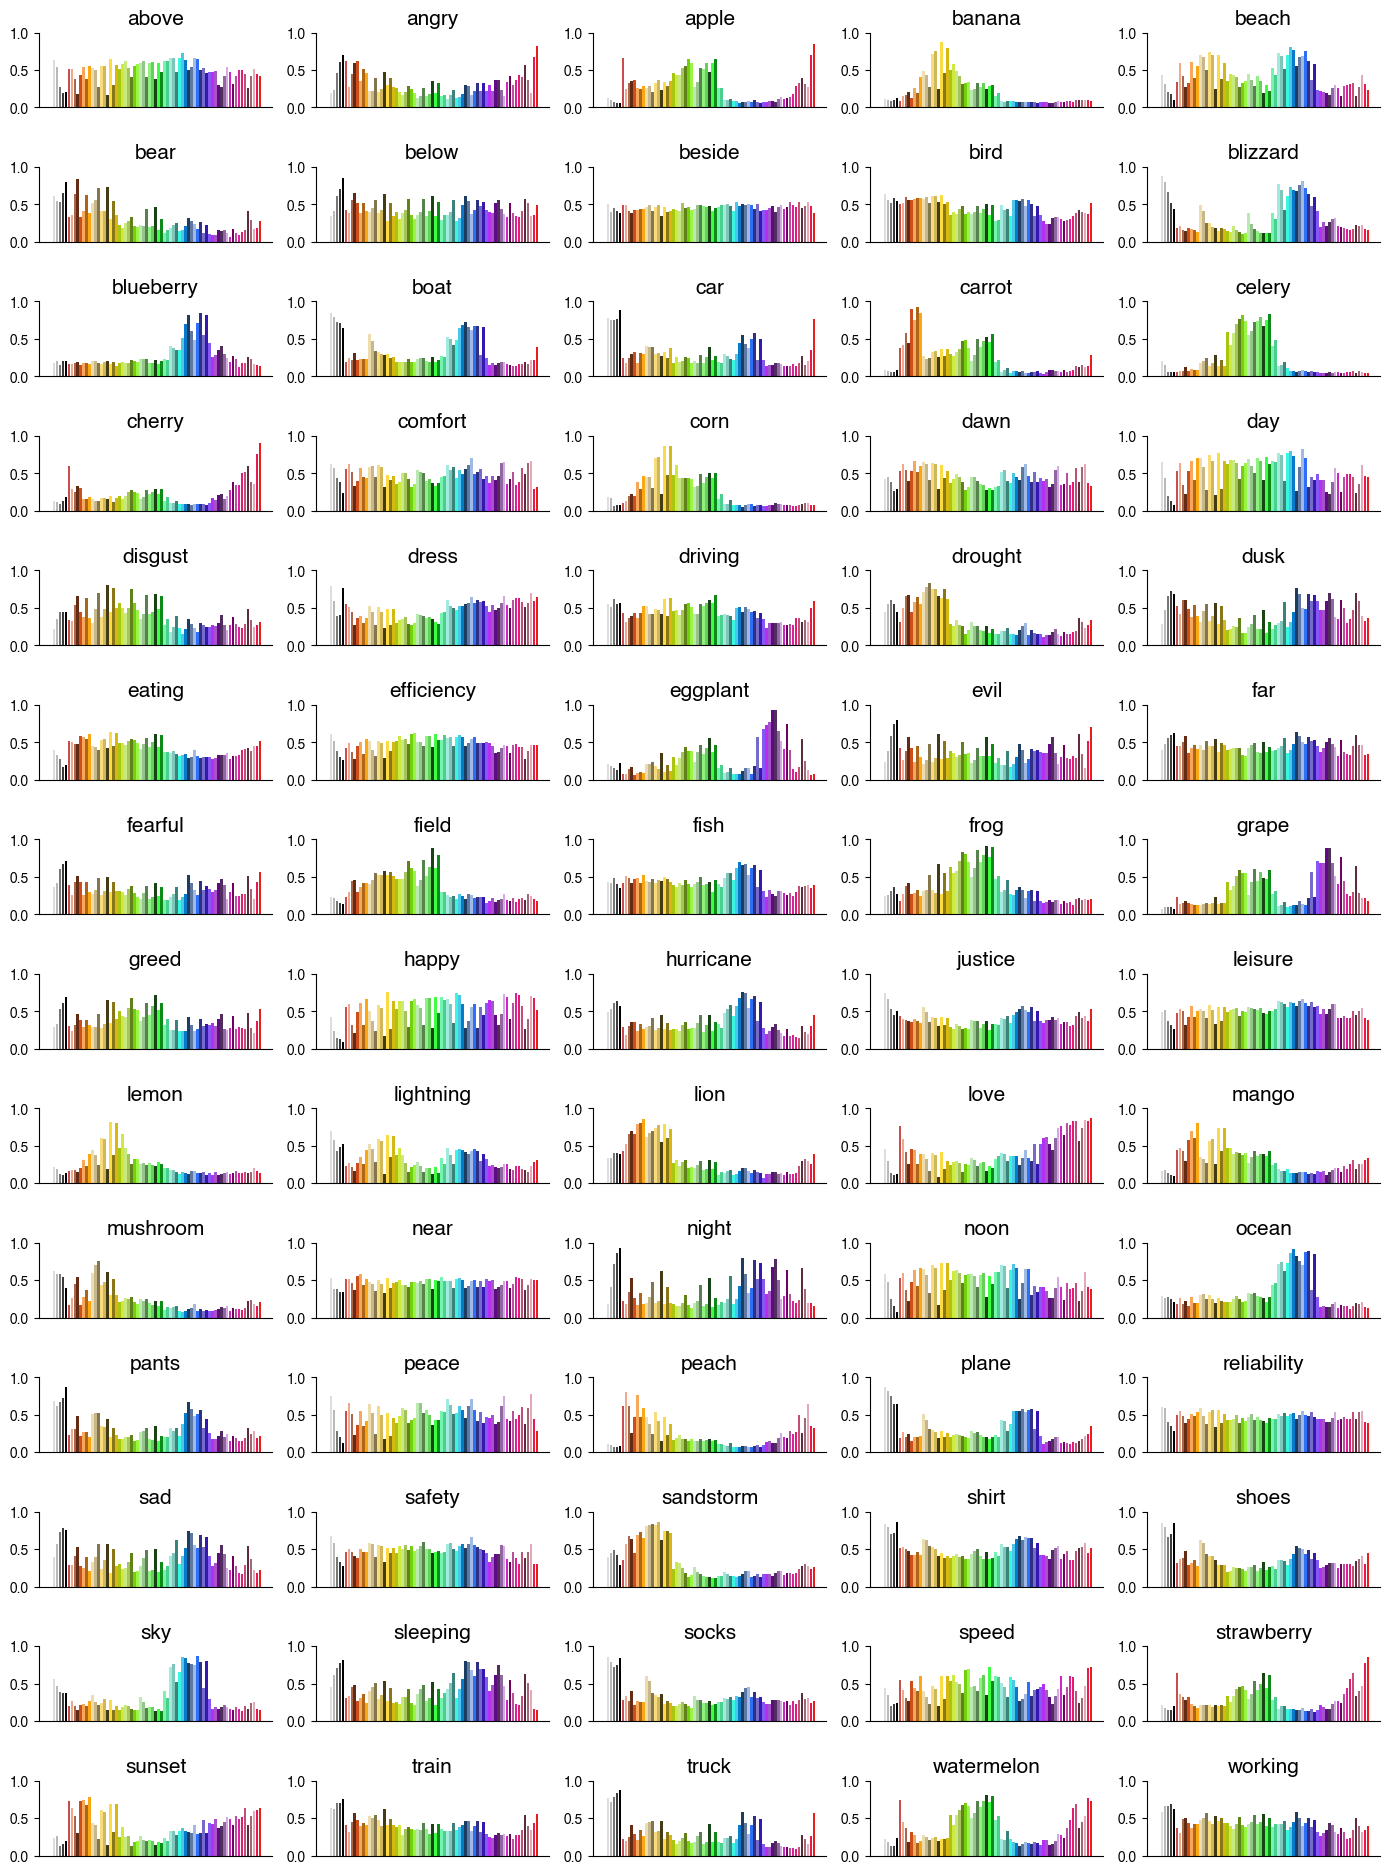

In [77]:
set_all_wide = set_all_grouped.pivot(index='prompt', columns='color_index', values='mean_rating').reset_index()
gpt_rate_fig = plt.figure(constrained_layout=True, figsize=(14,19))

gs = gpt_rate_fig.add_gridspec(14, 10)
for i in range(14):
    for j in range(5):
        # if (2*i)+j > 69:
        #     break
        ratings_ax = gpt_rate_fig.add_subplot(gs[i, (2*j):2+(2*j)])

        ratings_ax.bar(np.arange(71),set_all_wide.iloc[(5*i)+j,sorted_col_order+1].values, color = uw71coords.iloc[sorted_col_order,:]['color_hex'].values, edgecolor='None')
        ratings_ax.set_ylim([0,1])
        ratings_ax.set_title(set_all_wide.prompt.values[(5*i)+j], fontsize=15)
        ###move the title down a bit
        ratings_ax.title.set_position([.5, 1.05])
        ### add some padding between different rows of subplots
        plt.tight_layout(h_pad=2)
        ### reduce the horizontal space between subplots
        # plt.subplots_adjust(wspace=.2)
        ### remove the x ticks
        ratings_ax.set_xticks([])
        sns.despine(ax=ratings_ax)
        ### set the facecolor to white
        ratings_ax.set_facecolor((1,1,1))
        

plt.savefig('../../plots/human_rating_dists.pdf',format ='pdf',bbox_inches='tight')


70it [00:02, 28.85it/s]


0.7459774171236491

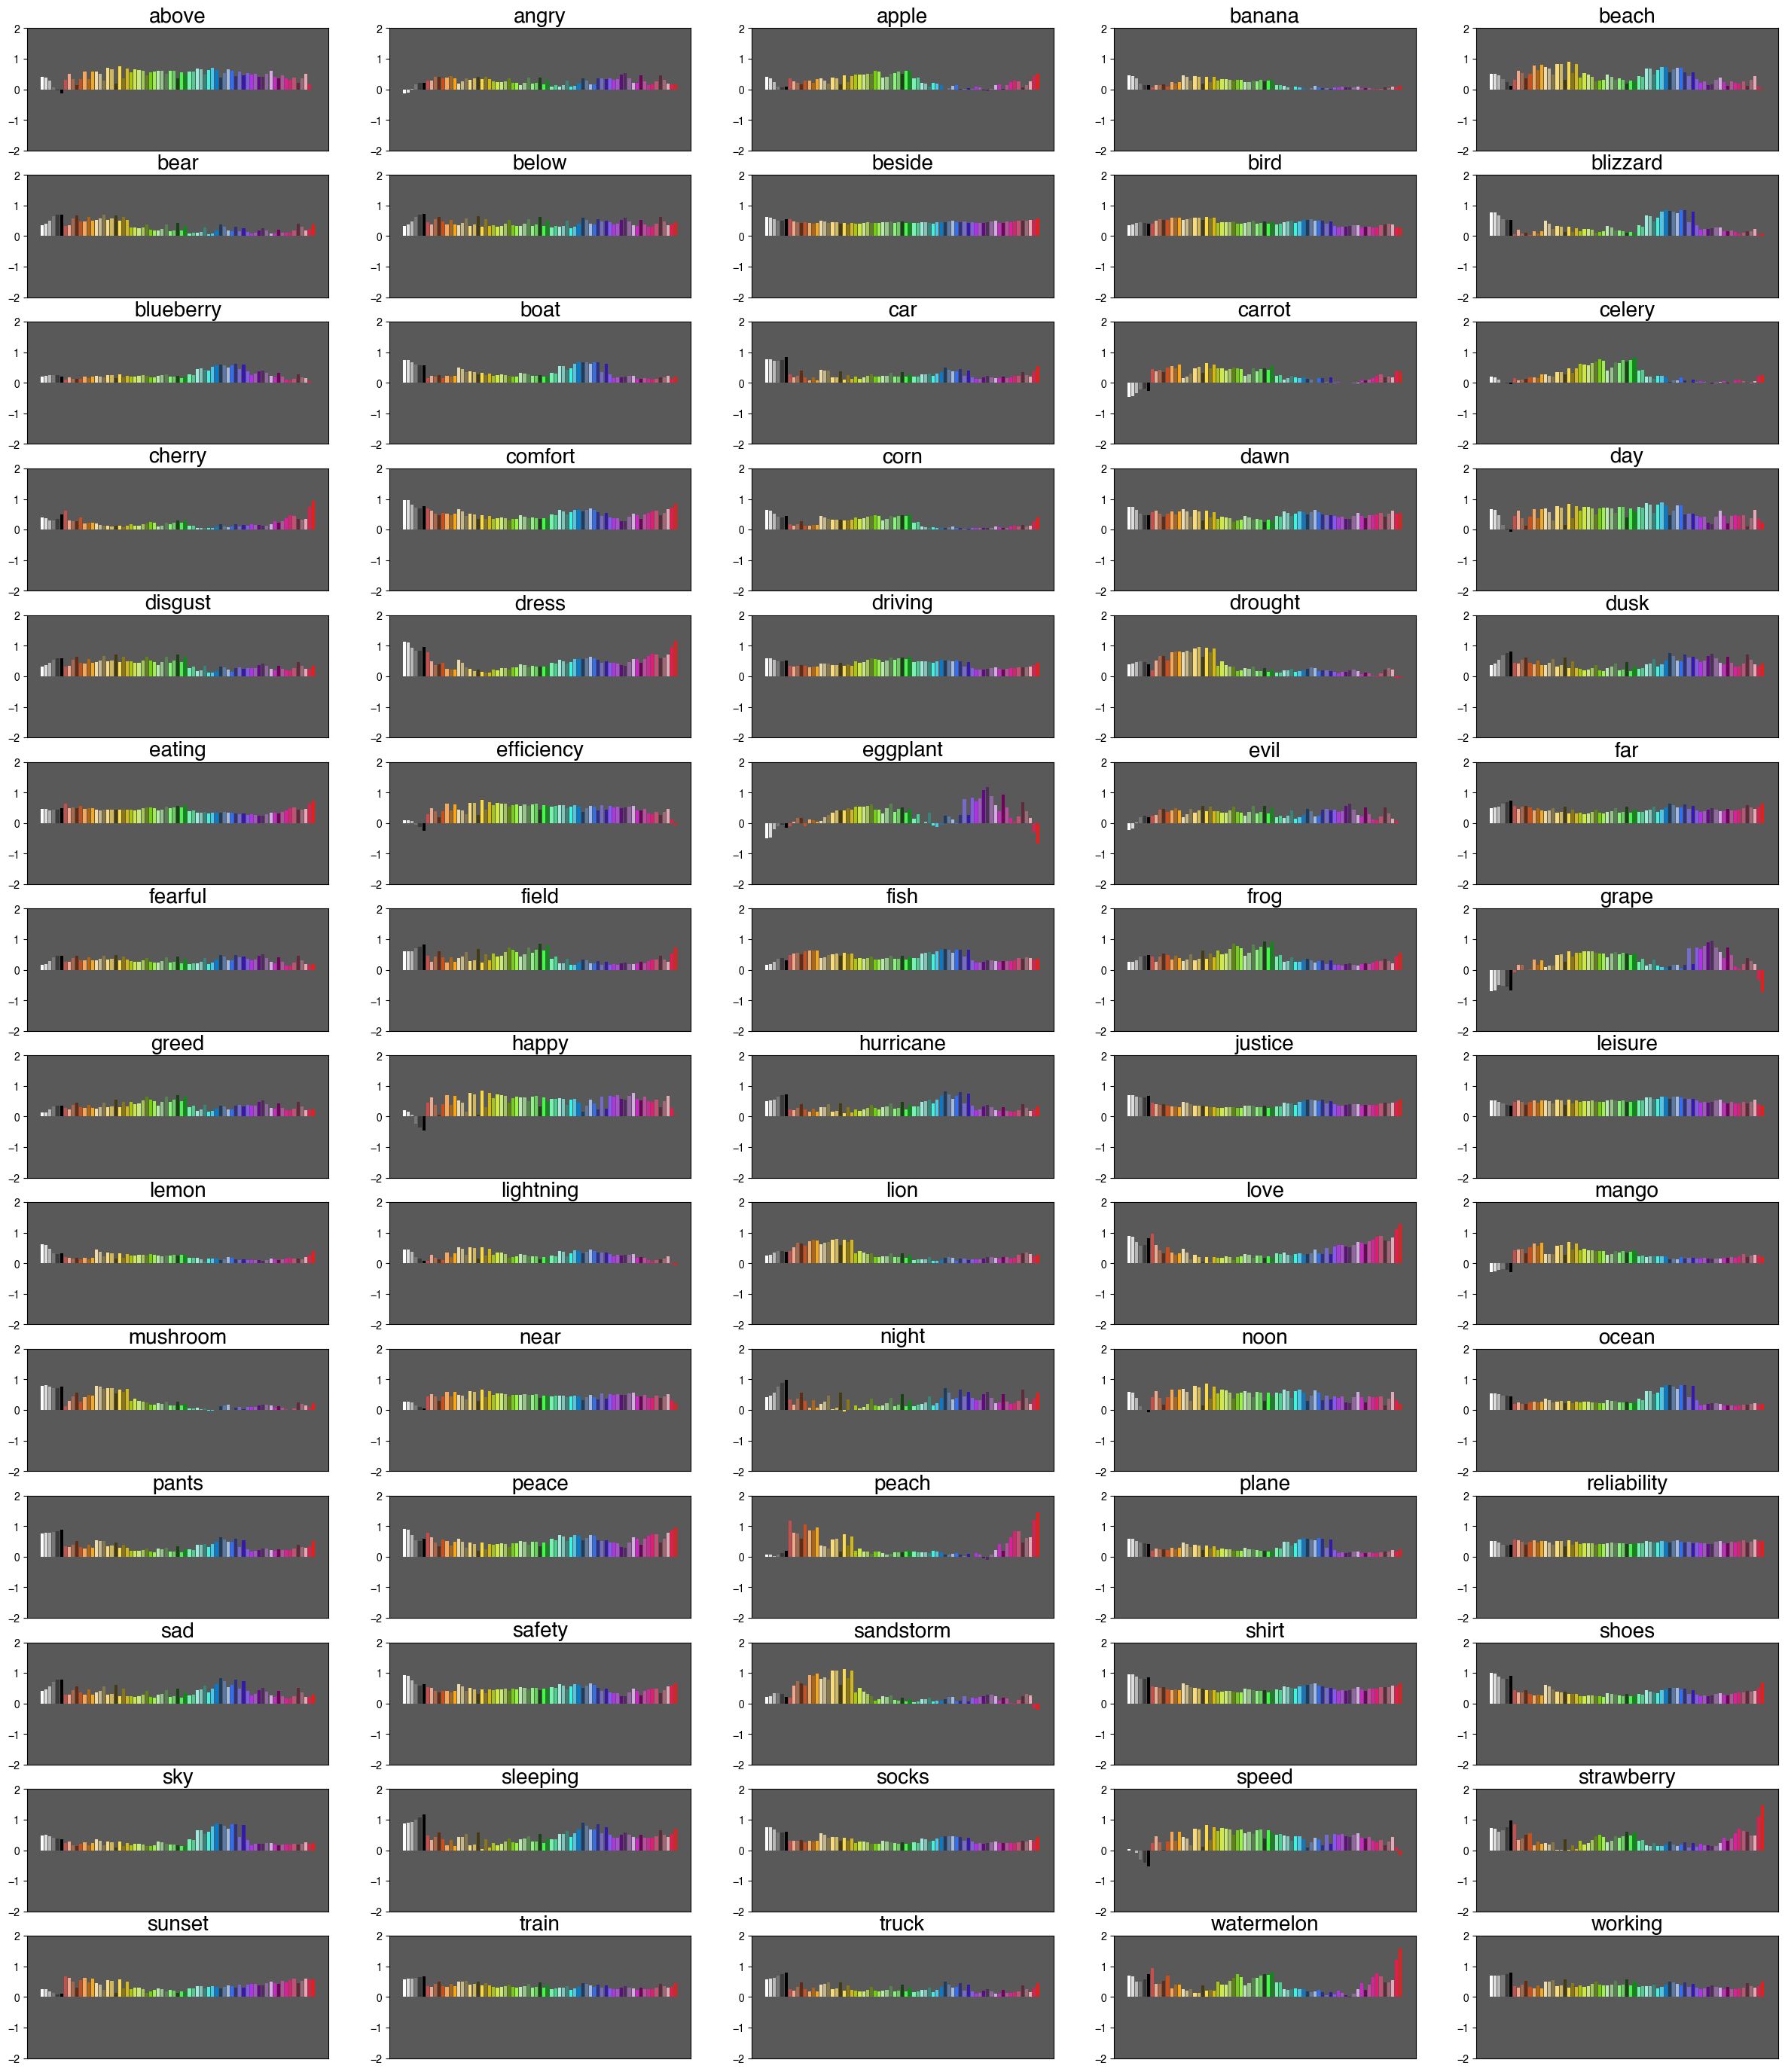

In [71]:
set_all_mean_cors, set_all_recon_ratings = reconstruct_assocs(set_all_mat,set_all_cmeans,'set_all',num_pc=7,holdout_mode=True,plot=False,compute_col_inds=11)
set_all_mean_cors.holdout_cor.mean()


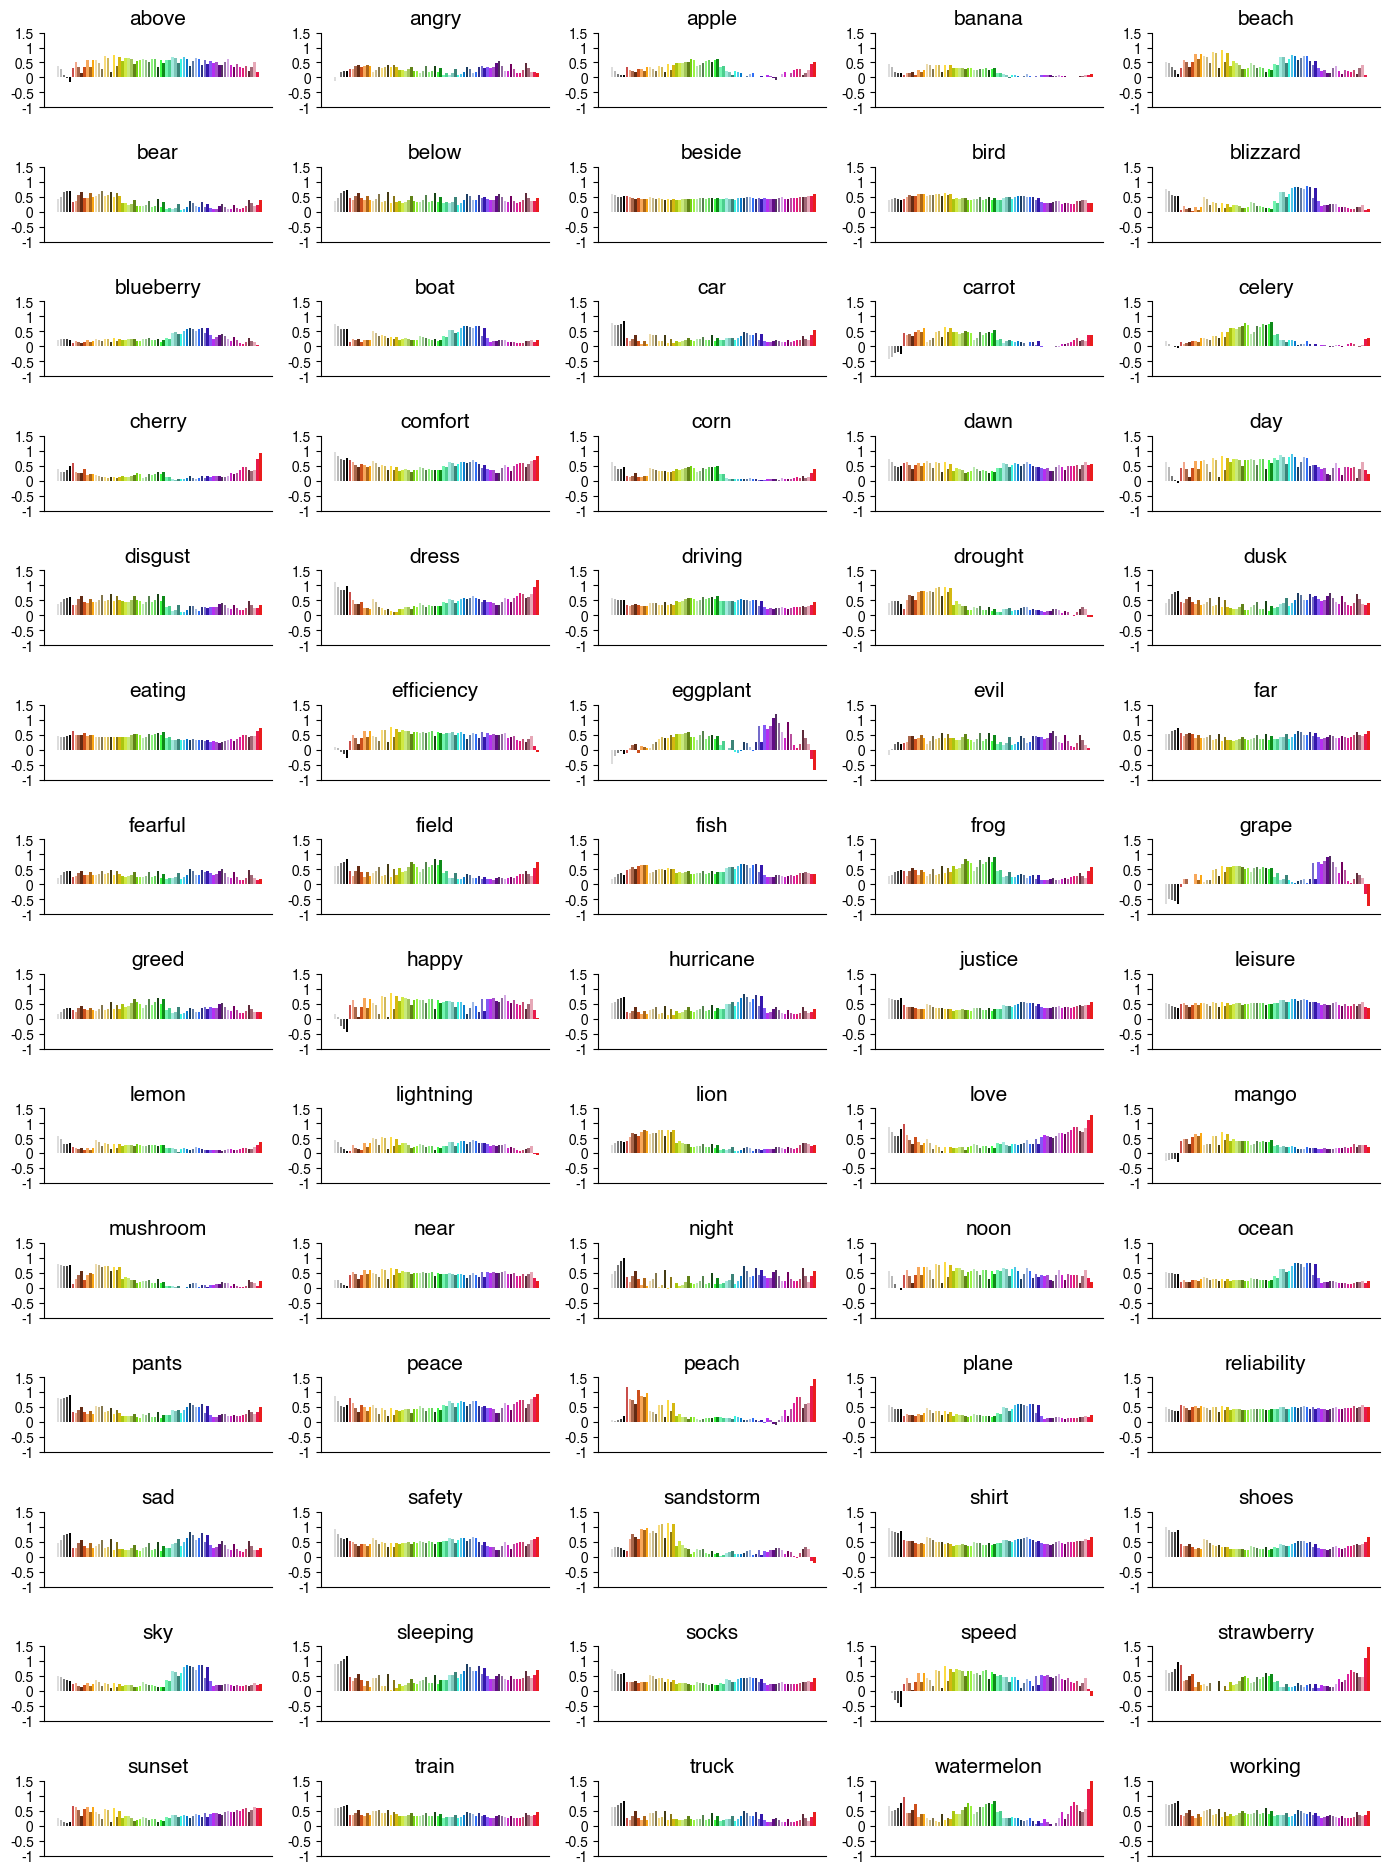

In [96]:
set_all_recon_wide = set_all_recon_ratings.pivot(index='concept', columns='color_index', values='recon_rating').reset_index()   

gpt_rate_fig = plt.figure(constrained_layout=True, figsize=(14,19))
gs = gpt_rate_fig.add_gridspec(14, 10)
for i in range(14):
    for j in range(5):
        # if (2*i)+j > 69:
        #     break
        ratings_ax = gpt_rate_fig.add_subplot(gs[i, (2*j):2+(2*j)])

        ratings_ax.bar(np.arange(71),set_all_recon_wide.iloc[(5*i)+j,sorted_col_order+1].values +set_all_cmeans[sorted_col_order], color = uw71coords.iloc[sorted_col_order,:]['color_hex'].values, edgecolor='None')
        ratings_ax.set_ylim([-1,1.5])
        ratings_ax.set_title(set_all_recon_wide.concept.values[(5*i)+j], fontsize=15)
        ###move the title down a bit
        ratings_ax.title.set_position([.5, 1.05])
        ### add some padding between different rows of subplots
        plt.tight_layout(h_pad=2)
        ### reduce the horizontal space between subplots
        # plt.subplots_adjust(wspace=.2)
        ### remove the x ticks
        ratings_ax.set_xticks([])
        ratings_ax.set_yticks([-1,-0.5, 0, 0.5, 1, 1.5])
        ratings_ax.set_yticklabels(['-1','-0.5', '0', '0.5', '1', '1.5'], fontsize=10)
        sns.despine(ax=ratings_ax)
        ### set the facecolor to white
        ratings_ax.set_facecolor((1,1,1))

plt.savefig('../../plots/exp2b_pred_dists.pdf',format ='pdf',bbox_inches='tight')

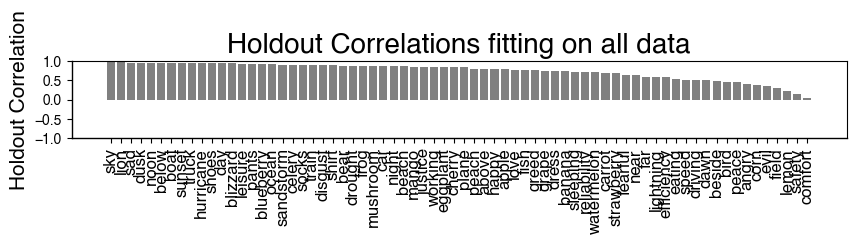

In [72]:


set_all_mean_cors = set_all_mean_cors.sort_values(by='holdout_cor',ascending=False).reset_index(drop=True)


plt.figure(figsize=(10,1))
plt.bar(np.arange(set_all_mean_cors.shape[0]),set_all_mean_cors.holdout_cor,color='gray')
plt.xticks(np.arange(set_all_mean_cors.shape[0]),set_all_mean_cors.concept,rotation=90,fontsize=12)
plt.yticks(fontsize=10)
plt.ylabel('Holdout Correlation',fontsize=15)
# plt.xlabel('Concept',fontsize=5)
plt.title('Holdout Correlations fitting on all data',fontsize=20)
plt.ylim(-1,1)
plt.yticks([-1,-.5,0,.5,1])
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
plt.savefig('../../data/recon_assocs/set_all_cor_barplot.pdf',format='pdf',bbox_inches='tight')

In [73]:
print(f' mean correlation = {set_all_mean_cors.holdout_cor.mean()}')
print(f' sd correlation = {set_all_mean_cors.holdout_cor.std()}')

 mean correlation = 0.7459774171236491
 sd correlation = 0.21836811076335855


In [ ]:
set_all_mean_cors



In [ ]:

set_all_mean_cors['pvals'] = set_all_mean_cors['pvals'].astype(float)
set_all_mean_cors['pvals_corrected'] = multipletests(set_all_mean_cors['pvals'],method='holm')[1]
set_all_mean_cors['sig'] = set_all_mean_cors['pvals_corrected']<.05

In [ ]:
set_all_mean_cors.tail(15)

In [ ]:

non_combined_rs = holdout_concept_cors.sort_values('concept')
print(f' exp 2a mean correlation = {non_combined_rs.holdout_cor.mean()}') 
print(f' sd = {non_combined_rs.holdout_cor.std()}')


combined_rs = set_all_mean_cors[set_all_mean_cors.concept.isin(holdout_concept_cors.concept)].sort_values('concept')
print(f' exp 2b mean correlation = {combined_rs.holdout_cor.mean()}')
print(f' sd = {combined_rs.holdout_cor.std()}')



In [ ]:
## do a t-test between the two groups and import t-test function from scipy.stats
combined_rs['holdout_cor'] = np.arctanh(combined_rs['holdout_cor'])
non_combined_rs['holdout_cor'] = np.arctanh(non_combined_rs['holdout_cor'])
# ttest_rel( combined_rs.sort_values(by='concept').holdout_cor,np.arctanh(holdout_concept_cors.sort_values(by='concept').holdout_cor))
ttest_rel( combined_rs.holdout_cor,non_combined_rs.holdout_cor)

In [ ]:
set1_non_combined_rs = holdout_concept_cors_set1.sort_values('concept')
set1_combined_rs = set_all_mean_cors[set_all_mean_cors.concept.isin(holdout_concept_cors_set1.concept)].sort_values('concept')

set1_non_combined_rs['holdout_cor'] = np.arctanh(set1_non_combined_rs['holdout_cor'])
set1_combined_rs['holdout_cor'] = np.arctanh(set1_combined_rs['holdout_cor'])   
ttest_rel(set1_combined_rs.sort_values(by='concept').holdout_cor,set1_non_combined_rs.sort_values(by='concept').holdout_cor)


In [ ]:
plot_true_pred_assocs(set_all_grouped,set_all_mat,set_all_cmeans,'set_all',num_pc=7,holdout_mode=True,compute_col_inds=None) ##changed from 11 here

In [ ]:
# for this_num in range(4,9):
#     print(f'Using a {this_num} dimensional space')
#     _=vary_colors_jb(set_all_mat,set_all_cmeans,basis_vecs_all,num_pc=this_num)

## Osgood semantic differentials analyis

In [131]:
sem_diff_csvs = [f for f in os.listdir('/Users/kushinm/Documents/Github/semantic_spaces/data/semantic_differentials') if f != '.DS_Store']
### read the csvs and combine them into one dataframe

sem_diff_df = pd.concat([pd.read_csv(f'/Users/kushinm/Documents/Github/semantic_spaces/data/semantic_differentials/{f}') for f in sem_diff_csvs]).reset_index(drop=True)

In [ ]:
sem_diff_df

In [132]:

import json

tmp = sem_diff_df[sem_diff_df.trial_type=='survey-text']
# Convert string to dict and extract Age
Ages = tmp['response'].apply(lambda x: float(json.loads(x)['Age']) if pd.notna(x) else None)
genders = tmp['response'].apply(lambda x: json.loads(x)['Gender'] if pd.notna(x) else None)


In [133]:
tmp['response']

4        {"Age":"19","Gender":"Female ","Race/ethnicity...
276      {"Age":"18","Gender":"Female","Race/ethnicity"...
544      {"Age":"19","Gender":"Genderqueer","Race/ethni...
752      {"Age":"19","Gender":"Female","Race/ethnicity"...
1022     {"Age":"18","Gender":"Female ","Race/ethnicity...
                               ...                        
85214    {"Age":"18","Gender":"Male","Race/ethnicity":"...
85422    {"Age":"19","Gender":"Male","Race/ethnicity":"...
85690    {"Age":"18","Gender":"female","Race/ethnicity"...
85958    {"Age":"18","Gender":"male","Race/ethnicity":"...
86226    {"Age":"18","Gender":"female","Race/ethnicity"...
Name: response, Length: 361, dtype: object

In [134]:
127+83+7+6+6+5+2+1+1+1+ 1+ 1

241

In [ ]:
### for sem_diff_df get the number of unique subject_ids in each condition_num
sem_diff_df.groupby('concept').subject_id.nunique()

##print all the unique sona ids
# sem_diff_df.sona_id.unique()

In [136]:
sem_diff_ratings = sem_diff_df[sem_diff_df['trial_type']=='html-slider-response']
sem_diff_ratings = sem_diff_ratings[sem_diff_ratings['practiceTrial']!=True]
sem_diff_ratings['response'] = (sem_diff_ratings['response'].astype(float)+200)/(400)
### from sem_diff_ratings select only the columns subject_id, concept, scale, and response
sem_diff_ratings = sem_diff_ratings[['subject_id','concept','scale','response']]
sem_diff_ratings_grouped = sem_diff_ratings.groupby(['concept','scale'], as_index=False)['response'].mean().reset_index(drop=True)
### pivot the table so that the rows are concepts and the columns are scales
sem_diff_ratings_pivot = sem_diff_ratings_grouped.pivot(index='concept',columns='scale',values='response').reset_index()





### compute an svd on this matrix
sem_diff_ratings_mat = sem_diff_ratings_pivot.iloc[:,1:].values
sem_diff_ratings_cmeans = sem_diff_ratings_mat.mean(axis=0)


### compute the item x item correlation matrix for the set1_mat
set1_mat_cormat = np.corrcoef(set1_mat)


### now do the same for the semantic differential ratings
sem_diff_ratings_cormat = np.corrcoef(sem_diff_ratings_mat)



U_sem_diff,S_sem_diff,Vh_sem_diff = svd((sem_diff_ratings_mat-sem_diff_ratings_cmeans), full_matrices=False)
factor_mat_sem_diff = U_sem_diff @ np.diag(S_sem_diff)
basis_vecs_sem_diff = Vh_sem_diff

# U_sem_diff,S_sem_diff,Vh_sem_diff = svd(sem_diff_ratings_cormat- sem_diff_ratings_cormat.mean(axis=0), full_matrices=False)
# factor_mat_sem_diff = U_sem_diff @ np.diag(S_sem_diff)
# basis_vecs_sem_diff = Vh_sem_diff

# U_exp1,S_exp1,Vh_exp1 =  svd(set1_mat_cormat - set1_mat_cormat.mean(axis=0), full_matrices=False)
# factor_mat_exp1 = U_exp1 @ np.diag(S_exp1)
# basis_vecs_exp1 = Vh_exp1


In [137]:
# Count unique raters per scale
scale_counts = sem_diff_ratings.groupby('scale')['subject_id'].nunique().reset_index()
scale_counts = scale_counts.rename(columns={'subject_id': 'n_raters'})

# Create LaTeX table string
latex_table = """\\begin{table}[h]
\\centering
\\begin{tabular}{lr}
\\hline
Scale & \\# Raters \\\\
\\hline
"""

# Add each row
for _, row in scale_counts.iterrows():
    latex_table += f"{row['scale']} & {row['n_raters']} \\\\\n"

# Close table
latex_table += """\\hline
\\end{tabular}
\\caption{Number of unique raters per semantic differential scale}
\\label{tab:scale_raters}
\\end{table}"""

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{lr}
\hline
Scale & \# Raters \\
\hline
agitated vs. calm & 38 \\
awful vs. nice & 44 \\
bad vs. good & 38 \\
bitter vs. sweet & 41 \\
black vs. white & 47 \\
bland vs. pungent & 40 \\
cowardly vs. brave & 33 \\
cruel vs. kind & 47 \\
dark vs. bright & 43 \\
dead vs. alive & 38 \\
delicate vs. rugged & 40 \\
dirty vs. clean & 38 \\
distasteful vs. tasty & 38 \\
dry vs. wet & 41 \\
dull vs. sharp & 41 \\
empty vs. full & 41 \\
ferocious vs. peaceful & 41 \\
foul vs. fragrant & 43 \\
freezing vs. burning & 37 \\
hard vs. soft & 38 \\
hazy vs. clear & 33 \\
hellish vs. heavenly & 38 \\
light vs. heavy & 41 \\
little vs. big & 44 \\
low vs. high & 37 \\
mild vs. harsh & 37 \\
narrow vs. wide & 40 \\
old vs. young & 38 \\
passive vs. active & 43 \\
poor vs. rich & 33 \\
powerless vs. poweful & 44 \\
profane vs. sacred & 33 \\
quiet vs. noisy & 44 \\
red vs. green & 47 \\
rounded vs. angular & 43 \\
sad vs. happy & 37 \\
shallow vs. deep & 38 \\
sho

In [138]:
sem_diff_ratings_mat.shape

(70, 54)

In [139]:
scale_by_component_cormat = np.zeros((sem_diff_ratings_mat.shape[1],3))

for i,colname in enumerate(sem_diff_ratings_pivot.columns[1:]):
    for j in range(3):
        scale_by_component_cormat[i,j] = pearsonr(sem_diff_ratings_mat[:,i],factor_mat_sem_diff[:,j])[0]**2

In [140]:
scale_by_component_df = pd.DataFrame(scale_by_component_cormat,columns=['comp1','comp2','comp3'],index=sem_diff_ratings_pivot.columns[1:]).reset_index()
scale_by_component_df

## sort scale_by_component_df by comp1, comp2, and comp3 and print the scales in order of importance for each component and the value in the respective column



# Function to print top 6 scales and their values for a given component
def print_top_scales(component):
    sorted_df = scale_by_component_df.sort_values(by=component, ascending=False).head(6)
    print(f'{component}')
    for i, row in sorted_df.iterrows():
        print(f"{row['scale']}: {row[component]:.4f}")
    print()

print_top_scales('comp1')
print_top_scales('comp2')
print_top_scales('comp3')


comp1
bitter vs. sweet: 0.9222
agitated vs. calm: 0.9000
unpleasant vs. pleasant: 0.9000
ferocious vs. peaceful: 0.8885
awful vs. nice: 0.8820
cruel vs. kind: 0.8810

comp2
powerless vs. poweful: 0.8144
weak vs. strong: 0.8069
little vs. big: 0.7448
passive vs. active: 0.6933
low vs. high: 0.5993
dull vs. sharp: 0.4244

comp3
shallow vs. deep: 0.3661
unknown vs. known: 0.3615
yellow vs. blue: 0.3069
short vs. long: 0.2570
quiet vs. noisy: 0.2167
narrow vs. wide: 0.2120



In [144]:
factor_mat_sem_diff[:,0].shape
sem_diff_ratings_mat[:,0].shape

(70,)

Text(0.5, 0, 'Correlation')

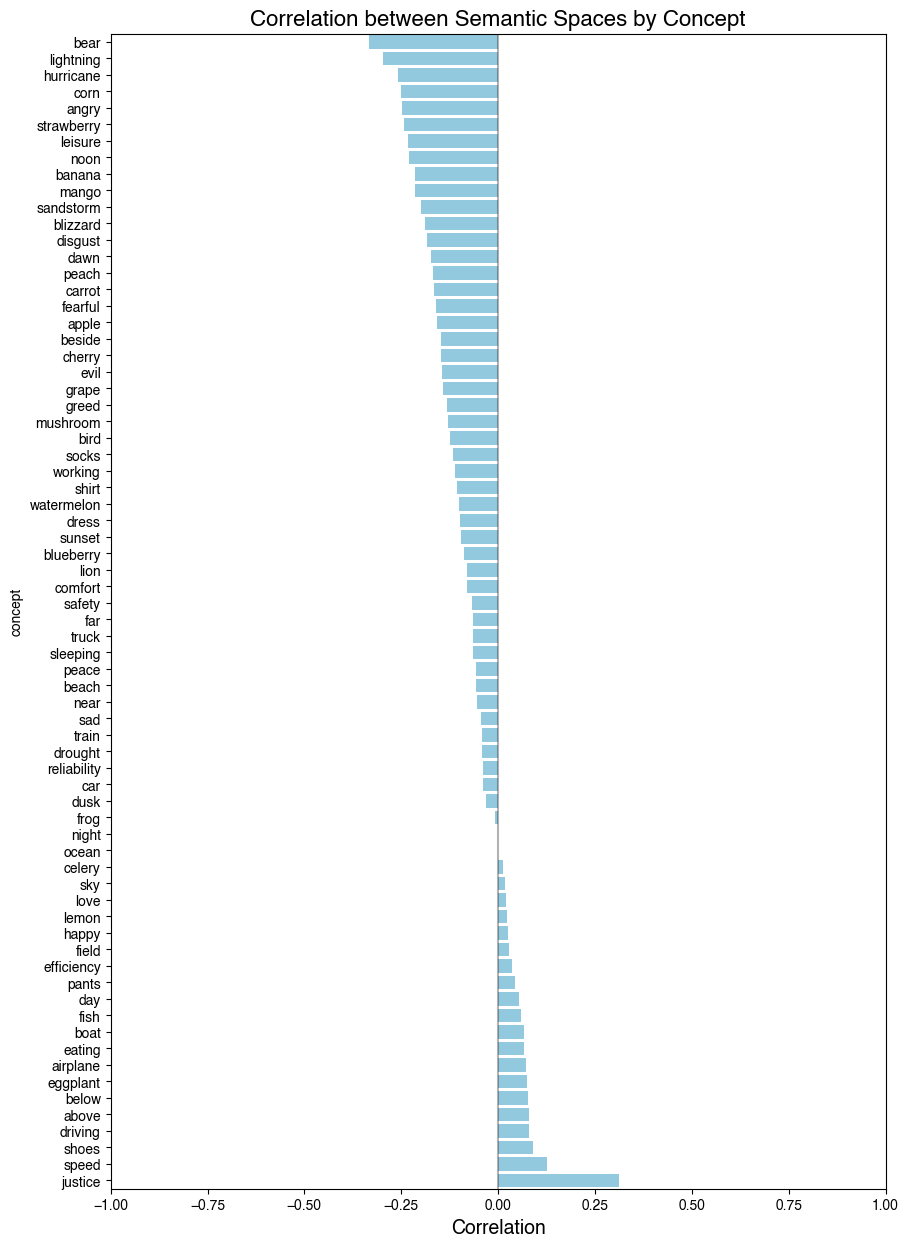

In [145]:

# Compute correlations for each row (concept)
correlations = []
for i in range(factor_mat_sem_diff.shape[0]):
    corr = pearsonr(factor_mat_sem_diff[i,:], sem_diff_ratings_mat[i,:])[0]
    correlations.append(corr)

# Create dataframe with correlations and concepts
corr_df = pd.DataFrame({
    'concept': sem_diff_ratings_pivot['concept'],
    'correlation': correlations
})

# Sort by correlation value
corr_df = corr_df.sort_values('correlation')

# Create horizontal barplot
plt.figure(figsize=(10, 15))
sns.barplot(data=corr_df, 
            y='concept', 
            x='correlation',
            color='skyblue')

# Format plot
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlim(-1, 1)
plt.title('Correlation between Semantic Spaces by Concept', fontsize=16)
plt.xlabel('Correlation', fontsize=14)

In [146]:
factor_mat_all

array([[ 9.71188647e-01, -9.82725948e-01,  2.59149374e-01, ...,
         5.62434134e-04,  5.80725510e-04, -7.38309693e-17],
       [-6.72565882e-01,  4.58296246e-01, -4.46215992e-01, ...,
         1.74001197e-03,  4.79002725e-04, -7.38309693e-17],
       [-1.44978475e+00, -6.88928959e-01, -2.87960216e-01, ...,
        -1.68187037e-04,  2.16155738e-04, -7.38309693e-17],
       ...,
       [-2.17960915e-01,  1.31739458e+00,  1.30477871e-01, ...,
         1.33106665e-03, -6.65643138e-04, -7.38309693e-17],
       [-7.41462383e-01, -1.15061384e+00, -7.42065912e-01, ...,
        -1.48082936e-05, -1.42072123e-03, -7.38309693e-17],
       [ 3.14116079e-01,  2.25697974e-01, -1.11646787e-01, ...,
         2.14279022e-03, -5.53284896e-04, -7.38309693e-17]])

In [147]:

# # Compute angles and distances
# x = factor_mat_all[:, 0]  
# y = factor_mat_all[:, 1]  

# angles = np.degrees(np.arctan2(y, x)) % 360
# distances = np.sqrt(x**2 + y**2)
# distances_norm = distances / np.max(distances)

# # Create colors array
# colors = []
# for angle, dist in zip(angles, distances_norm):
#     hue = angle / 360
#     saturation = dist
#     value = 0.9
#     rgb = hsv_to_rgb(hue, saturation, value)
#     colors.append(rgb)

# # Create scatter plot
# plt.figure(figsize=(10, 10))
# plt.scatter(x, y, c=colors, s=800)  # Increased marker size

# # Add index numbers
# for idx, (x_val, y_val) in enumerate(zip(x, y)):
#     plt.text(x_val, y_val, str(idx+1), 
#              horizontalalignment='center',
#              verticalalignment='center',
#              color='white',
#              fontweight='bold',
#              path_effects=[pe.withStroke(linewidth=1, foreground="black")],
#              fontsize=15)

# plt.xlabel('component 1', fontsize=25)
# plt.ylabel('component 2', fontsize=25)
# plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
# plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.title('Color Concept Associations', fontsize=30)
# plt.xlim(-2.5,2.5)
# plt.ylim(-2.5,2.5)

# # plt.savefig('../../data/recon_assocs/exp3_cca.pdf',format='pdf',bbox_inches='tight')
# plt.tight_layout()
# plt.show()

In [148]:
all_concepts = set_all_mat.index.values.astype(str)
all_concepts_table_order = ['dress','pants','shirt','socks','shoes',
                            'blueberry','lemon','mango','strawberry','watermelon',
                            'beach','field','ocean','sky','sunset',
                            'angry','disgust','fearful','happy','sad',
                            'above','below','beside','near','far',
                            'dawn','day','dusk','noon','night',
                            'bear','bird','lion','fish','frog',
                            'plane','car','boat','truck','train',
                            'apple','banana','cherry','grape','peach',
                            'carrot','celery','corn','eggplant','mushroom',
                            'evil','greed','justice','love','peace',
                            'blizzard','drought','hurricane','lightning','sandstorm',
                            'driving','eating','sleeping','leisure','working',
                            'comfort','efficiency','reliability','safety','speed'
                            ]


mapping = {word: idx for idx, word in enumerate(all_concepts)}
reordered_indices = [mapping[word] for word in all_concepts_table_order]


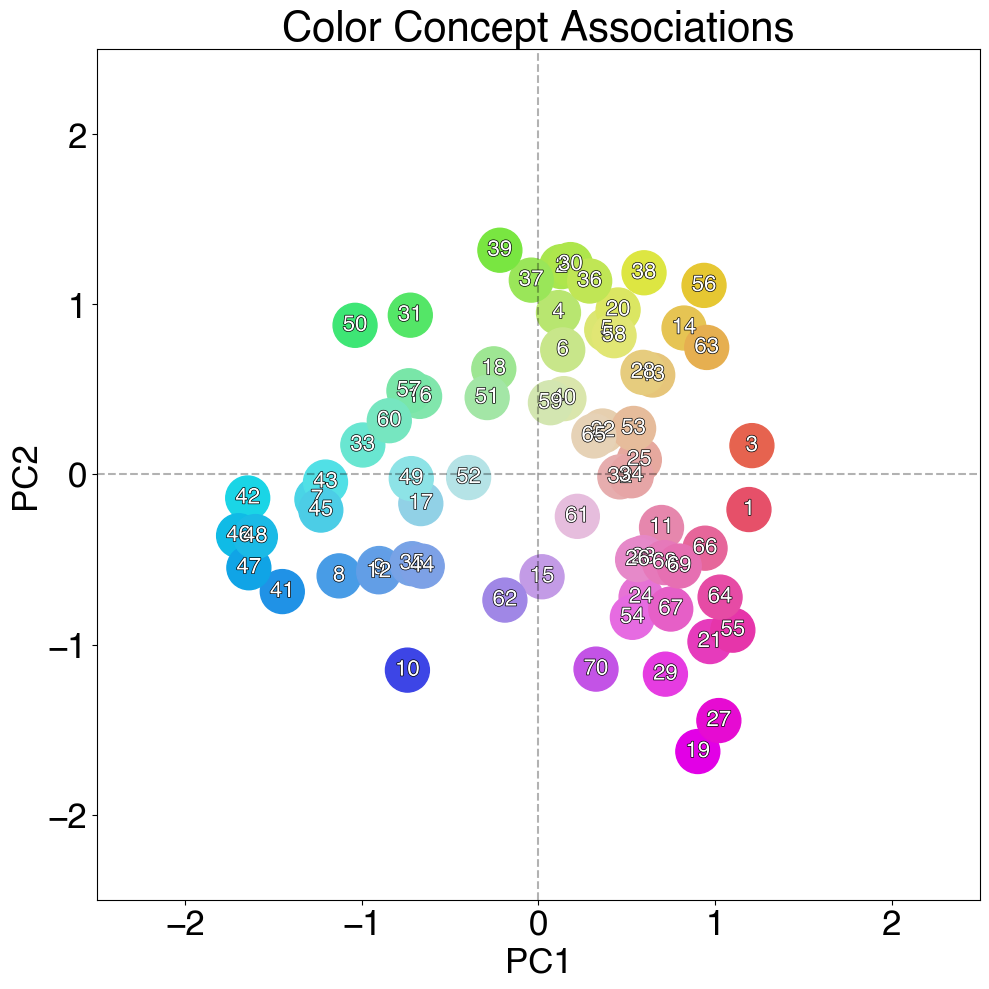

In [149]:

from colorsys import hsv_to_rgb
import matplotlib.patheffects as pe
# Compute angles and distances
x = factor_mat_all[reordered_indices, 0]  # First component
y = factor_mat_all[reordered_indices, 1]  # Second component

# Convert to angles (in degrees) and distances
angles = np.degrees(np.arctan2(y, x)) % 360  # Convert to 0-360 range
distances = np.sqrt(x**2 + y**2)

# Normalize distances to 0-1 for saturation
distances_norm = distances / np.max(distances)

# Create colors array
colors = []
for angle, dist in zip(angles, distances_norm):
    hue = angle / 360  # Convert to 0-1 range
    saturation = dist  # Use normalized distance
    value = 0.9       # Keep brightness constant
    rgb = hsv_to_rgb(hue, saturation, value)
    colors.append(rgb)
    

# Create scatter plot
plt.figure(figsize=(10, 10))
plt.gca().set_facecolor('white')
plt.scatter(x, y, c=colors, s=1000)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_color('black')


# Add index numbers
for idx, (x_val, y_val) in enumerate(zip(x, y)):
    plt.text(x_val, y_val, str(idx+1), 
             horizontalalignment='center',
             verticalalignment='center',
             color='white',
             fontweight='bold',
             path_effects=[pe.withStroke(linewidth=1, foreground="black")],
             fontsize=16)

plt.xlabel('PC1', fontsize=25)
plt.ylabel('PC2', fontsize=25)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title('Color Concept Associations', fontsize=30)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
# Make axes equal to preserve angles
# plt.axis('equal')
plt.savefig('../../data/recon_assocs/exp3_cca.pdf',format='pdf',bbox_inches='tight')

plt.tight_layout()
plt.show()

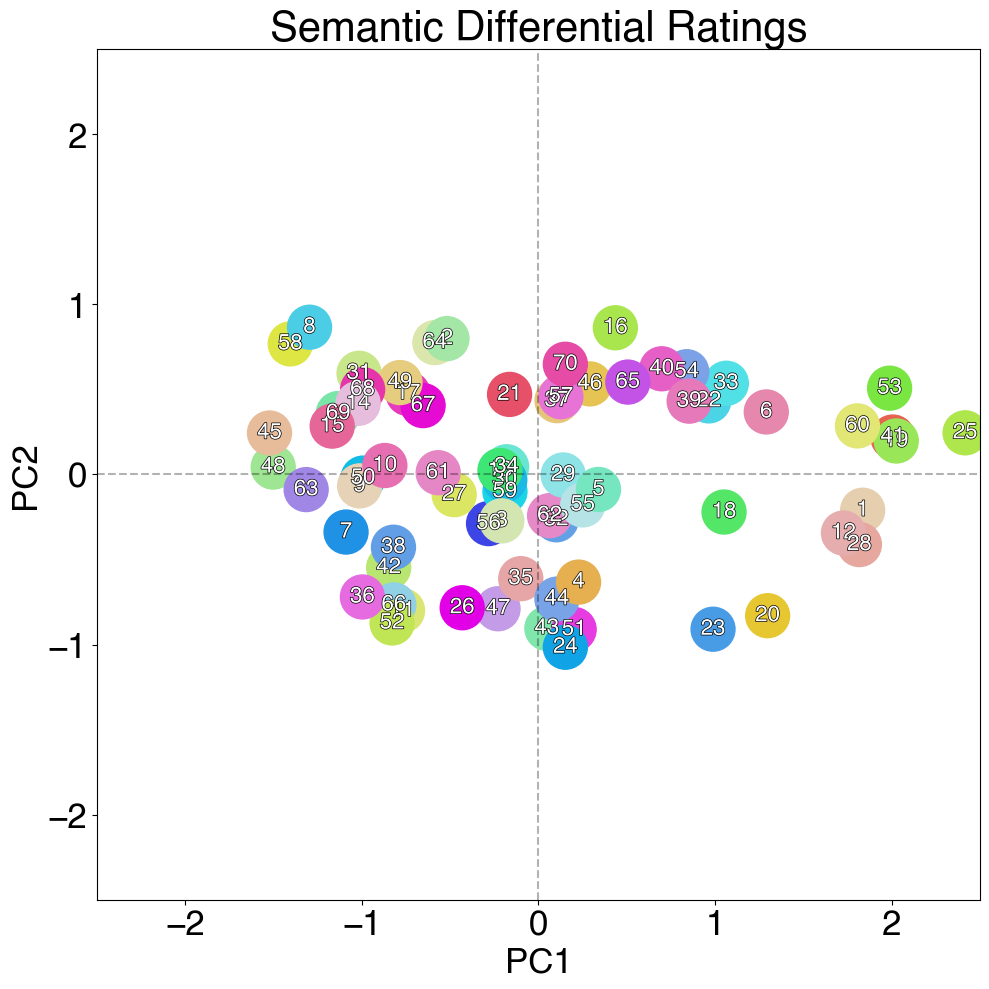

In [150]:
x = factor_mat_sem_diff[reordered_indices, 0]  # First component
y = factor_mat_sem_diff[reordered_indices, 1]  # Second component

### make a plot of each of the concepts in terms of their first two components
plt.figure(figsize=(10,10))
plt.gca().set_facecolor('white')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.scatter(factor_mat_sem_diff[:,0],factor_mat_sem_diff[:,1],c=colors, s=1000)
###make the background white 

# for i, txt in enumerate(set_all_mat.index.values):
#     plt.annotate(txt, (factor_mat_all[i,0] + 0.02, factor_mat_all[i,1] + 0.02))  # Offset the text annotations
plt.xlabel('PC1', fontsize=25)
plt.ylabel('PC2', fontsize=25)
plt.title('Semantic Differential Ratings',fontsize=30)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Add index numbers
for idx, (x_val, y_val) in enumerate(zip(x, y)):
    plt.text(x_val, y_val, str(idx+1), 
             horizontalalignment='center',
             verticalalignment='center',
             color='white',
             fontweight='bold',
             path_effects=[pe.withStroke(linewidth=1, foreground="black")],
             fontsize=16)


## set the font size of the axes ticks to be 20
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.savefig('../../data/recon_assocs/exp3_sem_diff.pdf',format='pdf',bbox_inches='tight')
plt.tight_layout()
plt.show()

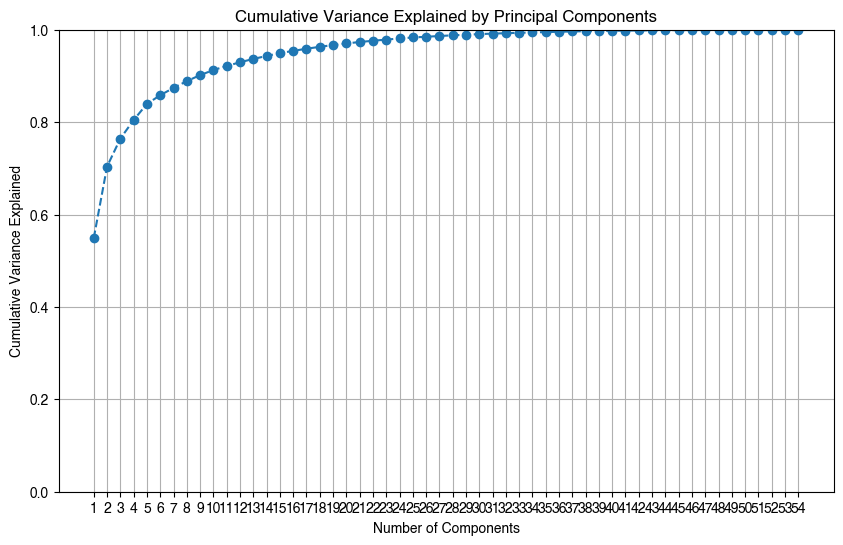

In [151]:

# Compute the variance explained by each component
variance_explained = (S_sem_diff ** 2) / np.sum(S_sem_diff ** 2)
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot the cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.xticks(range(1, len(cumulative_variance_explained) + 1))
plt.ylim(0, 1)
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()

In [152]:
print(cumulative_variance_explained)

[0.54891407 0.70375621 0.76431149 0.80449973 0.83943513 0.85820744
 0.87407116 0.88872946 0.9016953  0.91271174 0.92150457 0.92954939
 0.93675548 0.94318526 0.94924697 0.95418041 0.95884704 0.96296811
 0.96680619 0.97023792 0.97343053 0.97609905 0.97864478 0.98103875
 0.98317257 0.98478356 0.98638994 0.9878901  0.98923065 0.99047126
 0.99158324 0.99245957 0.99332018 0.99409988 0.99485114 0.99558176
 0.9962204  0.99676998 0.99729709 0.99771132 0.99808911 0.99840662
 0.9986959  0.9989558  0.99916659 0.99934386 0.99949422 0.99960934
 0.99972149 0.99981702 0.99988556 0.99993926 0.99997989 1.        ]


Text(0.5, 1.0, 'Scree Plot of Eigenvalues')

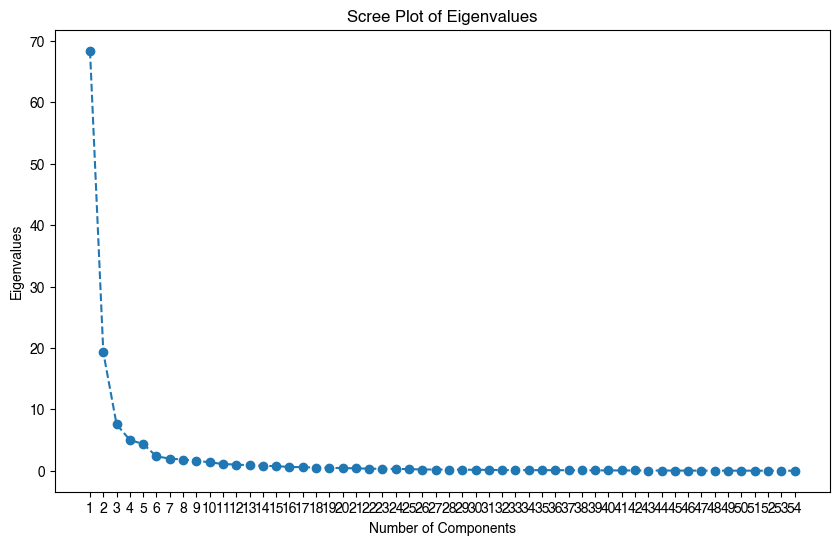

In [153]:
### now plot the eigenvalues in the form of a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(S_sem_diff) + 1), S_sem_diff ** 2, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.xticks(range(1, len(S_sem_diff) + 1))
plt.ylabel('Eigenvalues')
plt.title('Scree Plot of Eigenvalues')

cs component 2 and sd component 5 = 0.244
cs component 3 and sd component 5 = -0.276
cs component 4 and sd component 1 = -0.260
cs component 4 and sd component 5 = 0.273
cs component 6 and sd component 5 = -0.331


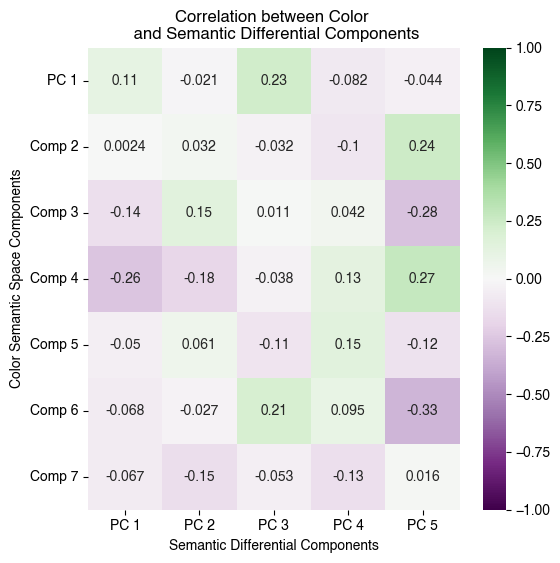

In [154]:



# ### compute a classical mds on both 
# from sklearn.manifold import MDS
# mds = MDS(n_components=3, dissimilarity='precomputed')
# set1_mds = mds.fit_transform(1-set1_mat_cormat)
# sem_diff_mds = mds.fit_transform(1-sem_diff_ratings_cormat)

# ### okay now compute the correlation between set1_mds and sem_diff_mds, the result should be a 3x3 matrix

# # sem_diff_x_color_semantic_cor = np.corrcoef(set1_mds.T,sem_diff_mds.T)


# Initialize an empty 3x3 matrix to store the correlation values
sem_diff_x_color_semantic_cor = np.empty((7, 5))

# Compute the correlation for each pair of columns
for i in range(7):
    for j in range(5):
        sem_diff_x_color_semantic_cor[i, j] = pearsonr(factor_mat_all[:, i], factor_mat_sem_diff[:, j])[0]
        ### if statistically significant, then print the correlation value
        if pearsonr(factor_mat_all[:, i], factor_mat_sem_diff[:, j])[1] < .05:
            print(f'cs component {i+1} and sd component {j+1} = {sem_diff_x_color_semantic_cor[i, j]:.3f}')
        


plt.figure(figsize=(6, 6))
sns.heatmap(sem_diff_x_color_semantic_cor, annot=True, cmap='PRGn', cbar=True,center=0, vmax=1, vmin=-1)
### add a colorbar

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5], labels=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'], rotation=0)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5,5.5,6.5], labels=['PC 1', 'Comp 2', 'Comp 3','Comp 4','Comp 5','Comp 6','Comp 7'], rotation=0)
plt.title('Correlation between Color \n and Semantic Differential Components')
plt.xlabel('Semantic Differential Components')
plt.ylabel('Color Semantic Space Components')


plt.show()

In [155]:
from scipy.spatial import procrustes

In [156]:
factor_mat_all_7d = factor_mat_all[:,0:7]
factor_mat_sem_diff_7d = factor_mat_sem_diff[:,0:7]

In [157]:
# ### save out both matrices as csvs
# factor_mat_all_7d_df = pd.DataFrame(factor_mat_all_7d)
# factor_mat_all_7d_df.to_csv('../../data/factor_mat_all_7d.csv')
# factor_mat_sem_diff_7d_df = pd.DataFrame(factor_mat_sem_diff_7d)
# factor_mat_sem_diff_7d_df.to_csv('../../data/factor_mat_sem_diff_7d.csv')


In [158]:
m1,m2,disparity = procrustes(factor_mat_all_7d, factor_mat_sem_diff_7d)

In [159]:

procrustes_corr = np.sqrt(1-disparity)

The Procrustes Cor is thus $1 - \sum(x_1 - x_2)^2$

0.9393489433170882

In [164]:
np.random.seed(42)  # Set your desired seed value here

n_permutations = 10000  # You can increase this for a more precise p-value (e.g., 5000 or 10000)
null_disparities = np.zeros(n_permutations)

# Use a copy of the matrix to shuffle
shuffled_mat = factor_mat_sem_diff_7d.copy()

for i in tqdm(range(n_permutations), desc="Running Permutation Test"):
    # Shuffle the rows of one matrix to break the concept-to-concept correspondence
    np.random.shuffle(shuffled_mat)
    
    # Calculate the Procrustes disparity for the shuffled data
    _, _, null_disp = procrustes(factor_mat_all_7d, shuffled_mat)
    null_disparities[i] = null_disp

# 3. Calculate the p-value
# The p-value is the proportion of null disparities that are less than or equal to the observed one.
# A smaller disparity means a better fit.
p_value = np.mean(null_disparities >= disparity)

print(f"\nPermutation test p-value: {p_value}")

if p_value < 0.05:
    print("The observed disparity is statistically significant.")
else:
    print("The observed disparity is not statistically significant.")


Running Permutation Test: 100%|██████████| 10000/10000 [00:00<00:00, 12089.47it/s]


Permutation test p-value: 0.8139
The observed disparity is not statistically significant.


In [169]:

def procrustes_permutation_test(X, Y, n_permutations=1000):
    """
    Performs a permutation test for Procrustes disparity.

    Args:
        X (np.ndarray): First matrix of shape (n_points, n_dims).
        Y (np.ndarray): Second matrix of shape (n_points, n_dims).
        n_permutations (int): The number of permutations to perform.

    Returns:
        tuple: A tuple containing:
            - observed_disparity (float): The disparity for the original data.
            - p_value (float): The calculated p-value.
            - null_disparities (np.ndarray): The array of disparities from permutations.
    """
    # 1. Ensure data is in the correct format (centered)
    X = X - np.mean(X, 0)
    Y = Y - np.mean(Y, 0)

    # 2. Calculate the OBSERVED disparity
    _, _, observed_disparity = procrustes(X, Y)

    # 3. Create the NULL distribution
    null_disparities = np.zeros(n_permutations)
    Y_shuffled = Y.copy()

    for i in range(n_permutations):
        # Shuffle the rows of one matrix to break correspondence
        shuffled_indices = np.random.permutation(len(Y_shuffled))
        _, _, disparity = procrustes(X, Y_shuffled[shuffled_indices])
        null_disparities[i] = disparity

    # 4. Calculate the p-value
    # Count how many null disparities are less than or equal to the observed one
    count = np.sum(null_disparities <= observed_disparity)
    
    # Add 1 to numerator and denominator for a conservative p-value
    p_value = (count + 1) / (n_permutations + 1)

    return observed_disparity, p_value, null_disparities


n_points = 50
n_dims = 3

# Generate two completely random point clouds. We expect NO relationship.
tensor1 = np.random.rand(n_points, n_dims)
tensor2 = np.random.rand(n_points, n_dims)

# Perform the test
observed_disparity, p_value, _ = procrustes_permutation_test(tensor1, tensor2)

print(f"Observed Procrustes Disparity (m^2): {observed_disparity:.4f}")
print(f"P-value from permutation test: {p_value:.4f}\n")

# --- Interpretation ---
alpha = 0.05
if p_value < alpha:
    print(f"Result is SIGNIFICANT (p < {alpha}).")
    print("We REJECT the null hypothesis. The two spaces have a statistically significant relationship.")
else:
    print(f"Result is NOT SIGNIFICANT (p >= {alpha}).")
    print("We FAIL TO REJECT the null hypothesis. The observed alignment is consistent with random chance.")
    print("This supports your goal of showing no meaningful relation between the spaces. ✅")



Observed Procrustes Disparity (m^2): 0.9718
P-value from permutation test: 0.7522

Result is NOT SIGNIFICANT (p >= 0.05).
We FAIL TO REJECT the null hypothesis. The observed alignment is consistent with random chance.
This supports your goal of showing no meaningful relation between the spaces. ✅


In [ ]:
sem_diff_x_color_semantic_cor = np.empty((7, 7))

# Compute the correlation for each pair of columns
for i in range(7):
    for j in range(7):
        sem_diff_x_color_semantic_cor[i, j] = pearsonr(m1[:, i], m2[:, j])[0]
        ### if statistically significant, then print the correlation value
        if pearsonr(m1[:, i], m2[:, j])[1] < .05:
            print(f'cs component {i+1} and sd component {j+1} = {sem_diff_x_color_semantic_cor[i, j]:.3f}')
        


plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(sem_diff_x_color_semantic_cor, annot=False, cmap='PRGn', cbar=True,center=0, vmax=1, vmin=-1, linewidths=1, linecolor='black')



plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5,5.5,6.5], labels=['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7'], rotation=0, fontsize=20)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5,5.5,6.5], labels=['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7'], rotation=0, fontsize=20)
# plt.title('Correlation between Aligned Color \n and Semantic Differential Components')

# Get colorbar and modify tick labels
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)  # Adjust font size here

plt.xlabel('EPA Space', fontsize=25)
plt.ylabel('Color Semantic Space',fontsize=25)
plt.savefig('../../data/recon_assocs/exp3_cor_heatmap.pdf',format='pdf',bbox_inches='tight')
### make the font of the ticks on the colorbar larger



In [179]:

def compute_null_distribution(factor_mat_all_7d, factor_mat_sem_diff_7d, n_iter=500):
    # Initialize array to store null correlations
    null_correlations = np.zeros((n_iter, m1.shape[1], m2.shape[1]))
    
    # For each iteration
    for i in tqdm(range(n_iter)):
        # Sample with replacement from original matrices
        factor_mat_all_7d_shuf = np.random.choice(factor_mat_all_7d.flatten(), 
                                                 size=factor_mat_all_7d.size).reshape(factor_mat_all_7d.shape)
        factor_mat_sem_diff_7d_shuf = np.random.choice(factor_mat_sem_diff_7d.flatten(), 
                                                      size=factor_mat_sem_diff_7d.size).reshape(factor_mat_sem_diff_7d.shape)
        # factor_mat_all_7d_shuf = np.apply_along_axis(np.random.permutation, 0, factor_mat_all_7d)
        # factor_mat_sem_diff_7d_shuf = np.apply_along_axis(np.random.permutation, 0, factor_mat_sem_diff_7d)
        
        # Align shuffled matrices using Procrustes
        m1_shuffled, m2_shuffled, _ = procrustes(factor_mat_all_7d_shuf, factor_mat_sem_diff_7d_shuf)


        # Create shuffled versions of matrices (sampling only along columns)
        # m1_shuffled = np.apply_along_axis(np.random.permutation, 0, m1)
        # m2_shuffled = np.apply_along_axis(np.random.permutation, 0, m2)
        # Compute correlations
        for j in range(m1.shape[1]):
            for k in range(m2.shape[1]):
                null_correlations[i,j,k] = pearsonr(m1_shuffled[:,j], m2_shuffled[:,k])[0]
    
    return null_correlations

# Compute null distribution
null_dist = compute_null_distribution(factor_mat_all_7d, factor_mat_sem_diff_7d)

# Compute p-values
p_values = np.zeros((7,7))
for i in range(7):
        observed_corr = sem_diff_x_color_semantic_cor[i,i]
        null_corrs = null_dist[:,i,i]
        # Two-tailed test
        p_values[i,i] = np.mean(np.abs(null_corrs) >= np.abs(observed_corr))

# Plot significance matrix
plt.figure(figsize=(6, 6))
sns.heatmap(p_values > 0.05, annot=sem_diff_x_color_semantic_cor, 
            cmap='PRGn', cbar=True, center=0, vmax=1, vmin=-1,
            # mask=p_values <= 0.05
            )  # mask non-significant correlations

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5,5.5,6.5], 
           labels=['Comp 1', 'Comp 2', 'Comp 3','Comp 4','Comp 5','Comp 6','Comp 7'], 
           rotation=45)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5,5.5,6.5], 
           labels=['Comp 1', 'Comp 2', 'Comp 3','Comp 4','Comp 5','Comp 6','Comp 7'], 
           rotation=0)
plt.title('Significant Correlations between Aligned\nColor and Semantic Differential Components')
plt.xlabel('Semantic Differential Components')
plt.ylabel('Color Semantic Space Components')

plt.show()

100%|██████████| 500/500 [00:08<00:00, 57.52it/s]


IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
p_values

In [ ]:

# Reshape null distribution into long format dataframe
null_dist_df = pd.DataFrame()
for i in range(7):
    for j in range(7):
        temp_df = pd.DataFrame({
            'correlation': null_dist[:,i,j],
            'cs_component': f'CS Comp {i+1}',
            'sd_component': f'SD Comp {j+1}'
        })
        null_dist_df = pd.concat([null_dist_df, temp_df])

# Create faceted plot
g = sns.FacetGrid(null_dist_df, col='cs_component', row='sd_component', 
                  height=2, aspect=1.5)

# Plot histograms and add observed correlation lines
g.map_dataframe(sns.histplot, x='correlation', bins=50)

# Add vertical lines for observed correlations
for i, ax in enumerate(g.axes.flat):
    row = i // 7
    col = i % 7
    ax.axvline(x=sem_diff_x_color_semantic_cor[row,col], color='red', linestyle='--')
    
# Add titles and labels
g.figure.suptitle('Null Distributions of Component Correlations', y=1.02)
g.set_axis_labels('Correlation', '')


### comparing PCs from exp 1 and 2

In [127]:
### get first 6 components of basis_vecs1
exp1_space = basis_vecs1[:6,:]
### get first 7 components of basis_vecs_all
exp2_space = basis_vecs_all[:7,:]


Text(0.5, 1.0, 'Absolute Correlation between exp1 and exp2 components')

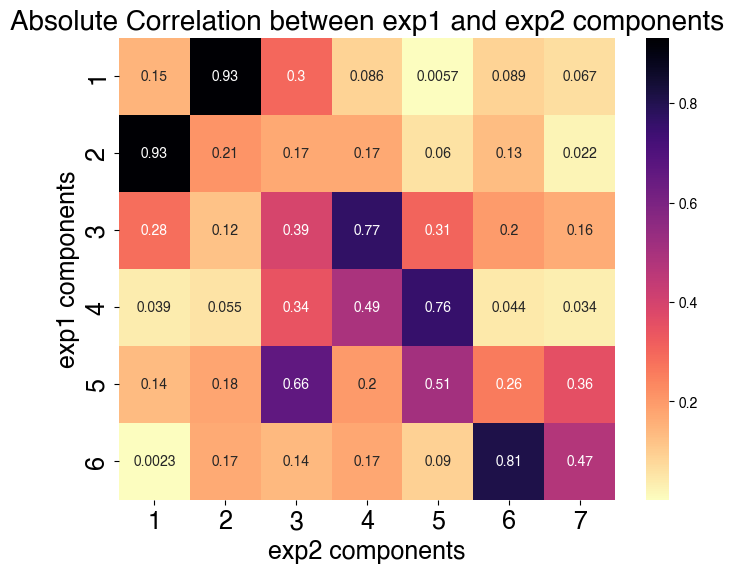

In [128]:
### make a correlation matrix with 6 rows and 7 columns where each cell is the correlation between the 6 components of exp1_space and the 7 components of exp2_space
cor_mat = np.zeros(shape=(6,7))
for i in range(6):
    for j in range(7):
        cor_mat[i,j] = np.abs(np.dot(exp1_space[i,:],exp2_space[j,:]))
### show the matrix as a colormap with the correlation values shown inside the cells
plt.figure(figsize=(8,6))
sns.heatmap(cor_mat,annot=True, cmap='magma_r')
plt.xlabel('exp2 components',fontsize=18)
plt.ylabel('exp1 components',fontsize=18)
### set the x ticks as the numbers 1 through 7 and the y ticks as the numbers 1 through 6

plt.xticks(np.arange(7)+.5,np.arange(1,8),fontsize=18)
plt.yticks(np.arange(6)+.5,np.arange(1,7),fontsize=18)

plt.title('Absolute Correlation between exp1 and exp2 components',fontsize=20)


In [129]:
### create a random 3x4 matrix using numpy and compute its svd
rng = np.random.default_rng()
rand_mat = rng.random((3,4))
rand_mat_t = rand_mat.T
U_rand,S_rand,Vt_rand = svd(rand_mat, full_matrices=False)
U_rand_t,S_rand_t,Vt_rand_t = svd(rand_mat_t, full_matrices=False)



In [130]:
Vt_rand

array([[ 0.58708017,  0.42949276,  0.5144224 ,  0.45413922],
       [ 0.64419637, -0.2725321 , -0.68563117,  0.20161149],
       [ 0.08434117,  0.80717904, -0.37367028, -0.44913149]])

In [ ]:
U_rand_t

## Dandelion plots

In [ ]:


def plot_dandplot(basis_vecs=basis_vecs1,num_pcs=6):
    
    ws,_ = colorimetric_reg(basis_vecs.T)
    ws = ws[0:num_pcs,:]
    hangle = np.mod( np.arctan2(ws[:,3], ws[:,2])*(180/np.pi), 360)
    rho = np.sqrt(np.sum(ws[:,[2,3]]**2,1))

    hangle2 = np.mod( [ (np.arctan2( ws[:,5], ws[:,4] )*(180/np.pi)/2),
                             np.arctan2( ws[:,5], ws[:,4] )*(180/np.pi)/2 + 180], 360 );
    rho2 = np.sqrt(np.sum(ws[:,[4,5]]**2,1))
    rho2 = [rho2,rho2]
    
    rho_max = np.max(rho)
    rho2_max = np.max(rho2[0])


    circ_colors= []
    for i in range(360):
        c = LCHabColor(78+14*np.sin(i*np.pi/180), 30, i) ## sample colors in lch space
        circ_colors.append(c)
    lab_circ_colors = [convert_color(c, LabColor) for c in circ_colors] ### convert colors to Lab space
    rgb_circ_colors = [convert_color(c, AdobeRGBColor) for c in lab_circ_colors] ### convert to rgb for plotting
    rgb_circ_colors = [(c.clamped_rgb_r,c.clamped_rgb_g,c.clamped_rgb_b) for c in rgb_circ_colors] ## clamp colors
    circ_cmap = ListedColormap(rgb_circ_colors)
    
    for i in range(num_pcs):
    
    
        fig1, ax1 = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))
        fig2, ax2 = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(8,8))

        norm = mpl.colors.Normalize(0.0, 2*np.pi)


        n = 720  #the number of secants for the mesh
        t = np.linspace(0,2*np.pi,n)   #theta values
        r = np.linspace(4+rho_max,rho_max,100)        #radius values change 0.6 to 0 for full circle
        rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
        c = tg                         #define color values as theta value
        im = ax1.pcolormesh(t, r, c.T,norm=norm,cmap = circ_cmap,zorder=-1,rasterized=True)

        ax1.plot( [hangle[i]*np.pi/180,hangle[i]*np.pi/180], [0,rho[i]],color='k',linewidth=2,linestyle ='-',marker='o',markersize=25)
        hangle_ = np.mod(hangle[i]+180,360)
        print(hangle_)
        ax1.plot( [hangle_*np.pi/180,hangle_*np.pi/180], [0,rho[i]],color='k',linewidth=2,linestyle ='--',marker='o',markersize=25,fillstyle='full',markerfacecolor='white')

        #ax.set_rlim(-0.025,.05)
        ax1.set_rmax(rho_max+0.01)
        ax1.set_rticks(np.arange(0.05,rho_max,0.10))  # Less radial ticks
        # ax1.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
        ax1.grid(True,color='gray')

        ax1.tick_params(labelsize=35,pad=20,zorder=2)
        ax1.set_title(f'Dominant Hue Component {i+1}', fontsize=20,pad=10)
      
        
        t = np.linspace(0,2*np.pi,n)   #theta values
        r = np.linspace(4+rho2_max,rho2_max,200)        #radius values change 0.6 to 0 for full circle
        rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
        c = tg                         #define color values as theta value
        im2 = ax2.pcolormesh(t, r, c.T,norm=norm,cmap = circ_cmap,zorder=-1,rasterized=True) 
        
        
        
        ax2.plot( np.append(hangle2[:,i]*np.pi/180,hangle2[:,i]*np.pi/180), np.array((0,0,rho2[0][i],rho2[1][i])),color='k',linewidth=2,marker='o',markersize=25,linestyle='-')

        hangle2_ = np.mod(hangle2[:,i]+90,360)
        ax2.plot( [hangle2_[0]*np.pi/180,hangle2_[0]*np.pi/180], [0,rho2[0][i]],color='k',linewidth=2,marker='o',markersize=25,linestyle='--',fillstyle='full',markerfacecolor='white')
        print(hangle2_)
        ax2.plot( [hangle2_[1]*np.pi/180,hangle2_[1]*np.pi/180], [0,rho2[1][i]],color='k',linewidth=2,marker='o',markersize=25,linestyle='--',  fillstyle='full',markerfacecolor='white')
        
        #ax2.plot( np.append(hangle2_*np.pi/180,hangle2_*np.pi/180), np.array((0,0,rho2[0][i],rho2[1][i])),color='k',linewidth=2,marker='o',markersize=12,linestyle=(0, (1, 10)))



        ax2.set_rmax(rho2_max+0.01)
        ax2.set_rticks(np.arange(0.05,rho2_max,0.10))  # Less radial ticks
        ax2.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

        ax2.grid(True,color='gray')

        #ax.set_title("A line plot on a polar axis", va='bottom')
        ax2.tick_params(labelsize=35,pad=20,zorder=2)
        ax2.set_title(f'Dominant Axis Component {i+1}', fontsize=20,pad=10)

        
        # ### gpt based limits
        # ax1.set_ylim([0, rho_max])
        # ax2.set_ylim([0, rho2_max])


        fig1.savefig(f'../../data/recon_assocs/dom_hue_component_{i+1}.pdf',format = 'pdf', bbox_inches= 'tight')
        fig2.savefig(f'../../data/recon_assocs/dom_axis_component_{i+1}.pdf',format = 'pdf', bbox_inches= 'tight')
        
        # fig1.show() 
        # fig2.show()

        fig1.clear()
        fig2.clear()
        
    

In [ ]:
plot_dandplot(basis_vecs1)

In [ ]:
set_all_mat

In [ ]:


# def plot_dandplot(basis_vecs=basis_vecs1,num_pcs=6):
    
#     ws,_ = colorimetric_reg(basis_vecs1.T)
#     ws = ws[0:num_pcs,:]
#     hangle = np.mod( np.arctan2(ws[:,3], ws[:,2])*(180/np.pi), 360)
#     rho = np.sqrt(np.sum(ws[:,[2,3]]**2,1))

#     hangle2 = np.mod( [ (np.arctan2( ws[:,5], ws[:,4] )*(180/np.pi)/2),
#                              np.arctan2( ws[:,5], ws[:,4] )*(180/np.pi)/2 + 180], 360 );
#     rho2 = np.sqrt(np.sum(ws[:,[4,5]]**2,1))
#     rho2 = [rho2,rho2]
    
#     rho_max = np.max(rho)
#     rho2_max = np.max(rho2[0])


#     circ_colors= []
#     for i in range(360):
#         c = LCHabColor(78+14*np.sin(i*np.pi/180), 30, i) ## sample colors in lch space
#         circ_colors.append(c)
#     lab_circ_colors = [convert_color(c, LabColor) for c in circ_colors] ### convert colors to Lab space
#     rgb_circ_colors = [convert_color(c, AdobeRGBColor) for c in lab_circ_colors] ### convert to rgb for plotting
#     rgb_circ_colors = [(c.clamped_rgb_r,c.clamped_rgb_g,c.clamped_rgb_b) for c in rgb_circ_colors] ## clamp colors
#     circ_cmap = ListedColormap(rgb_circ_colors)
    
#     for i in range(num_pcs):
    
    
#         fig1, ax1 = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10,10))
#         fig2, ax2 = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10,10))

#         norm = mpl.colors.Normalize(0.0, 2*np.pi)


#         n = 720  #the number of secants for the mesh
#         t = np.linspace(0,2*np.pi,n)   #theta values
#         r = np.linspace(4+rho_max,rho_max,100)        #radius values change 0.6 to 0 for full circle
#         rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
#         c = tg                         #define color values as theta value
#         im = ax1.pcolormesh(t, r, c.T,norm=norm,cmap = circ_cmap,zorder=-1) 

#         ax1.plot( [hangle[i]*np.pi/180,hangle[i]*np.pi/180], [0,rho[i]],color='k',linewidth=2,linestyle ='-',marker='o',markersize=8)
#         hangle_ = np.mod(hangle[i]+180,360)
#         ax1.plot( [hangle_*np.pi/180,hangle_*np.pi/180], [0,rho[i]],color='k',linewidth=2,linestyle =':',marker='o',markersize=8)

#         #ax.set_rlim(-0.025,.05)
#         ax1.set_rmax(rho_max+0.01)
#         ax1.set_rticks(np.arange(0,rho_max,0.1))  # Less radial ticks
#         ax1.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#         ax1.grid(True,color='gray')

#         ax1.tick_params(labelsize=25,pad=15)
#         ax1.set_title(f'Dominant Hue Component {i+1}', fontsize=20,pad=10)
        
        
#         t = np.linspace(0,2*np.pi,n)   #theta values
#         r = np.linspace(4+rho2_max,rho2_max,200)        #radius values change 0.6 to 0 for full circle
#         rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
#         c = tg                         #define color values as theta value
#         im2 = ax2.pcolormesh(t, r, c.T,norm=norm,cmap = circ_cmap,zorder=-1) 
        
        
        
#         ax2.plot( np.append(hangle2[:,i]*np.pi/180,hangle2[:,i]*np.pi/180), np.array((0,0,rho2[0][i],rho2[1][i])),color='k',linewidth=2,marker='o',markersize=8,linestyle='-')

#         hangle2_ = np.mod(hangle2[:,i]+90,360)
#         ax2.plot( np.append(hangle2_*np.pi/180,hangle2_*np.pi/180), np.array((0,0,rho2[0][i],rho2[1][i])),color='k',linewidth=2,marker='o',markersize=8,linestyle=':')



#         ax2.set_rmax(rho2_max+0.01)
#         ax2.set_rticks(np.arange(0,rho2_max,0.1))  # Less radial ticks
#         ax2.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

#         ax2.grid(True,color='gray')

#         #ax.set_title("A line plot on a polar axis", va='bottom')
#         ax2.tick_params(labelsize=25,pad=15,zorder=2)
#         ax2.set_title(f'Dominant Axis Component {i+1}', fontsize=20,pad=10)


#         fig1.savefig(f'../../data/recon_assocs/dom_hue_component_{i+1}.pdf',format = 'pdf', bbox_inches= 'tight')
#         fig2.savefig(f'../../data/recon_assocs/dom_axis_component_{i+1}.pdf',format = 'pdf', bbox_inches= 'tight')
        
#         fig1.show() 
#         fig2.show()
        
    

In [ ]:

# hangle = np.mod( np.arctan2(ws[:,3], ws[:,2])*(180/np.pi), 360)
# rho = np.sqrt(np.sum(ws[:,[2,3]]**2,1))

# hangle2 = np.mod( [ (np.arctan2( ws[:,5], ws[:,4] )*(180/np.pi)/2),
#                          np.arctan2( ws[:,5], ws[:,4] )*(180/np.pi)/2 + 180], 360 );
# rho2 = np.sqrt(np.sum(ws[:,[4,5]]**2,1))
# rho2 = [rho2,rho2]

# rho_max = np.max(rho)
# rho2_max = np.max(rho2[0])


# circ_colors= []
# for i in range(360):
#     c = LCHabColor(78+14*np.sin(i*np.pi/180), 30, i) ## sample colors in lch space
#     circ_colors.append(c)
# lab_circ_colors = [convert_color(c, LabColor) for c in circ_colors] ### convert colors to Lab space
# rgb_circ_colors = [convert_color(c, AdobeRGBColor) for c in lab_circ_colors] ### convert to rgb for plotting
# rgb_circ_colors = [(c.clamped_rgb_r,c.clamped_rgb_g,c.clamped_rgb_b) for c in rgb_circ_colors] ## clamp colors
# circ_cmap = ListedColormap(rgb_circ_colors)

# for i in range(num_pcs):
    

In [ ]:
ws,_ = colorimetric_reg(basis_vecs1.T)
ws = ws[0:6,:]
lc = ws[:,[1,6]] ## pick the right weights
for i in range(6):
    fig = plt.figure(i,figsize=(7,7))
    ax= fig.add_subplot()
    ax.set_xlim(-.004,.004)
    ax.set_ylim(-.004,.004)
    ax.plot([lc[i,1],0],[lc[i,0],0],zorder=-1,c='gray',linewidth=5)
    ax.plot([0,-lc[i,1]],[0,-lc[i,0]],zorder=-1,c='gray',linestyle='--', linewidth=5)
    ax.scatter(lc[i,1],lc[i,0], marker='o',c='k',edgecolor='k',s=350)
    ax.scatter(-lc[i,1],-lc[i,0], marker='o',c='white',edgecolor='k',s=350)

    ax.plot(np.array(ax.get_xlim()),[0,0], color='k')
    ax.plot([0,0],np.array(ax.get_ylim()), color='k')
    ax.set_ylabel('lightness',fontsize=20)
    ax.set_xlabel('chroma',fontsize=20)
    ax.set_title(f'component {i+1}',fontsize=20)
    ax.tick_params(labelsize=30)
    ax.ticklabel_format(style='sci',scilimits=(0,0))
    ax.yaxis.get_offset_text().set_fontsize(15)
    ax.xaxis.get_offset_text().set_fontsize(15)
    ax.set_facecolor('white')
    ##put a box around the plot
    for spine in ax.spines.values():

        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    plt.savefig(f'../../data/recon_assocs/lightness_chroma_comp_{i+1}.pdf',format ='pdf',bbox_inches='tight')
    
    fig.show()



### New Prediction Plots

In [98]:
set_all_wide

color_index      prompt       0.0       1.0       2.0       3.0       4.0  \
0                 above  0.649375  0.461193  0.473295  0.477159  0.631136   
1                 angry  0.225650  0.323600  0.223300  0.304400  0.185750   
2                 apple  0.072092  0.064388  0.072857  0.078010  0.065153   
3                banana  0.067347  0.061786  0.070204  0.067041  0.066735   
4                 beach  0.758500  0.575778  0.232556  0.213278  0.764333   
..                  ...       ...       ...       ...       ...       ...   
65               sunset  0.293778  0.298611  0.429167  0.420500  0.332500   
66                train  0.392696  0.447255  0.282892  0.243480  0.410294   
67                truck  0.402990  0.485098  0.152549  0.112745  0.412696   
68           watermelon  0.172554  0.161141  0.134728  0.202500  0.163315   
69              working  0.430000  0.477692  0.313125  0.264135  0.441490   

color_index       5.0       6.0       7.0       8.0  ...      61.0      62.0  \
0            0.500284  0.524091  0.296591  0.484205  ...  0.428409  0.415682   
1            0.331800  0.218850  0.363900  0.219550  ...  0.613950  0.825300   
2            0.094235  0.073776  0.082653  0.080561  ...  0.365561  0.851582   
3            0.067092  0.078878  0.063827  0.074847  ...  0.119592  0.084337   
4            0.613500  0.364667  0.192444  0.207889  ...  0.330556  0.237333   
..                ...       ...       ...       ...  ...       ...       ...   
65           0.295667  0.470389  0.365556  0.491000  ...  0.730556  0.639667   
66           0.460490  0.316324  0.275784  0.228578  ...  0.468824  0.552598   
67           0.531863  0.208627  0.167647  0.111324  ...  0.287108  0.568578   
68           0.151087  0.174293  0.140326  0.204022  ...  0.318641  0.732717   
69           0.503558  0.385962  0.334712  0.298942  ...  0.439038  0.387788   

color_index      63.0      64.0      65.0      66.0      67.0      68.0  \
0            0.589432  0.550000  0.585739  0.513864  0.586136  0.565795   
1            0.197250  0.246050  0.193250  0.256200  0.200150  0.277350   
2            0.590153  0.649592  0.587959  0.465051  0.427704  0.353214   
3            0.282755  0.327551  0.341735  0.493418  0.579082  0.797245   
4            0.303222  0.320889  0.347389  0.357056  0.449611  0.595111   
..                ...       ...       ...       ...       ...       ...   
65           0.180833  0.186611  0.195556  0.252111  0.384389  0.687944   
66           0.294902  0.355539  0.335392  0.387157  0.405049  0.408725   
67           0.175294  0.187745  0.173627  0.208235  0.156029  0.273039   
68           0.712391  0.699837  0.657989  0.538750  0.412663  0.234076   
69           0.398269  0.402740  0.378558  0.433750  0.395865  0.428702   

color_index      69.0      70.0  
0            0.643239  0.556534  
1            0.301250  0.461400  
2            0.343367  0.284949  
3            0.879592  0.406173  
4            0.706111  0.556611  
..                ...       ...  
65           0.683389  0.784111  
66           0.410049  0.407108  
67           0.222108  0.256275  
68           0.213750  0.188696  
69           0.457356  0.419471  

[70 rows x 72 columns]

In [99]:
set_all_recon_wide

color_index     concept         0         1         2         3         4  \
0                 above  0.219438  0.072416  0.221794  0.190694  0.223156   
1                 angry -0.223420 -0.057858  0.030687  0.018881 -0.214081   
2                 apple -0.250402 -0.343335 -0.301558 -0.205878 -0.254300   
3                banana -0.338917 -0.375718 -0.253917 -0.217944 -0.353318   
4                 beach  0.303229  0.171185  0.008632 -0.069438  0.315727   
..                  ...       ...       ...       ...       ...       ...   
65               sunset -0.058812 -0.090057  0.074863  0.131007 -0.069119   
66                train -0.064741 -0.024343 -0.036060 -0.036874 -0.065318   
67                truck -0.080230  0.001527 -0.153160 -0.174891 -0.086497   
68           watermelon -0.161375 -0.222732 -0.247623 -0.079829 -0.159483   
69              working -0.011437  0.026314 -0.012778 -0.021638 -0.011333   

color_index         5         6         7         8  ...        61        62  \
0            0.020172  0.221378  0.111899  0.215350  ... -0.038389 -0.397734   
1           -0.051395  0.016324  0.174960  0.039475  ... -0.020663 -0.238382   
2           -0.383915 -0.344127 -0.333745 -0.243225  ... -0.080891  0.117012   
3           -0.380965 -0.306302 -0.235996 -0.218658  ... -0.284750 -0.285390   
4            0.148503  0.070919 -0.169232 -0.042156  ...  0.137508 -0.384348   
..                ...       ...       ...       ...  ...       ...       ...   
65          -0.114875  0.056760  0.081153  0.122594  ...  0.165063  0.172575   
66          -0.000256 -0.040087 -0.001592 -0.039108  ... -0.019128  0.048712   
67           0.043985 -0.145284 -0.102718 -0.179575  ... -0.122885  0.061064   
68          -0.247963 -0.304922 -0.260787 -0.175705  ...  0.333849  1.175454   
69           0.054762 -0.016210  0.014697 -0.028300  ... -0.045016  0.090619   

color_index        63        64        65        66        67        68  \
0            0.219229  0.198566  0.235003  0.200782  0.285442  0.264867   
1           -0.176880 -0.147654 -0.147123 -0.099881 -0.129852 -0.079402   
2            0.247419  0.252847  0.223436  0.132989  0.109121  0.004502   
3           -0.054229 -0.042548 -0.036314 -0.057101 -0.040136 -0.011123   
4           -0.053993 -0.082195 -0.033227  0.039434  0.178040  0.403252   
..                ...       ...       ...       ...       ...       ...   
65          -0.163792 -0.178191 -0.137200 -0.114539 -0.055976  0.077956   
66          -0.044782 -0.041043 -0.051238 -0.030502 -0.054088 -0.039118   
67          -0.167490 -0.151892 -0.172204 -0.143135 -0.190404 -0.197281   
68           0.383517  0.394083  0.301513  0.136359  0.028246 -0.210169   
69           0.039007  0.044192  0.020948  0.017834 -0.030133 -0.090068   

color_index        69        70  
0            0.323853  0.175826  
1           -0.089385 -0.032461  
2            0.011530 -0.056276  
3           -0.015054 -0.156475  
4            0.464751  0.390875  
..                ...       ...  
65           0.149477  0.201643  
66          -0.069258 -0.060219  
67          -0.240072 -0.220363  
68          -0.243303 -0.006237  
69          -0.138554 -0.127564  

[70 rows x 72 columns]

In [119]:
def plot_correlation_grid( mat1, mat2, concept_col=None, cols_per_fig=5, rows_per_fig=5, xlim=(0, 1), ylim=(-0.5, 1.5), point_size=35, line_color='black', annotate=True, save_prefix=None, show=True, color_df=None, ): 
    """ Plot per-concept scatter correlations between two wide matrices.
        Inputs:
    - mat1, mat2: pandas DataFrames in "wide" form:
        first column is concept/prompt, remaining columns are color indices
        (e.g., 1..71). The two frames may be in different concept orders.
    - concept_col: name of the concept column. If None, uses the first column.
    - cols_per_fig, rows_per_fig: grid size per figure (default 5x5).
    - xlim, ylim: axis limits per facet.
    - point_size: scatter point size.
    - line_color: color for best-fit line.
    - annotate: if True, writes 'r=...' in top-left of facet.
    - save_prefix: if not None, saves each page as f"{save_prefix}_page{n}.pdf".
    - show: if True, displays the figures.
    - color_df: DataFrame with columns ['color_index','color_hex'] to color points.
    If None, uses global uw71coords if present; otherwise uses default color.

    Returns:
    - stats_df: DataFrame with columns ['concept','pearson_r','slope','intercept','n_points'].
    """
    # Detect concept column
    if concept_col is None:
        concept_col = mat1.columns[0]

    # Ensure concept_col is present
    if concept_col not in mat1.columns or concept_col not in mat2.columns:
        raise ValueError("Concept column not found in one or both input matrices.")

    # Align concepts to intersection
    c1 = set(mat1[concept_col].astype(str).values)
    c2 = set(mat2[concept_col].astype(str).values)
    common = sorted(c1.intersection(c2))
    if len(common) == 0:
        raise ValueError("No overlapping concepts between the two matrices.")

    m1 = mat1.copy()
    m2 = mat2.copy()
    m1[concept_col] = m1[concept_col].astype(str)
    m2[concept_col] = m2[concept_col].astype(str)

    m1 = m1[m1[concept_col].isin(common)].set_index(concept_col).loc[common]
    m2 = m2[m2[concept_col].isin(common)].set_index(concept_col).loc[common]

    # Determine color columns (shared across both)
    cols1 = list(m1.columns)
    cols2 = list(m2.columns)
    # Keep only overlapping color indices
    common_cols = [c for c in cols1 if c in cols2]

    # Cast column labels to numeric if possible for color lookup mapping
    def to_int_if_possible(x):
        try:
            return int(x)
        except:
            return x

    common_cols_cast = [to_int_if_possible(c) for c in common_cols]

    # Color mapping
    if color_df is None:
        # Try global uw71coords if available
        try:
            color_df = uw71coords[['color_index', 'color_hex']]
        except NameError:
            color_df = None

    if color_df is not None:
        # Build color lookup dict using int color_index keys
        # Ensure numeric
        key_idx = color_df['color_index'].astype(int).values
        key_hex = color_df['color_hex'].values
        color_lookup = {int(k): v for k, v in zip(key_idx, key_hex)}
        point_colors = []
        for c in common_cols_cast:
            if isinstance(c, int) and c in color_lookup:
                point_colors.append(color_lookup[c])
            else:
                point_colors.append('#777777')
    else:
        # Fallback: uniform color
        point_colors = ['#777777'] * len(common_cols_cast)

    # Prepare stats
    stats = []

    # Figure layout
    per_fig = cols_per_fig * rows_per_fig
    n_concepts = len(common)
    n_pages = math.ceil(n_concepts / per_fig)

    # Build numeric X/Y matrices in consistent column order
    m1_num = m1[common_cols].apply(pd.to_numeric, errors='coerce').to_numpy()
    m2_num = m2[common_cols].apply(pd.to_numeric, errors='coerce').to_numpy()

    for page in range(n_pages):
        start = page * per_fig
        end = min((page + 1) * per_fig, n_concepts)
        count = end - start
        rows = min(rows_per_fig, math.ceil(count / cols_per_fig))

        fig, axes = plt.subplots(rows_per_fig, cols_per_fig, figsize=(cols_per_fig * 3.2, rows_per_fig * 3.2))
        # axes could be 2D or flattened; make flattened list for easy indexing
        axes_flat = axes.ravel()

        for i in range(per_fig):
            ax = axes_flat[i]
            concept_idx = start + i
            if concept_idx >= end:
                ax.axis('off')
                continue

            concept = common[concept_idx]
            # Row index in m1/m2
            r = concept_idx

            x = m1_num[r, :]
            y = m2_num[r, :]

            # Mask NaNs
            mask = np.isfinite(x) & np.isfinite(y)
            x_valid = x[mask]
            y_valid = y[mask]
            n_pts = len(x_valid)

            # Colors aligned to mask
            if n_pts > 0:
                colors_masked = np.array(point_colors, dtype=object)[mask]
            else:
                colors_masked = []

            # Scatter
            ax.scatter(x_valid, y_valid, c=colors_masked, s=point_size, edgecolors='none')

            # Best-fit line if we have at least 2 points
            slope = np.nan
            intercept = np.nan
            r_val = np.nan
            if n_pts >= 2 and np.nanstd(x_valid) > 0 and np.nanstd(y_valid) > 0:
                try:
                    slope, intercept = np.polyfit(x_valid, y_valid, 1)
                except Exception:
                    slope, intercept = np.nan, np.nan
                try:
                    r_val = pearsonr(x_valid, y_valid)[0]
                except Exception:
                    r_val = np.nan

                # Draw line across xlim
                xline = np.array([xlim[0], xlim[1]])
                yline = slope * xline + intercept
                ax.plot(xline, yline, color=line_color, linewidth=1)

            # Axes limits
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            # Annotation
            if annotate:
                try:
                    ax.annotate(f'r={r_val:.2f}' if np.isfinite(r_val) else 'r=nan',
                                xy=(0.05, 0.90), xycoords='axes fraction', fontsize=13)
                except Exception:
                    pass

            # Title as concept
            ax.set_title(concept, fontsize=14, pad=6)



            ax.set_xlabel('True Ratings', fontsize=12)
            ax.set_ylabel('Predicted Ratings', fontsize=12)

            # Tidy ticks
            if (i // cols_per_fig) < rows_per_fig - 1:
                ax.set_xticklabels([])
            if (i % cols_per_fig) != 0:
                ax.set_yticklabels([])
            sns.despine(ax=ax)

        plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}_{page+1}.pdf", bbox_inches='tight')
        if show:
            plt.show()
        else:
            plt.close(fig)

        # Collect stats for this page
        for j in range(start, end):
            r = j
            x = m1_num[r, :]
            y = m2_num[r, :]
            mask = np.isfinite(x) & np.isfinite(y)
            x_valid = x[mask]
            y_valid = y[mask]
            slope = np.nan
            intercept = np.nan
            r_val = np.nan
            if len(x_valid) >= 2 and np.nanstd(x_valid) > 0 and np.nanstd(y_valid) > 0:
                try:
                    slope, intercept = np.polyfit(x_valid, y_valid, 1)
                except Exception:
                    pass
                try:
                    r_val = pearsonr(x_valid, y_valid)[0]
                except Exception:
                    pass
            stats.append((common[j], r_val, slope, intercept, len(x_valid)))

    stats_df = pd.DataFrame(stats, columns=['concept', 'pearson_r', 'slope', 'intercept', 'n_points'])
    return stats_df



In [120]:
set_all_wide

color_index      prompt       0.0       1.0       2.0       3.0       4.0  \
0                 above  0.649375  0.461193  0.473295  0.477159  0.631136   
1                 angry  0.225650  0.323600  0.223300  0.304400  0.185750   
2                 apple  0.072092  0.064388  0.072857  0.078010  0.065153   
3                banana  0.067347  0.061786  0.070204  0.067041  0.066735   
4                 beach  0.758500  0.575778  0.232556  0.213278  0.764333   
..                  ...       ...       ...       ...       ...       ...   
65               sunset  0.293778  0.298611  0.429167  0.420500  0.332500   
66                train  0.392696  0.447255  0.282892  0.243480  0.410294   
67                truck  0.402990  0.485098  0.152549  0.112745  0.412696   
68           watermelon  0.172554  0.161141  0.134728  0.202500  0.163315   
69              working  0.430000  0.477692  0.313125  0.264135  0.441490   

color_index       5.0       6.0       7.0       8.0  ...      62.0      63.0  \
0            0.500284  0.524091  0.296591  0.484205  ...  0.415682  0.589432   
1            0.331800  0.218850  0.363900  0.219550  ...  0.825300  0.197250   
2            0.094235  0.073776  0.082653  0.080561  ...  0.851582  0.590153   
3            0.067092  0.078878  0.063827  0.074847  ...  0.084337  0.282755   
4            0.613500  0.364667  0.192444  0.207889  ...  0.237333  0.303222   
..                ...       ...       ...       ...  ...       ...       ...   
65           0.295667  0.470389  0.365556  0.491000  ...  0.639667  0.180833   
66           0.460490  0.316324  0.275784  0.228578  ...  0.552598  0.294902   
67           0.531863  0.208627  0.167647  0.111324  ...  0.568578  0.175294   
68           0.151087  0.174293  0.140326  0.204022  ...  0.732717  0.712391   
69           0.503558  0.385962  0.334712  0.298942  ...  0.387788  0.398269   

color_index      64.0      65.0      66.0      67.0      68.0      69.0  \
0            0.550000  0.585739  0.513864  0.586136  0.565795  0.643239   
1            0.246050  0.193250  0.256200  0.200150  0.277350  0.301250   
2            0.649592  0.587959  0.465051  0.427704  0.353214  0.343367   
3            0.327551  0.341735  0.493418  0.579082  0.797245  0.879592   
4            0.320889  0.347389  0.357056  0.449611  0.595111  0.706111   
..                ...       ...       ...       ...       ...       ...   
65           0.186611  0.195556  0.252111  0.384389  0.687944  0.683389   
66           0.355539  0.335392  0.387157  0.405049  0.408725  0.410049   
67           0.187745  0.173627  0.208235  0.156029  0.273039  0.222108   
68           0.699837  0.657989  0.538750  0.412663  0.234076  0.213750   
69           0.402740  0.378558  0.433750  0.395865  0.428702  0.457356   

color_index      70.0     concept  
0            0.556534       above  
1            0.461400       angry  
2            0.284949       apple  
3            0.406173      banana  
4            0.556611       beach  
..                ...         ...  
65           0.784111      sunset  
66           0.407108       train  
67           0.256275       truck  
68           0.188696  watermelon  
69           0.419471     working  

[70 rows x 73 columns]

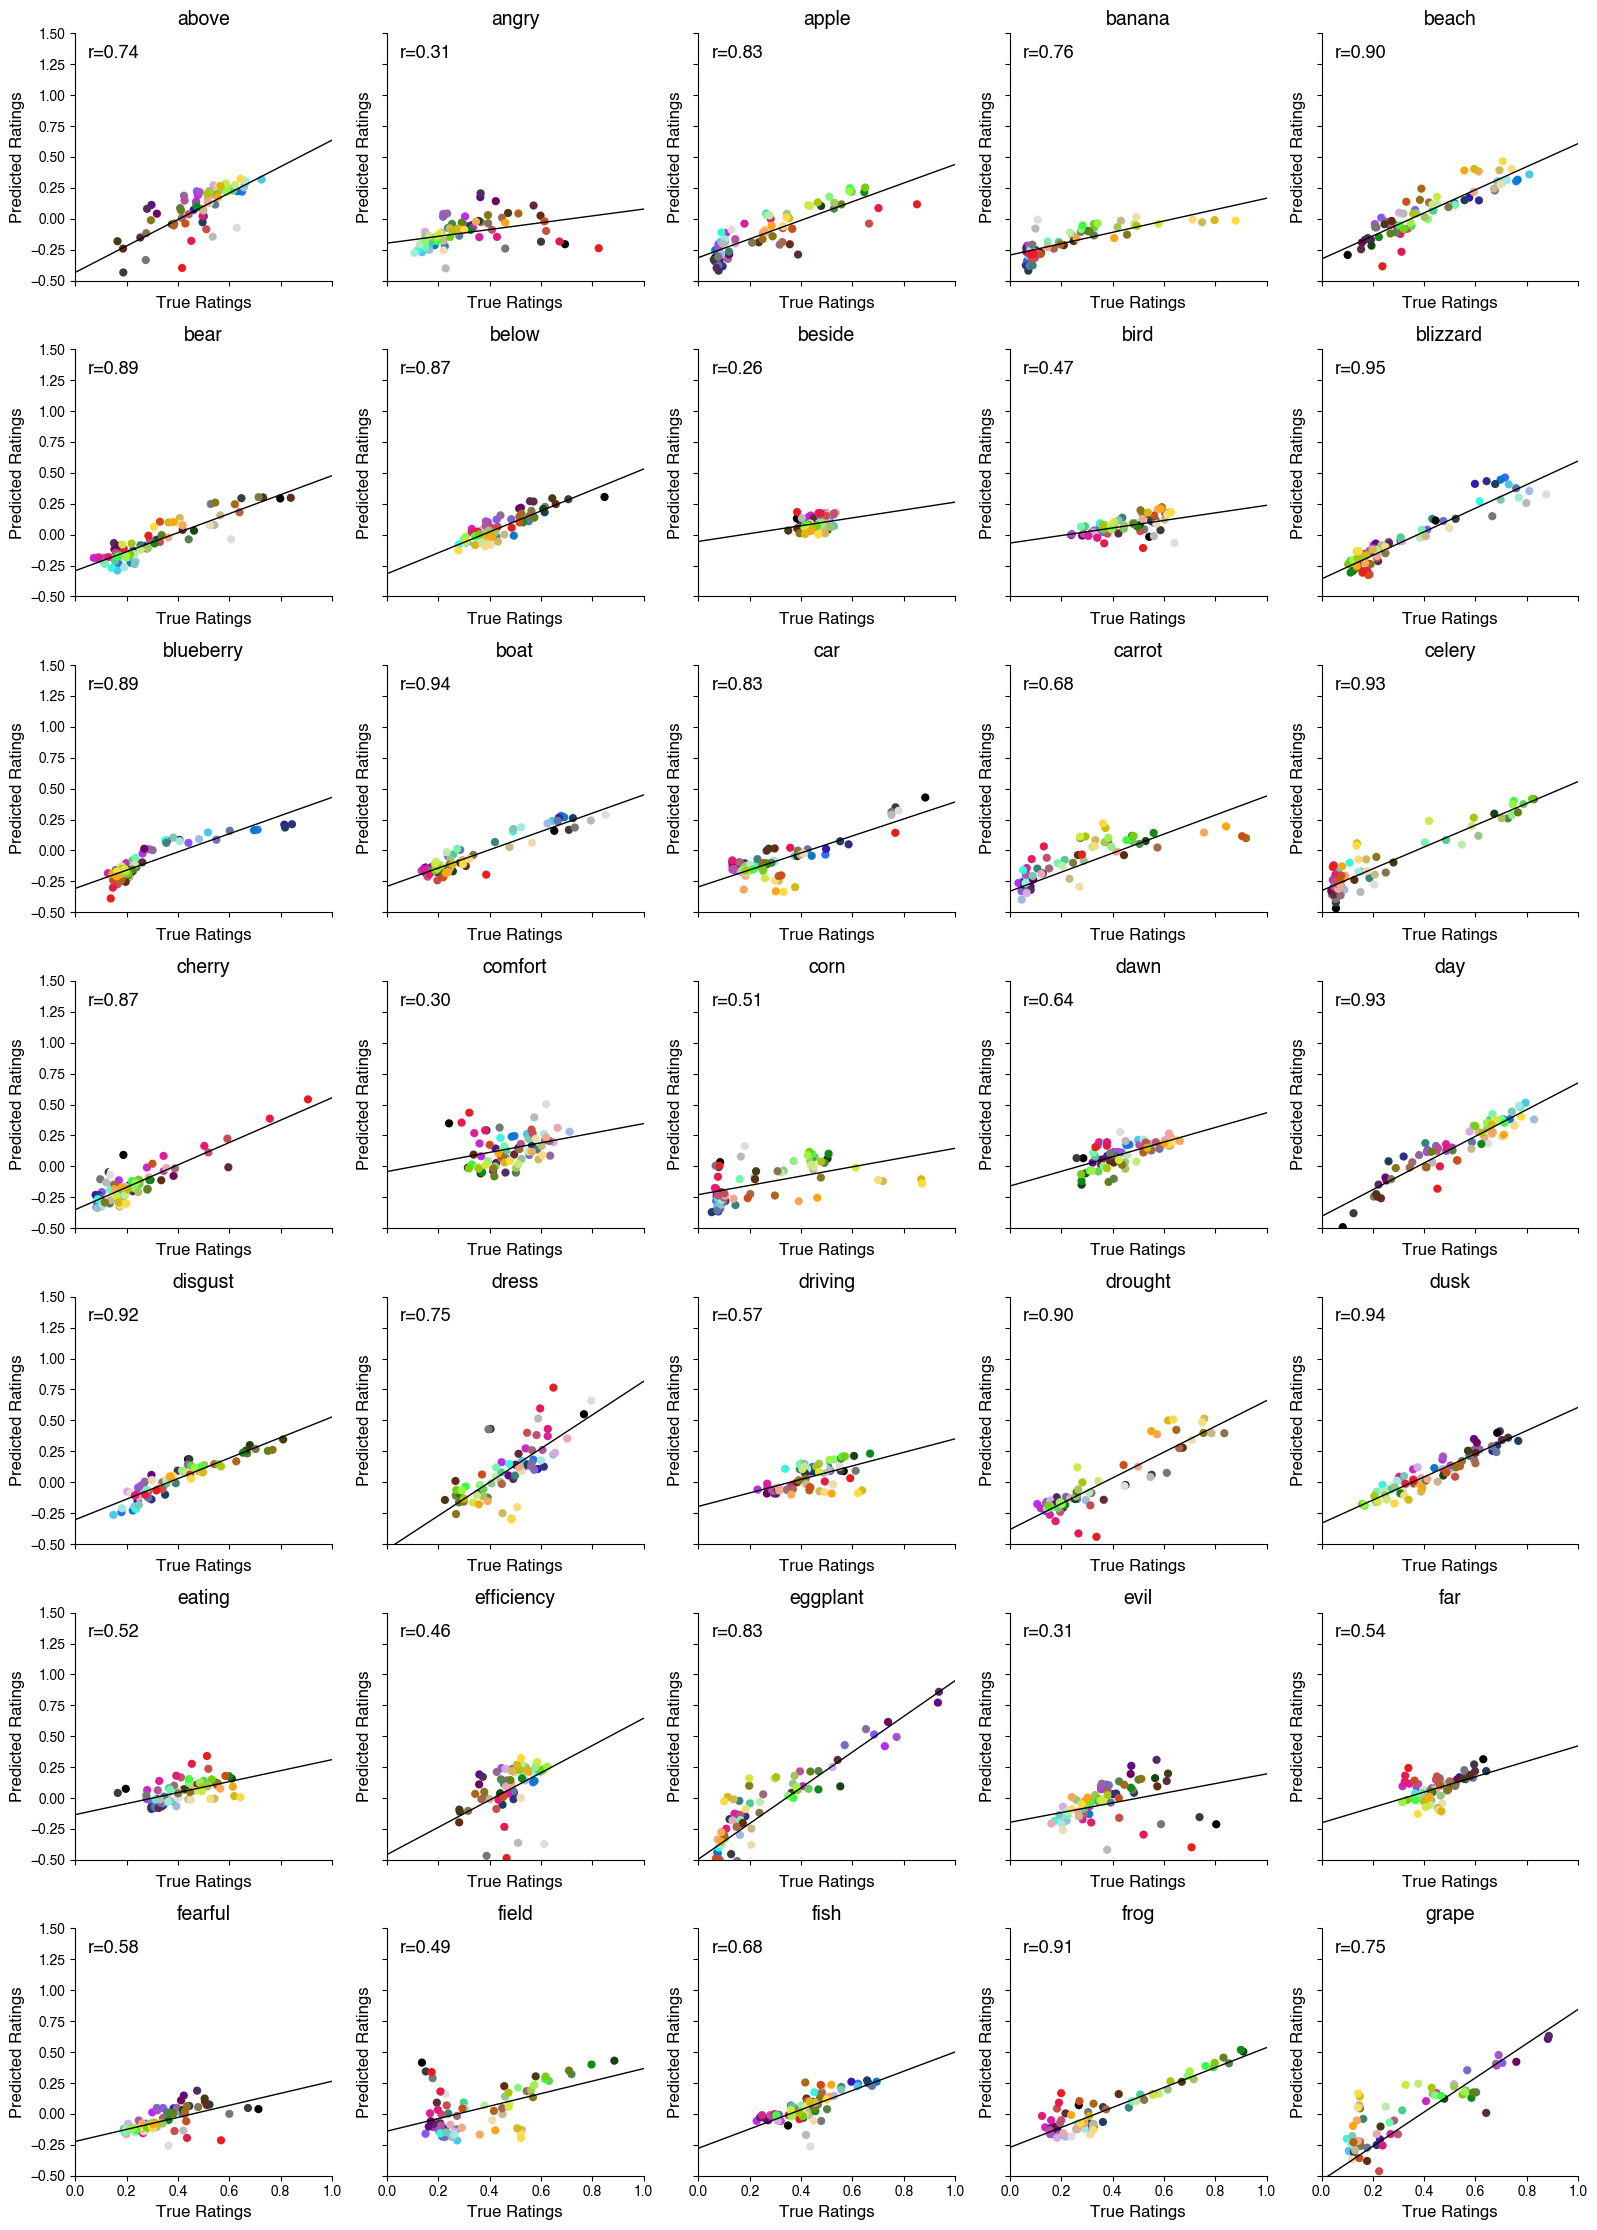

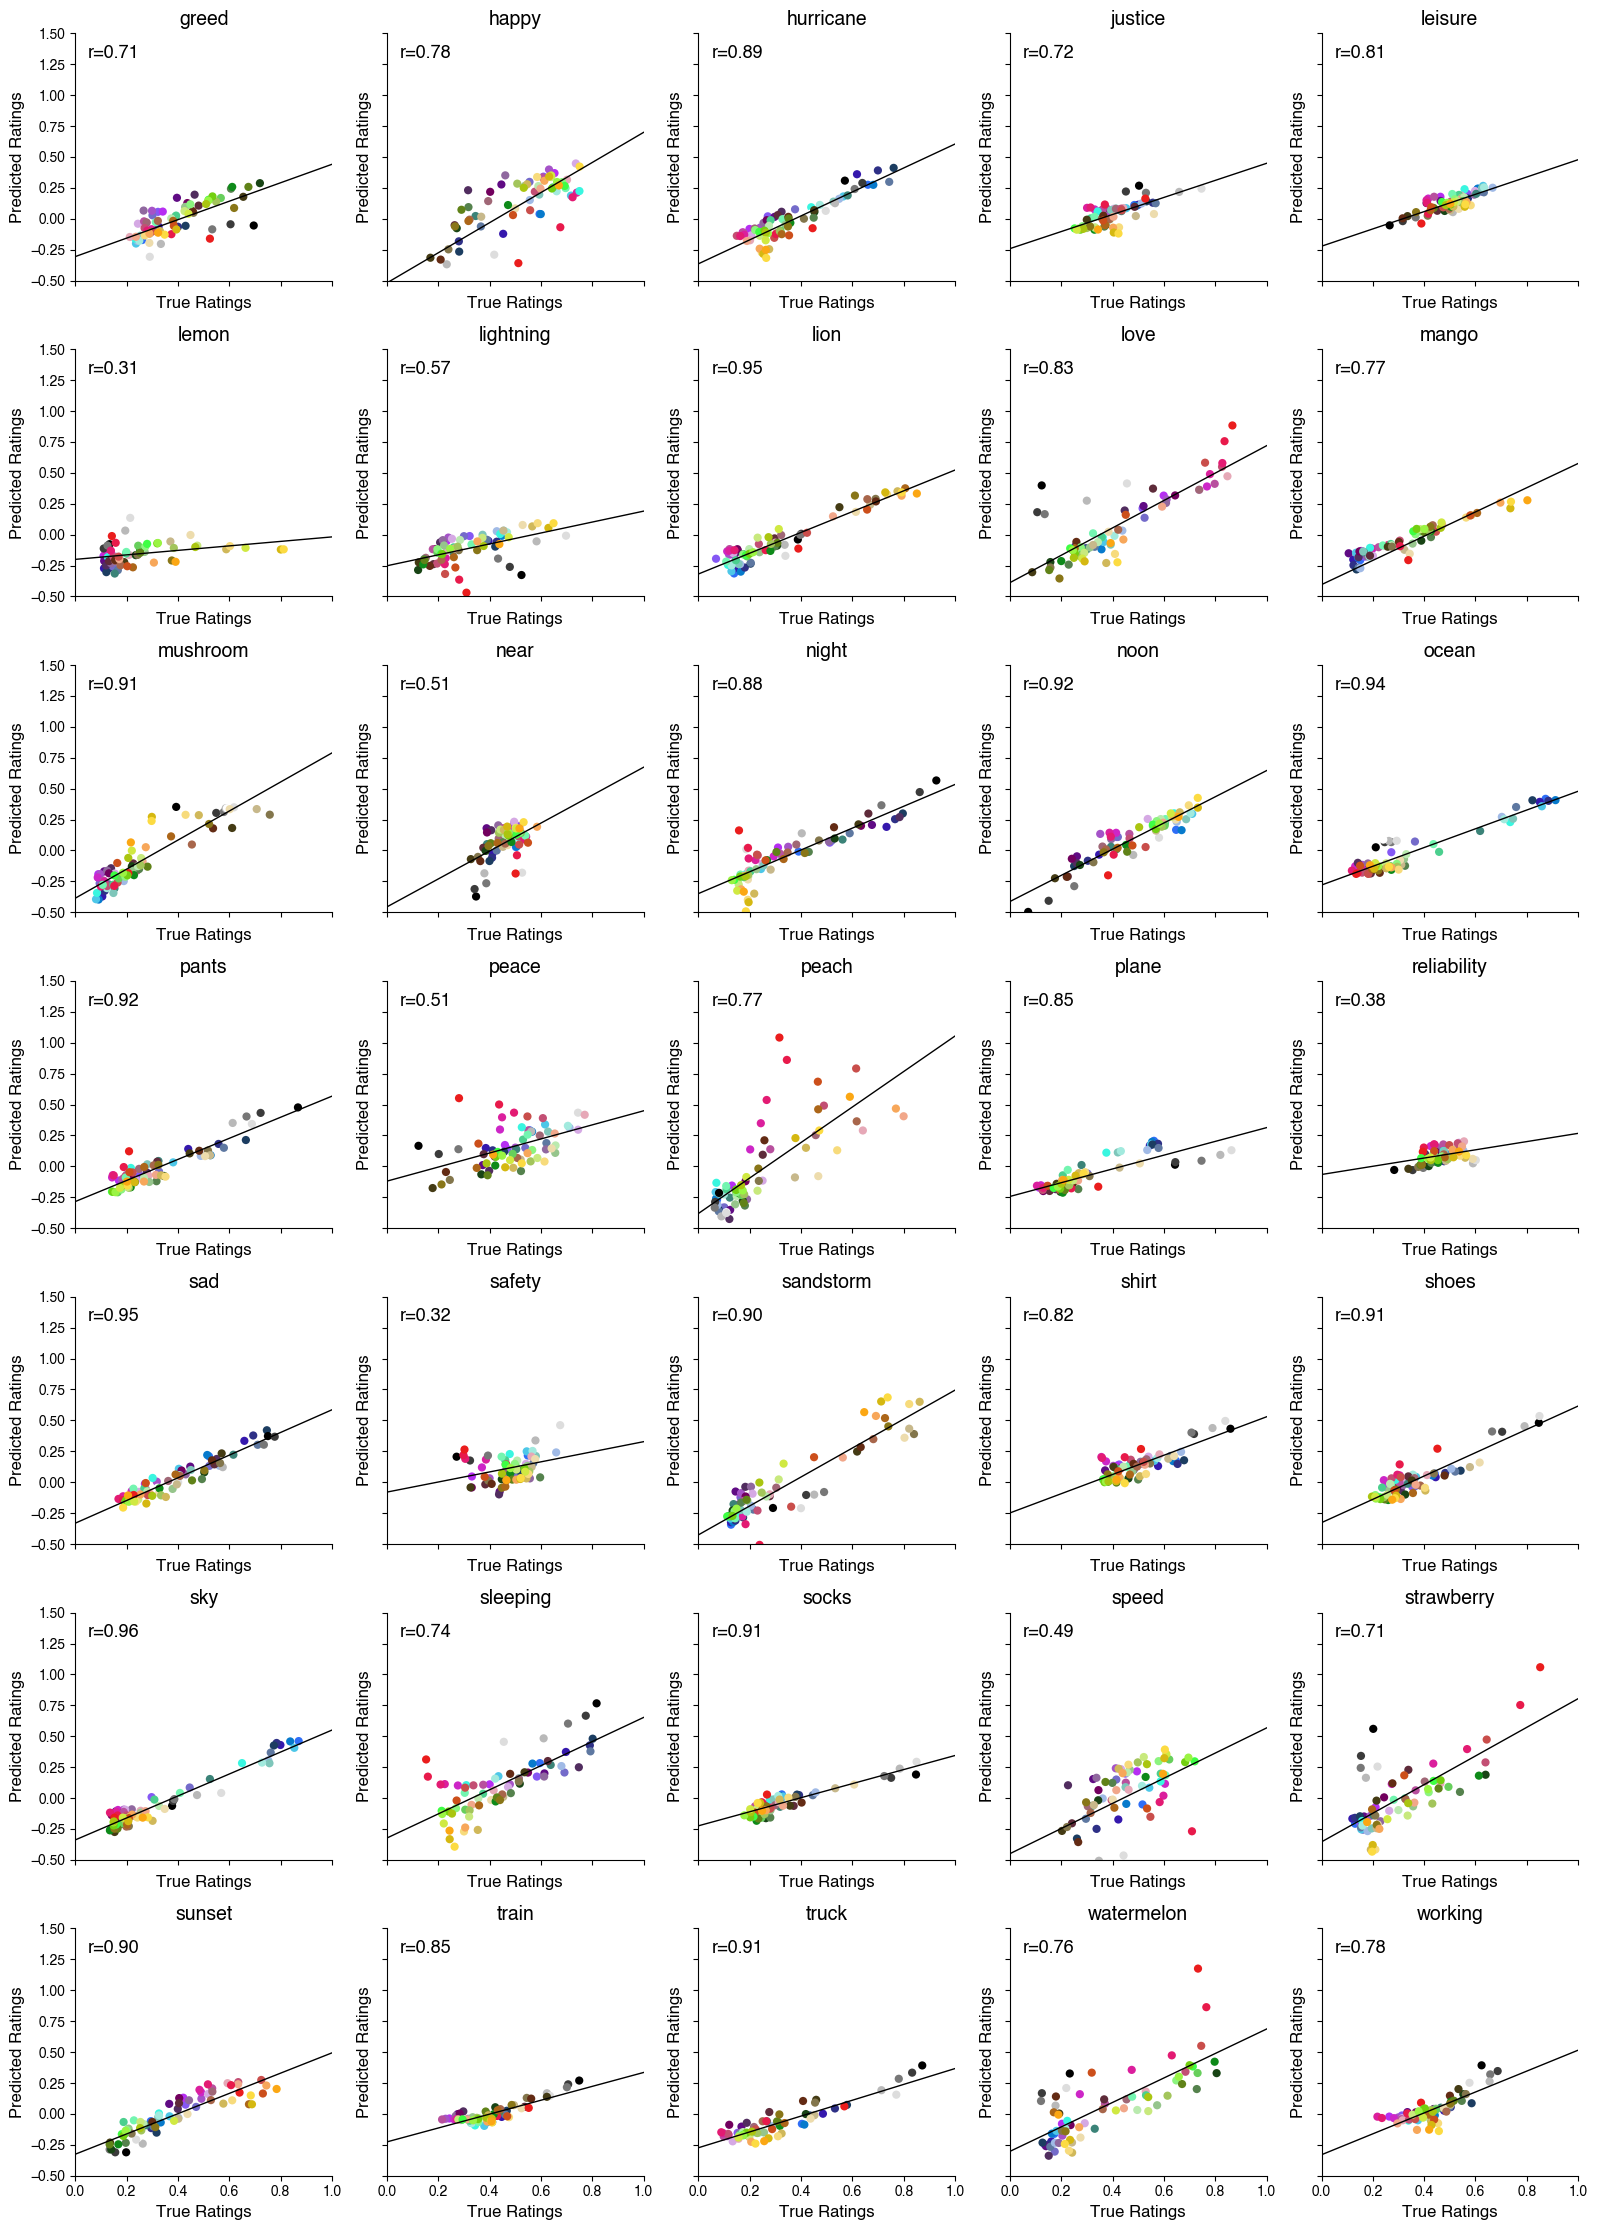

concept  pearson_r     slope  intercept  n_points
0        above   0.742781  1.068962  -0.433131        71
1        angry   0.311073  0.275533  -0.197307        71
2        apple   0.832846  0.753261  -0.313754        71
3       banana   0.762085  0.459595  -0.293572        71
4        beach   0.898993  0.933610  -0.325642        71
..         ...        ...       ...        ...       ...
65      sunset   0.897343  0.819568  -0.325555        71
66       train   0.850447  0.561339  -0.226325        71
67       truck   0.912753  0.640640  -0.273627        71
68  watermelon   0.758897  0.989538  -0.302813        71
69     working   0.783608  0.845805  -0.330311        71

[70 rows x 5 columns]

In [124]:
set_all_wide['concept'] = set_all_wide['prompt'].astype(str)
import math
plot_correlation_grid(set_all_wide, set_all_recon_wide, concept_col='concept', cols_per_fig=5, rows_per_fig=7, xlim=(0, 1), ylim=(-0.5, 1.5), point_size=35, line_color='black', annotate=True, save_prefix='../../data/recon_assocs/exp2b_cors', show=True, color_df=uw71coords)

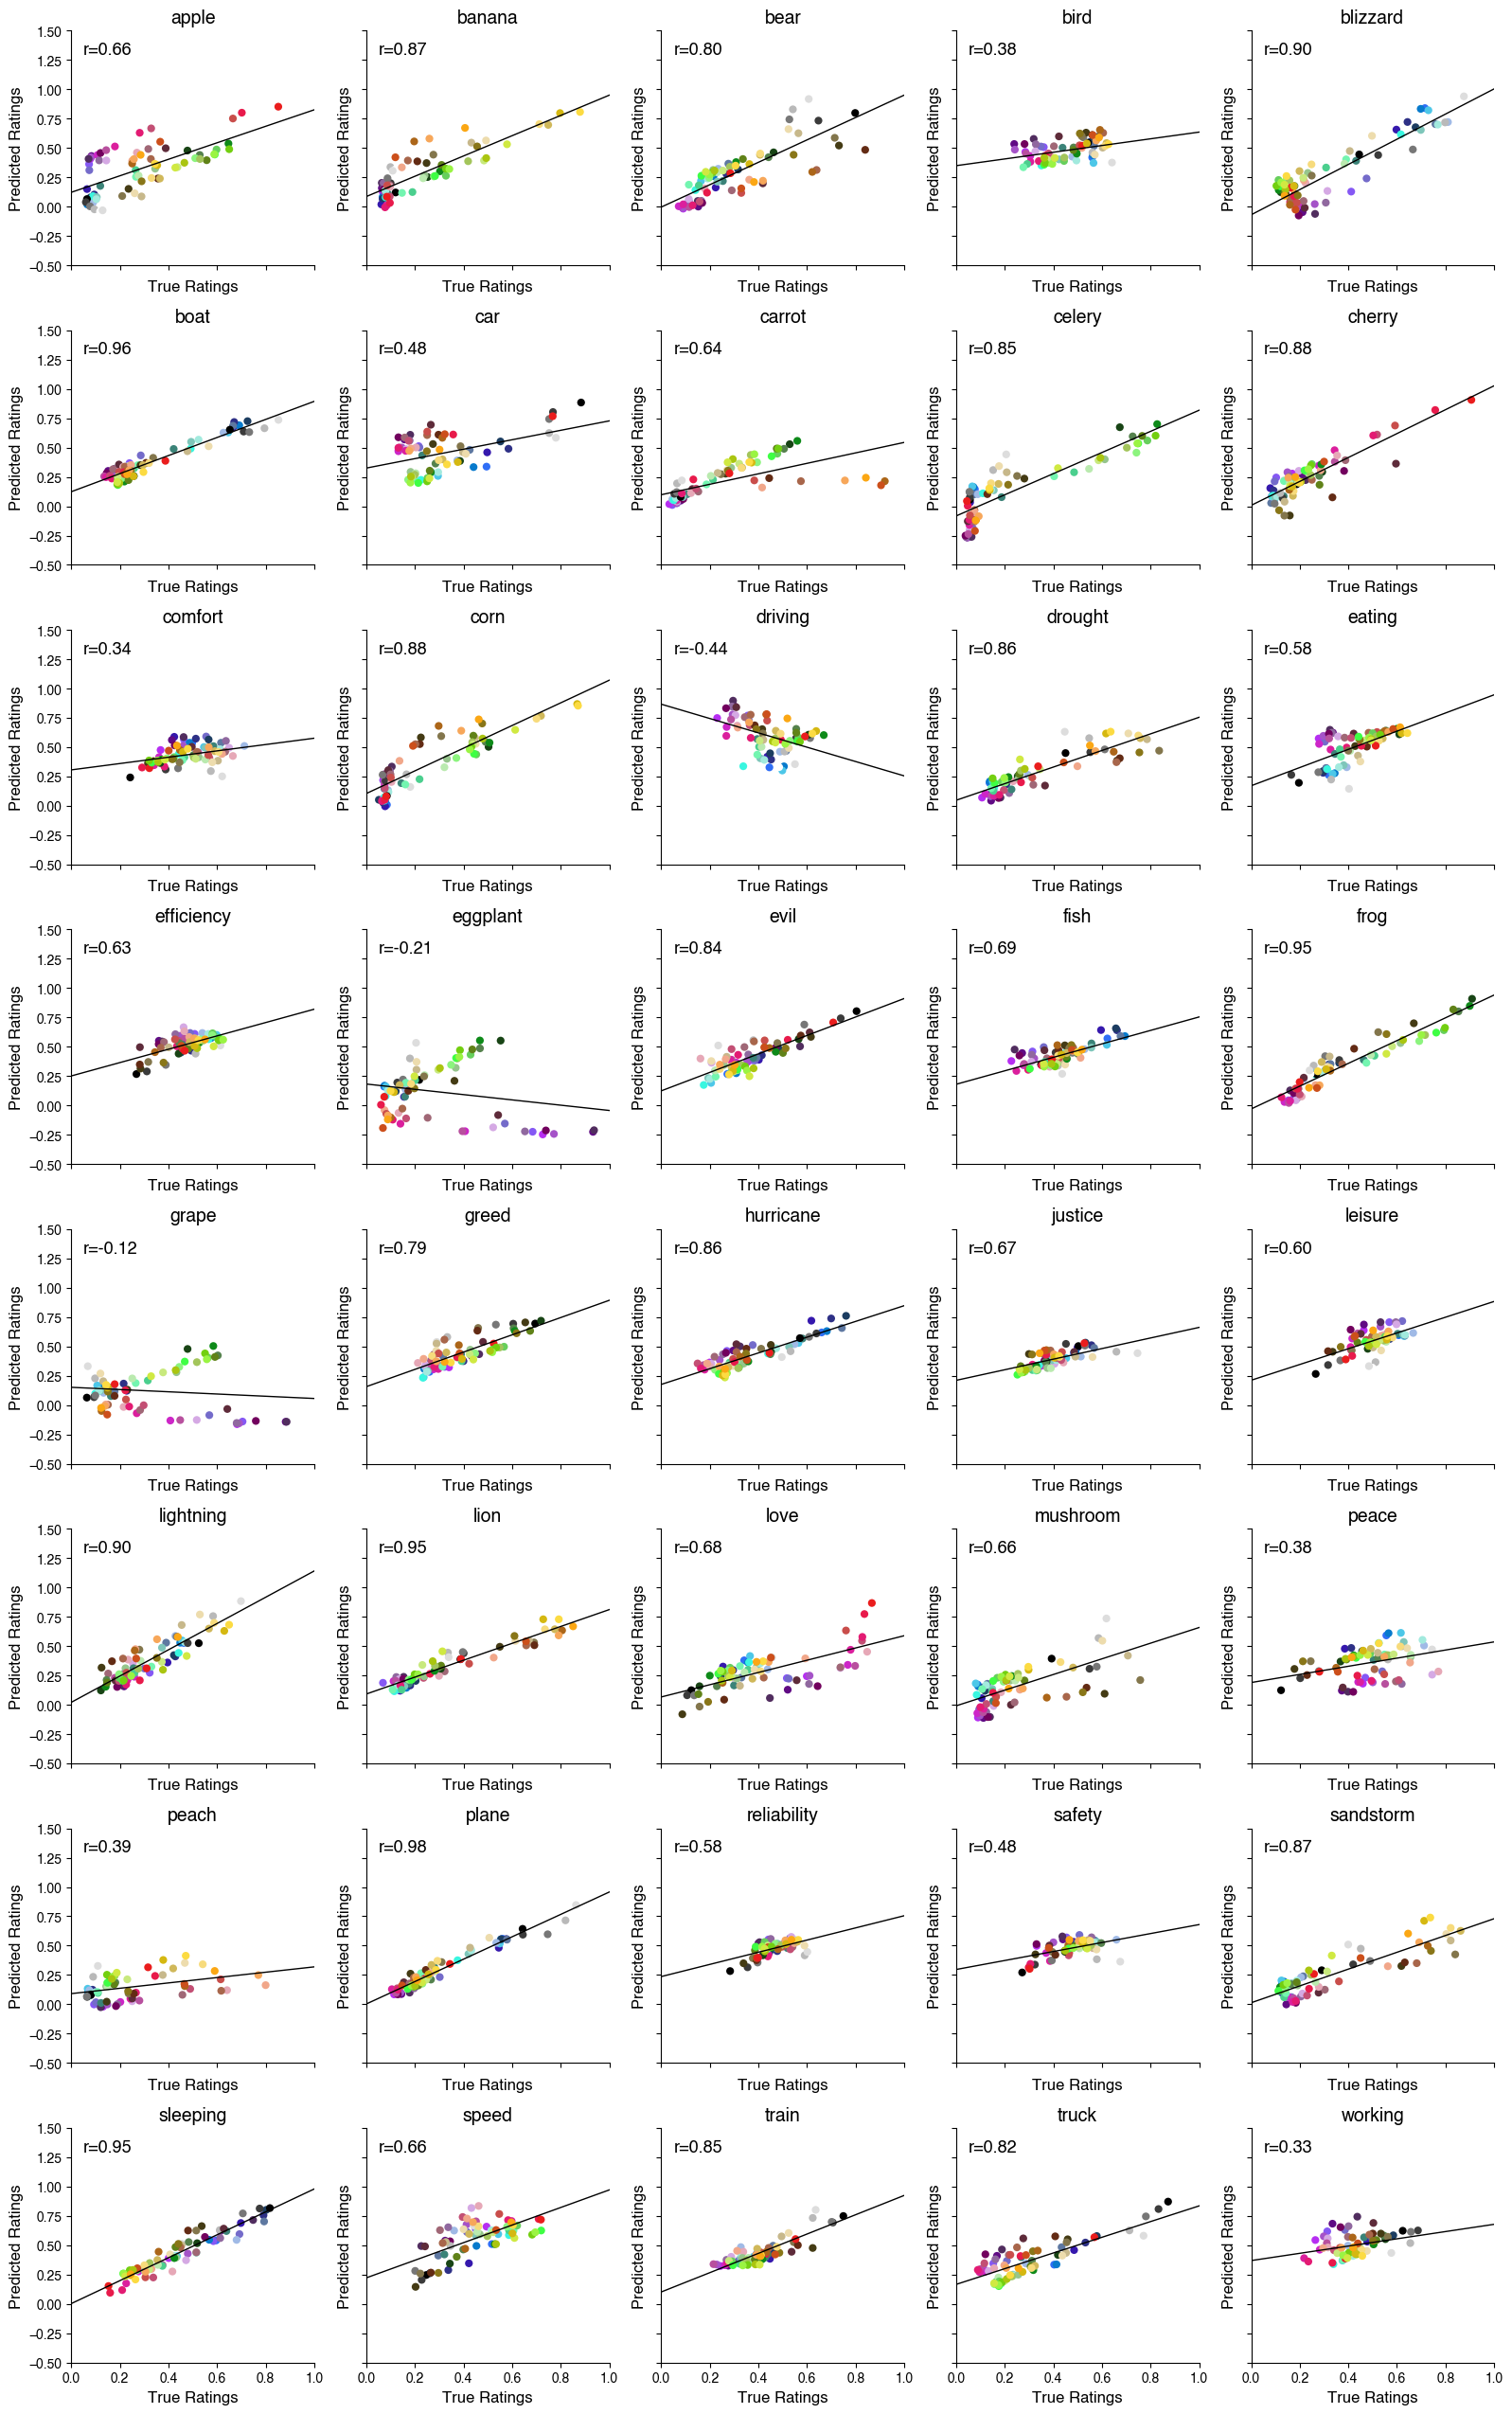

concept  pearson_r     slope  intercept  n_points
0         apple   0.664607  0.703281   0.122207        71
1        banana   0.865538  0.864046   0.085874        71
2          bear   0.802336  0.954334  -0.003874        71
3          bird   0.383305  0.286207   0.348984        71
4      blizzard   0.903086  1.073143  -0.069612        71
5          boat   0.960570  0.770134   0.124113        71
6           car   0.480109  0.402332   0.325145        71
7        carrot   0.643106  0.445913   0.098002        71
8        celery   0.851660  0.900886  -0.082508        71
9        cherry   0.875411  1.019314   0.007446        71
10      comfort   0.335509  0.269958   0.306657        71
11         corn   0.877627  0.965989   0.105056        71
12      driving  -0.442777 -0.611117   0.866417        71
13      drought   0.860878  0.707257   0.047707        71
14       eating   0.580599  0.775170   0.171328        71
15   efficiency   0.634405  0.568912   0.251865        71
16     eggplant  -0.208614 -0.225324   0.182649        71
17         evil   0.835086  0.786932   0.124648        71
18         fish   0.688588  0.573815   0.180732        71
19         frog   0.949241  0.971134  -0.029693        71
20        grape  -0.119057 -0.095193   0.151414        71
21        greed   0.787981  0.736058   0.157072        71
22    hurricane   0.863591  0.671253   0.176201        71
23      justice   0.667142  0.451327   0.210971        71
24      leisure   0.598486  0.671654   0.211647        71
25    lightning   0.895611  1.119606   0.020758        71
26         lion   0.954400  0.719505   0.091127        71
27         love   0.682491  0.522200   0.065960        71
28     mushroom   0.659920  0.667358  -0.009397        71
29        peace   0.379996  0.346285   0.188980        71
30        peach   0.385256  0.228110   0.091257        71
31        plane   0.976107  0.954157   0.003068        71
32  reliability   0.579052  0.518602   0.236635        71
33       safety   0.483916  0.382780   0.297008        71
34    sandstorm   0.866277  0.716532   0.013511        71
35     sleeping   0.948046  0.976990   0.003490        71
36        speed   0.658518  0.749439   0.222527        71
37        train   0.854670  0.822842   0.102225        71
38        truck   0.823008  0.669026   0.166877        71
39      working   0.333147  0.309048   0.369652        71

In [125]:

exp2_human_wide = set_all_wide[set_all_wide['prompt'].isin(exp2_recon_wide['concept'])]

plot_correlation_grid(exp2_human_wide, exp2_recon_wide, concept_col='concept', cols_per_fig=5, rows_per_fig=8, xlim=(0, 1), ylim=(-0.5, 1.5), point_size=35, line_color='black', annotate=True, save_prefix='../../data/recon_assocs/exp2a_cors', show=True, color_df=uw71coords)

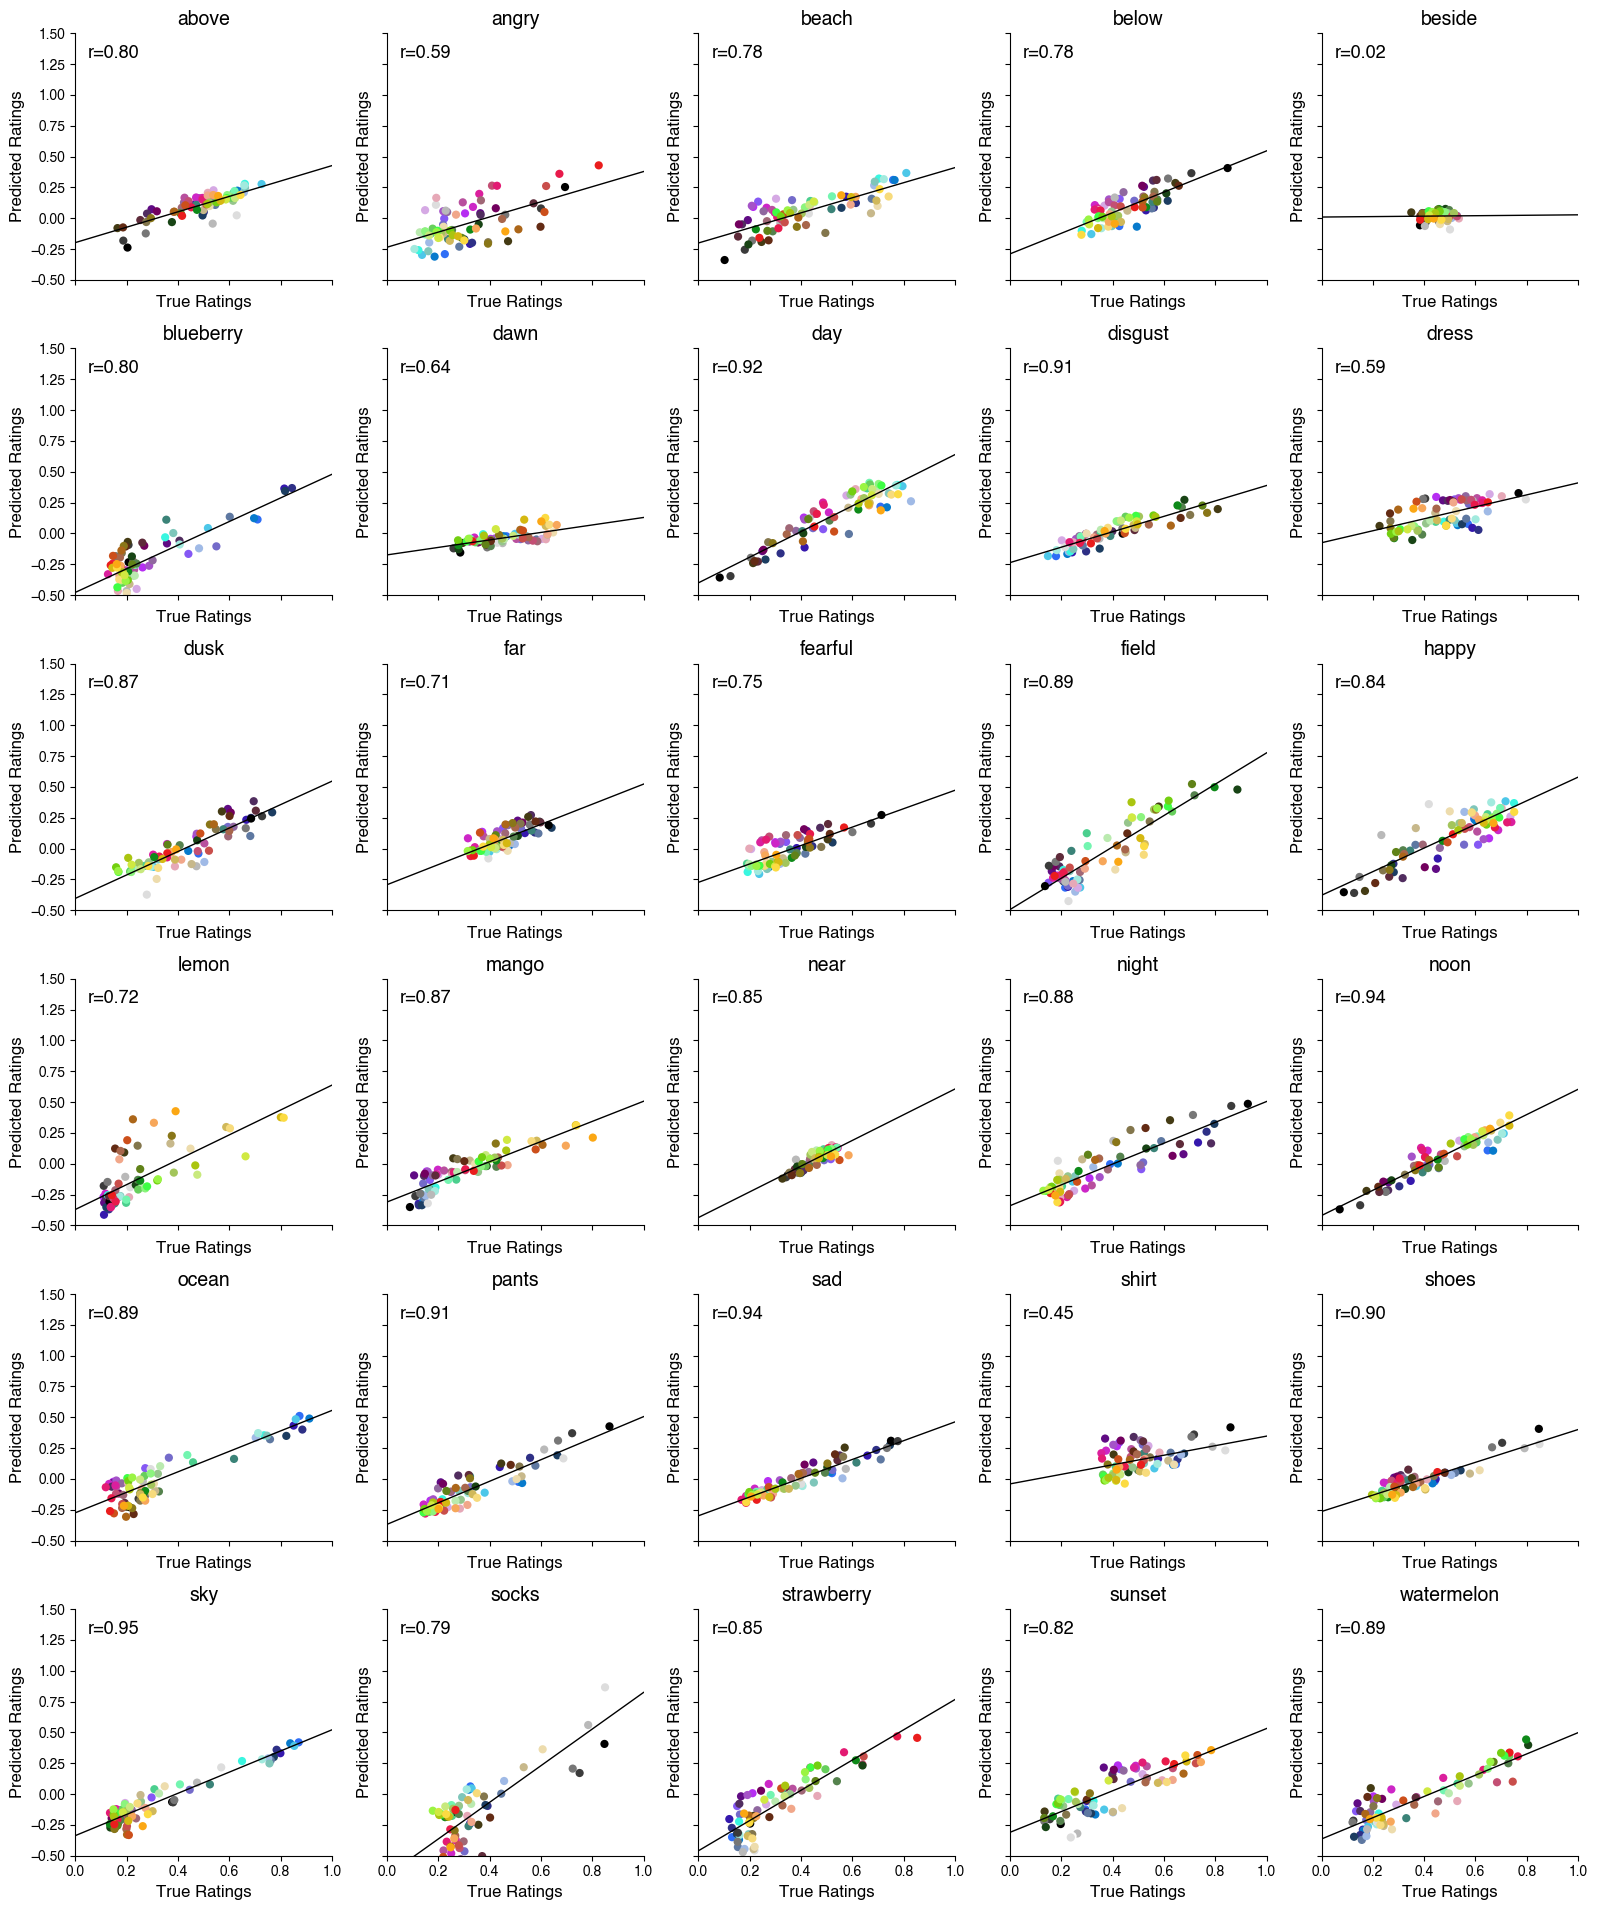

concept  pearson_r     slope  intercept  n_points
0        above   0.801364  0.624322  -0.197240        71
1        angry   0.591170  0.614099  -0.235280        71
2        beach   0.782821  0.611457  -0.200529        71
3        below   0.783153  0.835684  -0.289147        71
4       beside   0.021614  0.017966   0.009817        71
5    blueberry   0.804223  0.957754  -0.477968        71
6         dawn   0.644129  0.303672  -0.174357        71
7          day   0.917631  1.040326  -0.400765        71
8      disgust   0.905492  0.625428  -0.236800        71
9        dress   0.594321  0.485665  -0.075636        71
10        dusk   0.872105  0.950614  -0.403656        71
11         far   0.713968  0.816349  -0.293372        71
12     fearful   0.750769  0.746848  -0.273632        71
13       field   0.886706  1.271301  -0.494769        71
14       happy   0.842352  0.958582  -0.378901        71
15       lemon   0.717150  1.008614  -0.370639        71
16       mango   0.874241  0.817428  -0.310561        71
17        near   0.846835  1.043139  -0.436373        71
18       night   0.881667  0.845377  -0.340421        71
19        noon   0.943492  1.024369  -0.420293        71
20       ocean   0.893598  0.829995  -0.274258        71
21       pants   0.906451  0.874029  -0.368880        71
22         sad   0.938217  0.761569  -0.298801        71
23       shirt   0.447493  0.387618  -0.040442        71
24       shoes   0.903436  0.665167  -0.264485        71
25         sky   0.947347  0.858048  -0.336498        71
26       socks   0.792608  1.486067  -0.661525        71
27  strawberry   0.854109  1.227070  -0.459680        71
28      sunset   0.822736  0.842248  -0.310311        71
29  watermelon   0.892279  0.862719  -0.364259        71

In [126]:

exp1_human_wide = set_all_wide[set_all_wide['prompt'].isin(set1_recon_wide['concept'])]

plot_correlation_grid(exp1_human_wide, set1_recon_wide, concept_col='concept', cols_per_fig=5, rows_per_fig=6, xlim=(0, 1), ylim=(-0.5, 1.5), point_size=35, line_color='black', annotate=True, save_prefix='../../data/recon_assocs/exp1_cors', show=True, color_df=uw71coords)

In [ ]:
def create_subplot(fig, row, col, x, y, concept, title='', show_ylabel=False):
    """Helper function to create and configure a subplot"""
    ax = fig.add_subplot(7, 5, row * 5 + col + 1)  # Calculate correct position
    
    plt.scatter(x, y, color=uw71coords.color_hex.values)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='black', linewidth=1)
    
    plt.annotate(f'r={pearsonr(x,y)[0]:.2f}', xy=(.05, .9), 
             xycoords='axes fraction', fontsize=13)
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    if show_ylabel:
        ax.text(-0.27, 0.55, f'{concept}', fontsize=15, ha='center', 
                va='center', weight='bold', transform=ax.transAxes, rotation=90)
        ax.text(-0.17, 0.55, 'GPT-4', fontsize=13, ha='center', 
                va='center', weight='normal', transform=ax.transAxes, rotation=90)
    else:
        plt.ylabel('')
        plt.yticks([])
    
    if title:
        plt.title(title, fontsize=13, weight='heavy')
    
    return ax

experiment_config = {
    'noanc': {'df': gpt_assoc_noanchor_df, 'title': 'experiment 1: no anchoring', 'col': 0},
    'anc': {'df': gpt_assoc_anchor_df, 'title': 'experiment 1: w/ anchoring', 'col': 1},
    'multiple': {'df': gpt_assoc_multiple_grouped, 'title': 'experiment 1: w/ multiple ratings', 'col': 2},
    'images': {'df': gpt_assoc_images, 'title': 'experiment 2: color patches', 'col': 3},
    'hex_images': {'df': gpt_assoc_hex_images, 'title': 'experiment 2: patches + hex codes', 'col': 4}
}

for j in range(10):
    fig = plt.figure(1, figsize=(15,21))
    concepts = list(scatter_dict.keys())[j*7:j*7+7]
    
    for i, concept in enumerate(concepts):
        x = ratings_all[ratings_all.concept==concept].iloc[:,1:].values[0]
        
        for exp_type in scatter_dict[concept]:
            config = experiment_config[exp_type]
            y = config['df'][config['df'].concept==concept].iloc[:,1:].values[0]
            
            title = config['title'] + '\n' if i == 0 else ''
            ax = create_subplot(fig, i, config['col'], x, y, concept, 
                              title=title, show_ylabel=(exp_type == 'noanc'))
            
            if exp_type in ['images', 'hex_images']:
                plt.xlabel('Human', fontsize=13)
                sns.despine()
    
    plt.tight_layout()
    plt.savefig(f'../../plots/supp_mat_scatter_{j}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

## cleanup 

In [ ]:
set_2_3_recon = pd.concat([set2_recon_ratings,set3_recon_ratings],axis=0)

In [ ]:
max_col_rating = set_2_3_recon['recon_rating'].max()
min_col_rating = set_2_3_recon['recon_rating'].min()

In [ ]:
running_cors=[]
for i, this_concept in enumerate(np.unique(set_2_3_recon.concept)):
    ds = set_2_3_recon[set_2_3_recon.concept==this_concept]
    ys = ds.sort_values(by='color_index').recon_rating.values
    if ys.max()>1:
        ys= ys-np.abs(ys.max()-1)
    if ys.min()<0:
        ys= ys+np.abs(ys.min())
   

#     plt.bar(np.arange(71),((ys-min_col_rating)/(max_col_rating-min_col_rating))[sorted_col_order],\
#            color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='k')
    plt.bar(np.arange(71),ys[sorted_col_order],\
           color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='k')
    plt.title(this_concept)
    plt.ylim(0,1)
    plt.show()

In [ ]:

# for i in range(1,10):

#     approx_df_sub = holdout_con_cors[holdout_con_cors.num_pcs==i].sort_values(['holdout_cor'],ascending=False).reset_index(drop=True)
#     fig = plt.figure(figsize=(10,6))
#     sns.barplot(approx_df_sub.concept, approx_df_sub.holdout_cor, edgecolor = 'none', color='gray')
#     #plt.axis('off')
#     #plt.xticks([])
#     plt.xticks(rotation = 90, fontsize= 16)
#     plt.xlabel('')
#     plt.yticks(fontsize=18)
#     plt.ylabel('Correlation', fontsize=20)
#     plt.ylim(0,1)
#     ax = plt.gca()
#     #ax.set_facecolor((0.3497,0.3497,0.3497))
#     ax.set_facecolor((1,1,1))
#     plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} comps")
#     # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
#     plt.show()

In [ ]:


num_cols =[]
approx_cors = []
cons = []
run = [] ###track which iteration it

for this_run in trange(500):
    for num_col in range(2,20,1):
        color_inds = kmeans_cols(num_col)
       
        conc_prof_mat = np.zeros(shape=(30,6)) ## this matrix holds the approximated factor matrix 
    
        for i in range(set1_mat.shape[0]): ## iterate through each concept
            

            concept_ratings = set1_mat.iloc[i,:]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-set1_cmeans
            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[color_inds,0:6], concept_ratings[color_inds])
            #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
            coords = reg.coef_[0:6]   ## only use num_pc components
            # recon = np.matmul(A[:,:num_pc],coords)
            # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
            conc_prof_mat[i,:] = coords
            

        ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
        color_coord_mat = pd.read_csv('../../data/uw71_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
        prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors
        approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

    
        for i in range(approx_recon.shape[0]):
            concept_ratings = set1_mat.iloc[i,:]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-set1_cmeans
            #approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
            approx_cors.append(np.corrcoef(np.delete(approx_recon,color_inds,axis=1)[i,:].astype(float),np.delete(concept_ratings,color_inds).astype(float))[0,1])

            num_cols.append(num_col)
            cons.append(set1_mat.index[i])
            run.append(this_run)


approx_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors,run)), columns = ['concept','num_cols','correlation','run'])
plot_ys_kmeans = approx_df.groupby('num_cols').mean().reset_index().correlation
plot_err_kmeans = approx_df.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96

            

num_cols =[]
approx_cors = []
cons = []
run = [] ###track which iteration it

for this_run in trange(1000):
    for num_col in range(2,20,1):
        color_inds = random.sample(range(71),num_col)
       
        conc_prof_mat = np.zeros(shape=(30,6)) ## this matrix holds the approximated factor matrix 
    
        for i in range(set1_mat.shape[0]): ## iterate through each concept
            

            concept_ratings = set1_mat.iloc[i,:]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-set1_cmeans
            reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[color_inds,0:6], concept_ratings[color_inds])
            #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
            coords = reg.coef_[0:6]   ## only use num_pc components
            # recon = np.matmul(A[:,:num_pc],coords)
            # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
            conc_prof_mat[i,:] = coords
            

        ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
        color_coord_mat = pd.read_csv('../../data/uw71_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
        prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors
        approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

    
        for i in range(approx_recon.shape[0]):
            concept_ratings = set1_mat.iloc[i,:]
            concept_ratings = np.array(concept_ratings)
            concept_ratings = concept_ratings-set1_cmeans
            #approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
            approx_cors.append(np.corrcoef(np.delete(approx_recon,color_inds,axis=1)[i,:].astype(float),np.delete(concept_ratings,color_inds).astype(float))[0,1])
            num_cols.append(num_col)
            cons.append(set1_mat.index[i])
            run.append(this_run)


approx_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors,run)), columns = ['concept','num_cols','correlation','run'])
plot_ys_rand = approx_df.groupby('num_cols').mean().reset_index().correlation
plot_err_rand = approx_df.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96





In [ ]:


fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(2,20,1),plot_ys_rand)
plt.errorbar(x= np.arange(2,20,1),y = plot_ys_rand,yerr=plot_err_rand)

plt.plot(np.arange(2,20,1),plot_ys_jb, color='blue')
plt.errorbar(x= np.arange(2,20,1),y = plot_ys_jb,yerr=plot_err_jb, color='blue')


plt.plot(np.arange(2,20,1),plot_ys_kmeans, color='red')
plt.errorbar(x= np.arange(2,20,1),y = plot_ys_kmeans,yerr=plot_err_kmeans, color='red')

plt.title('Reconstructions with 6 pcs and random colors (orange) vs. colors picked with Joshi-Boyd method (blue) and kmeans(red) ')
plt.xlabel('# colors')
plt.xticks(np.arange(2,20,1))
plt.ylim(.2,1)
plt.ylabel('correlation')

In [ ]:
U_6 = U1[:,0:6]
color_comp_cors = np.zeros((6,71))
for i in range(U_6.shape[1]):
    for j in range((set1_mat-set1_cmeans).shape[1]):
        color_comp_cors[i,j] = np.corrcoef(U_6[:,i],(set1_mat-set1_cmeans).iloc[:,j])[0][1]



def maxmin_colors(num_per_comp,color_comp_cors=color_comp_cors):
    hi_cols = np.argsort(-color_comp_cors[:,:],axis=1)[:,:num_per_comp]
    lo_cols = np.argsort(color_comp_cors[:,:],axis=1)[:,:num_per_comp]

    colors = np.unique(np.hstack([hi_cols,lo_cols]).flatten())
    #colors = hi_cols.flatten()
    print(colors.shape)
    return list(colors)


from sklearn.cluster import KMeans
def kmeans_cols(ncols):
    kmeans_obj = KMeans(n_clusters=ncols).fit(uw71coords.loc[:,['L','a','b']])
    kmeans_obj.labels_
    kmeans_obj.cluster_centers_
    kmeans_inds = []
    for i,center in enumerate(kmeans_obj.cluster_centers_):
        ds = uw71coords.iloc[(kmeans_obj.labels_==i).nonzero()[0],:]
        kmeans_inds.append(ds.iloc[np.argmax(center@ds.loc[:,['L','a','b']].T),:]['color_index'])
    return(kmeans_inds)

In [ ]:
num_cols =[]
approx_cors = []
cons = []
for num_col in range(1,8):
    color_inds = maxmin_colors(num_col)
    print(f'{num_col} colors are {color_inds}')
    conc_prof_mat = np.zeros(shape=(30,6)) ## this matrix holds the approximated factor matrix 
 
    for i in range(set1_mat.shape[0]): ## iterate through each concept
        

        concept_ratings = set1_mat.iloc[i,:]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-set1_cmeans
        reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[color_inds,0:6], concept_ratings[color_inds])
        #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
        coords = reg.coef_[0:6]   ## only use num_pc components
        # recon = np.matmul(A[:,:num_pc],coords)
        # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
        conc_prof_mat[i,:] = coords
        

    ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
    color_coord_mat = pd.read_csv('../../data/uw71_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix
    prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors
    approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

   
    for i in range(approx_recon.shape[0]):
        concept_ratings = set1_mat.iloc[i,:]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-set1_cmeans
        approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
        num_cols.append(num_col)
        cons.append(set1_mat.index[i])


approx_df = pd.DataFrame(list(zip(cons,num_cols,approx_cors)), columns = ['concept','num_cols','correlation'])

In [ ]:
plot_ys = approx_df.groupby('num_cols').mean().reset_index().correlation
plot_err = approx_df.groupby('num_cols').std().reset_index().correlation/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(approx_df.num_cols.unique(),plot_ys)
plt.errorbar(x= approx_df.num_cols.unique(),y = plot_ys,yerr=plot_err)
plt.title('Reconstructions with 6 pcs and varying number of colors using High-Low method')
plt.xlabel('# colors')
plt.xticks(approx_df.num_cols.unique())
plt.ylim(.5,1)
plt.ylabel('correlation')
plot_ys

In [ ]:
sns.palplot(uw71coords[uw71coords['color_index'].isin([10, 13, 25, 29, 30, 37, 43, 49, 52, 59, 70])].color_hex.values)

### Leave one out [Concept]

### Leave one out [Color]


In [ ]:
num_pcs =[]
con_reg_cors = []
cons = []

concept_list_set1 = set1_mat.index.values

for num_pc in trange(10):
    
    for this_concept in tqdm(concept_list_set1):
        concept_ratings = set1_mat[set1_mat.index==this_concept] - set1_cmeans
        
        ds = set1_mat[set1_mat.index!=this_concept] - set1_cmeans
        color_inds = return_rows(ds,15)
        #color_inds= [11, 14, 16, 22, 24, 28, 37, 42, 43, 44, 62, 68]
        #color_inds= [11, 14, 22, 24, 37, 42, 43, 44, 62, 68]
        
        _,_,Vh = svd(ds, full_matrices=False)
        Vh = Vh.T[:,0:num_pc+1]
      
        reg = lm.LinearRegression(fit_intercept=False).fit(Vh[color_inds,:], concept_ratings[color_inds].squeeze(0))
        coords = reg.coef_[:num_pc+1]
        recon = np.matmul(coords,Vh.T)
        con_reg_cors.append(np.corrcoef(recon.astype(float),concept_ratings.squeeze(0).astype(float))[0,1])
        num_pcs.append(num_pc+1)
        cons.append(this_concept)
 



In [ ]:
holdout_con_cors = pd.DataFrame(list(zip(cons, num_pcs, con_reg_cors)),columns=['concept','num_pc','holdout_cor'])


plot_ys = holdout_con_cors.groupby('num_pc').mean().reset_index().holdout_cor
plot_err = holdout_con_cors.groupby('num_pc').std().reset_index().holdout_cor/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))

plt.plot(np.arange(1,11),plot_ys)
plt.errorbar(x= np.arange(1,11),y = plot_ys,yerr=plot_err)
plt.title('ratings matrix reconstruction pearson rs with holdout concepts')
plt.xlabel('# comps')
plt.ylabel('correlation')

plot_ys

In [ ]:
plt.figure(figsize=(10,7))
for this_concept in concept_list_set1:
    plot_ys = holdout_con_cors[holdout_con_cors.concept==this_concept].holdout_cor
    plt.plot(np.arange(1,11),plot_ys, label=this_concept)
    plt.title('ratings matrix reconstruction pearson rs with holdout concepts')
    plt.xlabel('# comps')
    plt.ylabel('correlation')
    plt.ylim(0,1)
    plt.legend(loc=(1.04,0))
    plt.show()

In [ ]:
holdout_con_cors[holdout_con_cors.concept==this_concept].holdout_cor

In [ ]:
holdout_con_cors

In [ ]:
cors = []
for i in range(0,71):
    ratings_sub = set1_mat.iloc[:,i] ## selecting column of holdout color
    ratings_sub_inv = set1_mat.drop(columns=set1_mat.columns[i]) ## select all other columns
    set1_cmeans_sub_inv = np.delete(set1_cmeans,i) ## means of all other columns
    U,S,Vh = svd((ratings_sub_inv-set1_cmeans_sub_inv), full_matrices= False)
    this_conc_prof_mat = (U@np.diag(S))[:,:6]

    
    this_prof_coef_mat = pd.read_csv(f'../../data/MATLAB_outputs/10_regression_weights_color_{i+1}.csv', header=None).to_numpy()[:,:6]

    
    #recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+set1_cmeans.reshape(71,1)
    recon = np.matmul(this_conc_prof_mat,np.matmul((this_prof_coef_mat.T),color_coord_mat)).T
    recon = recon.T
    cors.append(np.corrcoef(recon[:,i],ratings_sub.values)[0,1])
    
colcors = pd.DataFrame(list(zip(list(range(1,72)),cors)), columns = ['color','holdout_correlation'])
colcors = pd.concat([colcors, uw71rgb], axis=1)
colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)



import matplotlib.font_manager as mfm

font_path = 'FreeSerif.ttf'
prop = mfm.FontProperties(fname=font_path)


#colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(15,10))
sns.barplot(colcors.index, colcors.holdout_correlation, edgecolor = 'black', color='gray')
#plt.axis('off')
#plt.xticks([])
#plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
symbolsx = [u"■"]*colcors.shape[0]
ax.set_xticks(range(len(symbolsx)))
ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors['r_rgb'],colcors['g_rgb'],colcors['b_rgb'])))):
    tick.set_color(color)

#plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()

    

In [ ]:
colcors.holdout_correlation.mean()

In [ ]:
import matplotlib.font_manager as mfm

font_path = 'FreeSerif.ttf'
prop = mfm.FontProperties(fname=font_path)


#colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(15,10))
sns.barplot(colcors.index, colcors.holdout_correlation, edgecolor = 'black', color='gray')
#plt.axis('off')
#plt.xticks([])
#plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
symbolsx = [u"■"]*colcors.shape[0]
ax.set_xticks(range(len(symbolsx)))
ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors['r_rgb'],colcors['g_rgb'],colcors['b_rgb'])))):
    tick.set_color(color)

#plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()


In [ ]:
sns.palplot(tuple(zip(uw71rgb.iloc[:,0].values,uw71rgb.iloc[:,1].values,uw71rgb.iloc[:,2].values)))

In [ ]:
num_pcs =[]
col_reg_cors = []
cols = []

concept_list_set1 = set1_mat.index.values

for num_pc in trange(10):
    
    for i in range(0,71):
        ratings_sub = set1_mat.iloc[:,i] ## selecting column of holdout color
        ratings_sub_inv = set1_mat.drop(columns=set1_mat.columns[i]) ## select all other columns
        set1_cmeans_sub_inv = np.delete(set1_cmeans,i) ## means of all other columns
        U,S,Vh = svd((ratings_sub_inv-set1_cmeans_sub_inv), full_matrices= False)
        this_conc_prof_mat = (U@np.diag(S))[:,:num_pc]


        this_prof_coef_mat = pd.read_csv(f'../../data/MATLAB_outputs/10_regression_weights_color_{i+1}.csv', header=None).to_numpy()[:,:num_pc]


        #recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+set1_cmeans.reshape(71,1)
        recon = np.matmul(this_conc_prof_mat,np.matmul((this_prof_coef_mat.T),color_coord_mat)).T
        recon = recon.T
        col_reg_cors.append(np.corrcoef(recon[:,i],ratings_sub.values)[0,1])
        num_pcs.append(num_pc+1)
        cols.append(i)
 

In [ ]:
holdout_col_cors = pd.DataFrame(list(zip(cols, num_pcs, col_reg_cors)),columns=['color','num_pc','holdout_cor'])


plot_ys = holdout_col_cors.groupby('num_pc').mean().reset_index().holdout_cor
plot_err = holdout_col_cors.groupby('num_pc').std().reset_index().holdout_cor/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.rcParams['axes.facecolor']=(.3497,.3497,.3497)
plt.plot(np.arange(1,11),plot_ys)
plt.errorbar(x= np.arange(1,11),y = plot_ys,yerr=plot_err)
plt.title('ratings matrix reconstruction pearson rs with holdout colors')
plt.xlabel('# comps')
plt.ylabel('correlation')



In [ ]:
cors = []
for i in range(0,71):
    ratings_sub = set1_mat.iloc[:,i] ## selecting column of holdout color
    ratings_sub_inv = set1_mat.drop(columns=set1_mat.columns[i]) ## select all other columns
    set1_cmeans_sub_inv = np.delete(set1_cmeans,i) ## means of all other columns
    U,S,Vh = svd((ratings_sub_inv-set1_cmeans_sub_inv), full_matrices= False)
    this_conc_prof_mat = (U@np.diag(S))[:,:6]

    
    this_prof_coef_mat = pd.read_csv(f'../../data/MATLAB_outputs/10_regression_weights_color_{i+1}.csv', header=None).to_numpy()[:,:6]

    
    #recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+set1_cmeans.reshape(71,1)
    recon = np.matmul(this_conc_prof_mat,np.matmul((this_prof_coef_mat.T),color_coord_mat)).T
    recon = recon.T
    cors.append(np.corrcoef(recon[:,i],ratings_sub.values)[0,1])
    
colcors = pd.DataFrame(list(zip(list(range(1,72)),cors)), columns = ['color','holdout_correlation'])
colcors = pd.concat([colcors, uw71rgb], axis=1)
colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
    

In [ ]:
import matplotlib.font_manager as mfm

font_path = 'FreeSerif.ttf'
prop = mfm.FontProperties(fname=font_path)


#colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(15,10))
sns.barplot(colcors.index, colcors.holdout_correlation, edgecolor = 'black', color='gray')
#plt.axis('off')
#plt.xticks([])
#plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
symbolsx = [u"■"]*colcors.shape[0]
ax.set_xticks(range(len(symbolsx)))
ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors['r_rgb'],colcors['g_rgb'],colcors['b_rgb'])))):
    tick.set_color(color)

#plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()


## generalization

In [ ]:
set2_mat

In [ ]:
color_inds_sub = [11, 14, 24, 37, 43, 44, 62, 68] #8
#color_inds_sub = [11, 14, 22, 24, 37, 42, 43, 44, 62, 68] #10
color_inds_all = range(71)
num_cols =[]
approx_cors = []
cons = []
col_subset = []

conc_prof_mat = np.zeros(shape=(20,6)) ## this matrix holds the approximated factor matrix 
    # color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix

prof_coef_mat = pd.read_csv('../../data/MATLAB_outputs/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors

approx_basis_vecs = prof_coef_mat.T@color_coord_mat
for color_ind_set in ['all','8']:
    if color_ind_set =='all':
        color_inds = color_inds_all
    else:
        color_inds = color_inds_sub

    for i in range(set2_mat.shape[0]): ## iterate through each concept


        concept_ratings = set2_mat.iloc[i]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-set2_cmeans
        reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[color_inds,0:6], concept_ratings[color_inds])
        #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
        coords = reg.coef_[0:6]   ## only use num_pc components
        # recon = np.matmul(A[:,:num_pc],coords)
        # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
        conc_prof_mat[i,:] = coords


    ## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)

    approx_recon = conc_prof_mat@approx_basis_vecs 


    for i in range(approx_recon.shape[0]):
        concept_ratings = set2_mat.iloc[i]
        concept_ratings = np.array(concept_ratings)
        concept_ratings = concept_ratings-set2_cmeans
        approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])
        cons.append(set2_mat.index[i])
        col_subset.append(color_ind_set)


approx_df = pd.DataFrame(list(zip(cons,approx_cors,col_subset)), columns = ['concept','correlation','color_ind_subset'])
approx_df = approx_df[approx_df['concept']!='airplane']

In [ ]:

approx_df_sub = approx_df.sort_values(['correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,6))
sns.barplot(x='concept', y='correlation', hue ='color_ind_subset',edgecolor='none', data=approx_df, palette= {'all':'teal','8':'orange'},\
           order= approx_df[approx_df.color_ind_subset=='all'].sort_values(by='correlation', ascending=False).concept.values)
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
plt.legend(loc=(1.,0))

#ax.set_facecolor((1,1,1))
#plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} colors")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()

In [ ]:
approx_df[approx_df.color_ind_subset=='all'].correlation.mean()

In [ ]:
color_inds_sub = [11, 14, 24, 37, 43, 44, 62, 68] #8# 
#color_inds_sub = [1, 4, 11, 13, 14, 16, 20, 22, 24, 28, 37, 42, 43, 44, 59, 62, 66, 68, 69] #19
color_inds_all = range(71)
num_cols =[]
approx_cors = []
cons = []
col_subset = []

conc_prof_mat = np.zeros(shape=(20,6)) ## this matrix holds the approximated factor matrix 
    # color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix

prof_coef_mat = pd.read_csv('../../data/MATLAB_outputs/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors

approx_basis_vecs = prof_coef_mat.T@color_coord_mat


color_inds = color_inds_sub

for i in range(set2_mat.shape[0]): ## iterate through each concept


    concept_ratings = set2_mat.iloc[i]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-set2_cmeans
    reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[color_inds,0:6], concept_ratings[color_inds])
    #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
    coords = reg.coef_[0:6]   ## only use num_pc components
    # recon = np.matmul(A[:,:num_pc],coords)
    # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
    conc_prof_mat[i,:] = coords


## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)

approx_recon = conc_prof_mat@approx_basis_vecs 


for i in range(approx_recon.shape[0]):
    concept_ratings = set2_mat.iloc[i]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-set2_cmeans
    approx_cors.append(np.corrcoef(np.delete(approx_recon,color_inds,axis=1)[i,:].astype(float),np.delete(concept_ratings,color_inds).astype(float))[0,1])
    cons.append(set2_mat.index[i])
    col_subset.append(color_ind_set)


approx_df = pd.DataFrame(list(zip(cons,approx_cors,col_subset)), columns = ['concept','correlation','color_ind_subset'])
approx_df = approx_df[approx_df['concept']!='airplane']

In [ ]:
Tot = 20
Cols = 6
Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(25,10))


for i,con in enumerate(np.unique(set2_grouped.prompt)):
    
    ax = fig.add_subplot(Rows,Cols,Position[i])

    ds = approx_recon[i,:]+set2_cmeans

    plt.bar(np.arange(71),ds[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none') 
    #plt.bar(np.arange(71),ds.iloc[:,3].values) 
    
    plt.title(con, fontsize=18)    
    plt.ylim(-.5,1.2)
    ax = plt.gca()
    ax.set_facecolor((0.349,0.349,0.349))
    plt.xticks([])

plt.savefig(f'../../data/recon_assocs/set2_recon_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
plt.show()

In [ ]:

approx_df_sub = approx_df.sort_values(['correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,6))
sns.barplot(x='concept', y='correlation', hue ='color_ind_subset',edgecolor='none', data=approx_df, palette= {'all':'teal','8':'orange'},\
            order= approx_df.sort_values(by='correlation', ascending=False).concept.values)
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
plt.legend(loc=(1.,0))
ax.set_facecolor((0.3497,0.3497,0.3497))
#ax.set_facecolor((1,1,1))
#plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} colors")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()

In [ ]:
approx_df

In [ ]:
approx_df.correlation.mean()

In [ ]:
Tot = 20
Cols = 6
Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(25,10))


for i,con in enumerate(np.unique(set3_mat.index)):
    ax = fig.add_subplot(Rows,Cols,Position[i])

    ds = set3_mat[set3_mat.index==con]

    plt.bar(np.arange(71),ds.iloc[:,sorted_col_order].values.flatten(),color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none') 
    #plt.bar(np.arange(71),ds.iloc[:,3].values) 
    
    plt.title(con, fontsize=18)   
    plt.ylim(0,1)
    ax = plt.gca()
    ax.set_facecolor((0.349,0.349,0.349))
    plt.xticks([])
#     plt.savefig(f'../../data/recon_assocs/{con}_mean_ratings.pdf',format = 'pdf', bbox_inches= 'tight')


plt.savefig(f'../../data/recon_assocs/set3_mean_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
plt.show()

In [ ]:
color_inds_sub = [11, 14, 24, 37, 43, 44, 62, 68] #8
#color_inds_sub = [11, 14, 22, 24, 37, 42, 43, 44, 62, 68] #10
color_inds_all = range(71)
num_cols =[]
approx_cors = []
cons = []
col_subset = []

conc_prof_mat = np.zeros(shape=(20,6)) ## this matrix holds the approximated factor matrix 
    # color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy() ### color coordinate matrix

prof_coef_mat = pd.read_csv('../../data/MATLAB_outputs/10_regression_weights.csv',header=None).to_numpy()[:,:6] ## weights to approximate first num_pc coordinates of the right singular vectors

approx_basis_vecs = prof_coef_mat.T@color_coord_mat


color_inds = color_inds_sub

for i in range(set3_mat.shape[0]): ## iterate through each concept


    concept_ratings = set3_mat.iloc[i]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-set3_cmeans
    reg = lm.LinearRegression(fit_intercept=False).fit(basis_vecs1.T[color_inds,0:6], concept_ratings[color_inds])
    #reg = lm.LinearRegression().fit(A[:,0:num_pc], concept_ratings)
    coords = reg.coef_[0:6]   ## only use num_pc components
    # recon = np.matmul(A[:,:num_pc],coords)
    # cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
    conc_prof_mat[i,:] = coords


## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)

approx_recon = conc_prof_mat@approx_basis_vecs 


for i in range(approx_recon.shape[0]):
    concept_ratings = set3_mat.iloc[i]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-set3_cmeans
    approx_cors.append(np.corrcoef(np.delete(approx_recon,color_inds,axis=1)[i,:].astype(float),np.delete(concept_ratings,color_inds).astype(float))[0,1])
    cons.append(set3_mat.index[i])
    col_subset.append(color_ind_set)


approx_df = pd.DataFrame(list(zip(cons,approx_cors,col_subset)), columns = ['concept','correlation','color_ind_subset'])
approx_df = approx_df[approx_df['concept']!='airplane']

In [ ]:

approx_df_sub = approx_df.sort_values(['correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,6))
sns.barplot(x='concept', y='correlation', hue ='color_ind_subset',edgecolor='none', data=approx_df, palette= {'all':'teal','8':'orange'},\
            order= approx_df.sort_values(by='correlation', ascending=False).concept.values)
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
plt.legend(loc=(1.,0))
ax.set_facecolor((0.3497,0.3497,0.3497))
#ax.set_facecolor((1,1,1))
#plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} colors")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()

In [ ]:
approx_df.correlation.mean()

In [ ]:
Tot = 20
Cols = 6
Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(25,10))

for i,con in enumerate(set3_mat.index):

    ds = approx_recon[i,:]+set3_cmeans
    ax = fig.add_subplot(Rows,Cols,Position[i])

    ax.bar(np.arange(71),ds[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none') 
    #plt.bar(np.arange(71),ds.iloc[:,3].values) 
    
    plt.title(con, fontsize=18)   
    plt.ylim(-1,1.3)
#     ax = plt.gca()
    ax.set_facecolor((0.349,0.349,0.349))
    plt.xticks([])
    #ax.savefig(f'../../data/recon_assocs/{con}_recon_ratings.pdf',format = 'pdf', bbox_inches= 'tight')

plt.savefig(f'../../data/recon_assocs/set3_recon_ratings.pdf',format = 'pdf', bbox_inches= 'tight')
plt.show()

In [ ]:
set3_cmeans

In [ ]:
kmeans_inds = np.unique(kmeans_inds)

In [ ]:
sns.palplot(uw71coords[uw71coords['color_index'].isin(kmeans_cols(8))].color_hex.values)


### combine datasets and test generalization

In [ ]:
v_sub = basis_vecs_all[0:10,]
v_sub_df = pd.DataFrame(v_sub.T, columns=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'])
v_sub_df = pd.concat([v_sub_df, uw71rgb],axis=1)

components = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

for i in range(len(components)):
    sns.set(rc={
               'axes.grid':False})
    plt.figure(figsize=(10,5))


    plotdf = v_sub_df.sort_values([str(components[i])]).reset_index(drop=True)
    fig = sns.barplot(plotdf.index, plotdf[components[i]], edgecolor = 'none',palette = sns.color_palette(list(zip(plotdf['r_rgb'],plotdf['g_rgb'],plotdf['b_rgb']))))
    #plt.axis('off')
    plt.xticks([])
    plt.ylabel('')
    plt.ylim(-0.4,0.4)
    ax = plt.gca()
    ax.set_facecolor((0.3497,0.3497,0.3497))
    plt.title(f'Component {i+1}')
    
    #plt.savefig('component_{}.pdf'.format(i))
    plt.show()

In [ ]:

Tot = 50
Cols = 5
Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(50,20))


num_pcs =[]
con_reg_cors = []
cons = []

for num_pc in trange(5,6):

  
 
    for i,this_concept in tqdm(enumerate(set_all_mat.index.values)):
        ax = fig.add_subplot(Rows, Cols, Position[i])
        concept_ratings = set_all_mat-set_all_cmeans
        concept_ratings_inv= concept_ratings[concept_ratings.index!=this_concept]
        color_inds = return_rows(concept_ratings_inv,8)
        #concept_ratings=[~concept_ratings.index.isin([this_concept])]
        _,_,Vh = svd(concept_ratings_inv, full_matrices=False)
#         A = pd.read_csv('../../data/basis_vecs_scaled_{}.csv'.format(this_concept))
#         A = np.array(A)
        #A = np.delete(A, 0, axis=1)
        Vh_ = Vh[0:num_pc+1,color_inds]
        #concept_ratings = np.array(ratings[ratings.iloc[:,0].isin([this_concept])].iloc[:,1:59])-c_means.V1.values
        #reg = lm.LinearRegression().fit(A[color_inds,:], concept_ratings.squeeze(0)[color_inds])
        reg = lm.LinearRegression(fit_intercept=False).fit(Vh_.T, concept_ratings[concept_ratings.index==this_concept].squeeze(0).values[color_inds])
        coords = reg.coef_[:num_pc+1]
        recon = np.matmul(Vh[0:num_pc+1,:].T,coords.T)
        
        plt.bar(np.arange(71),recon[sorted_col_order]+set_all_cmeans,color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
        plt.title(this_concept,fontsize=20)   
        plt.ylim(-1.5,1.5)
        ax.set_facecolor((0.349,0.349,0.349))
        plt.xticks([])

        con_reg_cors.append(np.corrcoef(np.delete(recon.astype(float).flatten(),color_inds),np.delete(concept_ratings[concept_ratings.index==this_concept].squeeze(0).astype(float).values.flatten(),color_inds))[0,1]    )
        num_pcs.append(num_pc+1)
        cons.append(this_concept)  
holdout_con_cors = pd.DataFrame(list(zip(cons, num_pcs, con_reg_cors)),columns=['concept','num_pcs','holdout_cor'])
plt.savefig(f'../../data/recon_assocs/set_all_recon_ratings.pdf')
plt.show()





In [ ]:
holdout_con_cors.holdout_cor.mean()

In [ ]:

approx_df_sub = holdout_con_cors.sort_values(['holdout_cor'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,6))
sns.barplot(x='concept', y='holdout_cor',edgecolor='none', data=approx_df_sub, color='orange')
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
plt.legend(loc=(1.,0))
ax.set_facecolor((0.3497,0.3497,0.3497))
#ax.set_facecolor((1,1,1))
#plt.title(f"Reconstruction using approximations of both matrices with no holdout w {i} colors")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()

In [ ]:

Tot = 50
Cols = 5
Rows = Tot // Cols 
Rows += Tot % Cols

Position = range(1,Tot + 1)

fig = plt.figure(1,figsize=(50,20))
for i,this_concept in tqdm(enumerate(holdout_con_cors.concept)):
    recon = np.array(holdout_con_cors[holdout_con_cors.concept==this_concept])
    plt.bar(np.arange(71),recon[sorted_col_order],color=np.array(uw71coords.iloc[sorted_col_order,:]['color_hex'].values),edgecolor='none')
    plt.title(this_concept,fontsize=20)   
    plt.ylim(-1.5,1.5)
    ax.set_facecolor((0.349,0.349,0.349))
    plt.xticks([])
    
plt.show()


### color regressions

In [ ]:

a = basis_vecs1[0]

In [ ]:

b= np.array((uw71coords['L'],np.cos(uw71coords['H']*(np.pi/180)),\
             np.sin(uw71coords['H']*(np.pi/180)),np.cos(2*uw71coords['H']*(np.pi/180)),\
             np.sin(2*uw71coords['H']*(np.pi/180)),uw71coords['C']))


In [ ]:
m = lm.LinearRegression(fit_intercept=True).fit(b.T, a.reshape(71,1))

In [ ]:
np.append(m.intercept_,m.coef_)

In [ ]:
np.cos(uw71coords['H']*(np.pi/180))

In [ ]:
plt.bar(np.arange(71),recon[sorted_col_order])


In [ ]:
a,b = colorimetric_reg(basis_vecs1[:6,:].T)

In [ ]:
a.shape

In [ ]:
a[0,:].shape

In [ ]:
uw71regressors[:,1]

In [ ]:
np.array((uw71coords['L'],np.cos(uw71coords['H']*(np.pi/180)),\
                 np.sin(uw71coords['H']*(np.pi/180)),np.cos(2*uw71coords['H']*(np.pi/180)),\
                 np.sin(2*uw71coords['H']*(np.pi/180)),uw71coords['C']))

In [ ]:
import matplotlib as mpl 
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10,10))

#display_axes = fig.add_axes([1,1,1,1], projection='polar')
# display_axes._direction = 2*np.pi ## This is a nasty hack - using the hidden field to 
#                                   ## multiply the values such that 1 become 2*pi
#                                   ## this field is supposed to take values 1 or -1 only!!

norm = mpl.colors.Normalize(0.0, 2*np.pi)

# Plot the colorbar onto the polar axis
# note - use orientation horizontal so that the gradient goes around
# the wheel rather than centre out
# quant_steps = 256
# cb = mpl.colorbar.ColorbarBase(ax, cmap=e_cmap,
#                                    norm=norm,
#                                    orientation='horizontal')

# aesthetics - get rid of border and axis labels                                   
#cb.outline.set_visible(False)                                 #
#ax.set_axis_off()


n = 720  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(2.5,.05,100)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm,cmap = e_cmap,zorder=-1) 

ax.plot( [hangle*np.pi/180,hangle*np.pi/180], [0,rho],color='k',linewidth=2,linestyle ='-',marker='o',markersize=8)
hangle_ = np.mod(hangle+180,360)
ax.plot( [hangle_*np.pi/180,hangle_*np.pi/180], [0,rho],color='k',linewidth=2,linestyle =':',marker='o',markersize=8)

#ax.set_rlim(-0.025,.05)
ax.set_rmax(.05)
ax.set_rticks([0,0,0.02,0.04])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True,color='k')

#ax.set_title("A line plot on a polar axis", va='bottom')
ax.tick_params(labelsize=25,pad=10)



plt.show() # Replace with plt.savefig if you want to save a file

In [ ]:
hangle2

In [ ]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(10,10))

#display_axes = fig.add_axes([1,1,1,1], projection='polar')
# display_axes._direction = 2*np.pi ## This is a nasty hack - using the hidden field to 
#                                   ## multiply the values such that 1 become 2*pi
#                                   ## this field is supposed to take values 1 or -1 only!!

norm = mpl.colors.Normalize(0.0, 2*np.pi)

# Plot the colorbar onto the polar axis
# note - use orientation horizontal so that the gradient goes around
# the wheel rather than centre out
# quant_steps = 256

# cb = mpl.colorbar.ColorbarBase(ax, cmap=e_cmap,
#                                    norm=norm,
#                                    orientation='horizontal')



n = 720  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(2.5,.05,100)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm,cmap = e_cmap,zorder=-1) 


# aesthetics - get rid of border and axis labels                                   
#cb.outline.set_visible(False)                                 #
#ax.set_axis_off()





ax.plot( np.append(hangle2*np.pi/180,hangle2*np.pi/180), np.array((0,0,rho2[0],rho2[1])),color='k',linewidth=2,marker='o',markersize=8,linestyle='-')

hangle2_ = np.mod(hangle2+90,360)
ax.plot( np.append(hangle2_*np.pi/180,hangle2_*np.pi/180), np.array((0,0,rho2[0],rho2[1])),color='k',linewidth=2,marker='o',markersize=8,linestyle=':')



ax.set_rmax(.05)
ax.set_rticks([0,0,0.02,0.04])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

ax.grid(True,color='k', linewidth=1.2)

#ax.set_title("A line plot on a polar axis", va='bottom')
ax.tick_params(labelsize=25,pad=10,zorder=2)



plt.show() # Replace with plt.savefig if you want to save a file

In [ ]:
 np.array((0,0,rho2[0],rho2[1]))